In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

In [3]:
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [4]:
df = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv',low_memory=False)
st =  pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv',low_memory=False)

In [5]:
df.head()

item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5

In [6]:
st.head()

shop_id  shop_area_sq_ft shop_profile
0  SHOP047              528     Moderate
1  SHOP009              676         High
2  SHOP083              676          Low
3  SHOP117              676          Low
4  SHOP042              676          Low

<br>The following code snippet shows the customer arrivels in the given period of time ( 2021-10-15 to 2021-12-15 ) per shop. 

In [7]:
# Group the DataFrame by shop ID, transaction date, and customer ID
grouped = df.groupby(['shop_id', 'transaction_date', 'customer_id'])

# Count the number of unique customer arrivals
arrival_count = grouped.size().groupby(['shop_id']).count()

# Convert the result to a DataFrame and reset the index
result2 = pd.DataFrame({'customer_arrival_count': arrival_count}).reset_index()
result2.head()

shop_id  customer_arrival_count
0  SHOP001                    1552
1  SHOP002                    3741
2  SHOP003                    2874
3  SHOP004                    2644
4  SHOP005                    3222

In [8]:
# Group the DataFrame by shop_id and count the number of unique dates in the transaction_date column in each group
date_count_df = df.groupby('shop_id')['transaction_date'].nunique().reset_index()

# Rename the columns in the new DataFrame
date_count_df.columns = ['shop_id', 'unique_date_count']

# Print the new DataFrame
print(date_count_df.loc[date_count_df['unique_date_count']!=62])

     shop_id  unique_date_count
7    SHOP008                  6
54   SHOP055                 55
108  SHOP112                 61
116  SHOP120                 60


In [9]:
df.describe()

invoice_id     item_price  quantity_sold
count  4.676540e+05  473974.000000  473974.000000
mean   1.996684e+06     206.689734       1.925506
std    1.344594e+06     166.764732       1.634535
min    1.700000e+01      35.000000      -1.000000
25%    1.032114e+06     100.000000       1.000000
50%    2.032996e+06     200.000000       2.000000
75%    3.032568e+06     220.000000       2.000000
max    8.331754e+06   17400.000000     101.000000

In [10]:
df.isnull().sum()

item_description    35928
transaction_date        0
invoice_id           6320
customer_id             0
shop_id                 0
item_price              0
quantity_sold           0
dtype: int64

Null values are in the transaction date and item description columns. 

<br>Following code snippet shows the unique invoice count that each shop has issued.

In [11]:
shop_invoice_count_df = df.groupby('shop_id')['invoice_id'].nunique().reset_index()

# Rename the columns in the new DataFrame
shop_invoice_count_df.columns = ['shop_id', 'unique_invoice_count']

# Print the new DataFrame
print(shop_invoice_count_df.head(10))

   shop_id  unique_invoice_count
0  SHOP001                  1537
1  SHOP002                  3769
2  SHOP003                  2867
3  SHOP004                  2641
4  SHOP005                  3183
5  SHOP006                  2886
6  SHOP007                  2903
7  SHOP008                   203
8  SHOP009                  3493
9  SHOP010                  3437


<br>Following code gives the unique customer count for each shop.

In [12]:
grouped1 = df.groupby('shop_id')['customer_id'].nunique()

# Convert the result to a DataFrame and reset the index
result1 = pd.DataFrame({'unique_customers': grouped1}).reset_index()
result1.head()

shop_id  unique_customers
0  SHOP001              1118
1  SHOP002              2577
2  SHOP003              2064
3  SHOP004              1744
4  SHOP005              2203

Quentity_sold column contains unacceptable values such as negative values and zero. 

In [13]:
df['quantity_sold'].unique()

array([  2,   5,   1,   3,   4,   6,   0,  15,   7,  16,   8,  12,   9,
        14,  11,  10,  30,  13,  23,  24,  -1,  17,  20,  49,  48,  21,
        26,  31,  25,  36,  37,  19,  66,  59,  62,  22,  71,  39,  18,
        35,  42,  27,  33,  41,  46,  50,  40,  29,  97,  28,  72,  56,
        38,  43,  32,  76,  51,  52,  44,  45,  73,  61,  63, 100, 101,
        34,  60,  47,  53])

<br>Check how any rows are there in the dataframe with quantity_sold is zero and item_price is greater than 300. ( to check the reasonability of fill that values with quentity sold = 1).

In [14]:
df[(df['quantity_sold']==0) & (df['item_price']>=300)]

item_description          transaction_date  invoice_id customer_id  \
75314   LIME CRUSH JUICE 1L  2021-12-04T00:00:00.000Z   1310839.0        Y3OX   
464326      TONIC PET 500ML  2021-12-04T00:00:00.000Z    440044.0        AHTZ   

        shop_id  item_price  quantity_sold  
75314   SHOP089         650              0  
464326  SHOP102         320              0

<br>Becouse item prices are very low for the when item count is equals to zero. it is reasonable to fit those with 1. ( aca. impute 1 insted of zero ).<br> And impute negative values with their absolute values.

In [15]:
df['quantity_sold'] = df['quantity_sold'].replace(0, 1)
df['quantity_sold'] = df['quantity_sold'].abs().fillna(df['quantity_sold'].abs())

<br>invoice id and the customer id does not relevent to predict the target. then just dropped it.

In [16]:
df.drop(['invoice_id',"customer_id"],axis=1,inplace=True)

In [17]:
df['item_description'] = df['item_description'].fillna('N/A')

In [18]:
item_list = df['item_description'].unique()
item_list = item_list.tolist()

<br>The dataframe (df) contains more than 400,000 rows. But we need to determine whether a Shop is Low, Moderate or High. So the following code gets the each unique shop into a one row and the other atributess are the beverages that that the corresponding shop has sold. the number under the each beverage indicate the quentity of the sold items of that iem type. For example in the first row SHOP001 has sold 63 BOTTLED DRINKING WATER 1.5L, 220 BOTTLED DRINKING WATER 500ML and so on...

In [19]:
df_grouped = df.groupby(['shop_id', 'item_description']).agg({'quantity_sold': 'sum'}).reset_index()
df_pivot = df_grouped.pivot(index='shop_id', columns='item_description', values='quantity_sold').reset_index()
df_pivot.head(5)

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   NaN   
1                                        381.0                   NaN   
2                                        357.0                   NaN   
3                                        170.0                   NaN   
4                                        217.0                   4.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   

item_description  FIT O MANGO 1L  ...  ORANGE BARLEY 1.5L  ORANGE CRUSH 1.5L  \
0                           36.0  ...               205.0               53.0   
1                           66.0  ...               397.0              184.0   
2                          106.0  ...               283.0              104.0   
3                           48.0  ...               308.0               97.0   
4                          122.0  ...               222.0              128.0   

item_description  ORANGE CRUSH 1L  ORANGE CRUSH 500ML  SODA 1L  SODA 500ML  \
0                            20.0                27.0     99.0       135.0   
1                            25.0                66.0    278.0       370.0   
2                            10.0                49.0    229.0       284.0   
3                            19.0                64.0    234.0       297.0   
4                            15.0                50.0    231.0       189.0   

item_description  SODA PET 1.5L  STRAWBERRY MILK 180ML  TONIC PET 500ML  \
0                          97.0                   30.0            130.0   
1                         455.0                   53.0            332.0   
2                         275.0                   83.0            281.0   
3                         181.0                   97.0            187.0   
4                         243.0                  122.0            233.0   

item_description  TWISTEE APPLE 1L  
0                             21.0  
1                             54.0  
2                             33.0  
3                             49.0  
4                             57.0  

[5 rows x 39 columns]

shop008 is clearly an outlier since it has only records for 8 days. so let just drop it from the both dataframes.

In [20]:
# Drop rows where shop_id is "SHOP008"
df = df.drop(index=df[df['shop_id'] == 'SHOP008'].index)
st = st.drop(index=st[st['shop_id'] == 'SHOP008'].index)

In [21]:
df_pivot.fillna(0, inplace=True)

<br>Create a new feature called "total_item_count" which represent the number of all the types of beverages that have been sold by each shop.

In [22]:
df_pivot['total_item_count'] = df_pivot.drop(['shop_id'], axis=1).sum(axis=1)
df_pivot.head()

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   0.0   
1                                        381.0                   0.0   
2                                        357.0                   0.0   
3                                        170.0                   0.0   
4                                        217.0                   4.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   

item_description  FIT O MANGO 1L  ...  ORANGE CRUSH 1.5L  ORANGE CRUSH 1L  \
0                           36.0  ...               53.0             20.0   
1                           66.0  ...              184.0             25.0   
2                          106.0  ...              104.0             10.0   
3                           48.0  ...               97.0             19.0   
4                          122.0  ...              128.0             15.0   

item_description  ORANGE CRUSH 500ML  SODA 1L  SODA 500ML  SODA PET 1.5L  \
0                               27.0     99.0       135.0           97.0   
1                               66.0    278.0       370.0          455.0   
2                               49.0    229.0       284.0          275.0   
3                               64.0    234.0       297.0          181.0   
4                               50.0    231.0       189.0          243.0   

item_description  STRAWBERRY MILK 180ML  TONIC PET 500ML  TWISTEE APPLE 1L  \
0                                  30.0            130.0              21.0   
1                                  53.0            332.0              54.0   
2                                  83.0            281.0              33.0   
3                                  97.0            187.0              49.0   
4                                 122.0            233.0              57.0   

item_description  total_item_count  
0                           3982.0  
1                           9647.0  
2                           7021.0  
3                           6468.0  
4                           7847.0  

[5 rows x 40 columns]

<br>Create a new feature called "total_price". This attribute represents the total sales of the each shop for the entire period.

In [23]:
price_sum = df.groupby('shop_id')['item_price'].sum()
df_pivot['total_price'] = df_pivot['shop_id'].map(price_sum)
df_pivot.head()

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   0.0   
1                                        381.0                   0.0   
2                                        357.0                   0.0   
3                                        170.0                   0.0   
4                                        217.0                   4.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   

item_description  FIT O MANGO 1L  ...  ORANGE CRUSH 1L  ORANGE CRUSH 500ML  \
0                           36.0  ...             20.0                27.0   
1                           66.0  ...             25.0                66.0   
2                          106.0  ...             10.0                49.0   
3                           48.0  ...             19.0                64.0   
4                          122.0  ...             15.0                50.0   

item_description  SODA 1L  SODA 500ML  SODA PET 1.5L  STRAWBERRY MILK 180ML  \
0                    99.0       135.0           97.0                   30.0   
1                   278.0       370.0          455.0                   53.0   
2                   229.0       284.0          275.0                   83.0   
3                   234.0       297.0          181.0                   97.0   
4                   231.0       189.0          243.0                  122.0   

item_description  TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  \
0                           130.0              21.0            3982.0   
1                           332.0              54.0            9647.0   
2                           281.0              33.0            7021.0   
3                           187.0              49.0            6468.0   
4                           233.0              57.0            7847.0   

item_description  total_price  
0                    433145.0  
1                   1090135.0  
2                    769685.0  
3                    711050.0  
4                    842995.0  

[5 rows x 41 columns]

<Null column description imputation.

<br>Replace the shop_profile attribute values with 0,1 and 2 insted of "Low","Moderate" and "High" for the simplicity.

In [24]:
le = LabelEncoder()

# Replace null values with a placeholder
st['shop_profile'].fillna(value='NA', inplace=True)

# Modify the label encoding
target_map = {'Low': 0, 'Moderate': 1, 'High': 2}
le.fit(list(target_map.keys()))
st['shop_profile'] = st['shop_profile'].map(target_map)

In [25]:
st.head()

shop_id  shop_area_sq_ft  shop_profile
0  SHOP047              528           1.0
1  SHOP009              676           2.0
2  SHOP083              676           0.0
3  SHOP117              676           0.0
4  SHOP042              676           0.0

<br>shop_area_sq_ft and	shop_profile attributes are added to the df_combined dataframe form the st dataframe.

In [26]:
df_combined = pd.merge(df_pivot, st, on='shop_id', how='inner')

<br>Take MI scores for the attributes with the target variable.

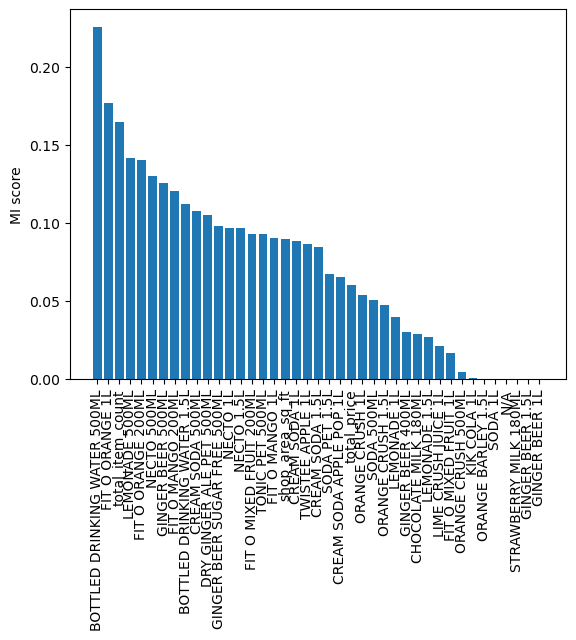

In [27]:
from sklearn.feature_selection import mutual_info_classif

df_mic = df_combined.dropna(subset=['shop_profile'])
mi_score = mutual_info_classif(df_mic.drop(['shop_profile','shop_id'],axis=1),df_mic['shop_profile'])
mi_score = pd.DataFrame({'feature': df_mic.drop(['shop_profile','shop_id'],axis=1).columns,'MI score':mi_score})
mi_score = mi_score.sort_values('MI score',ascending=False)

plt.bar(mi_score['feature'], mi_score['MI score'])
plt.xticks(rotation=90)
plt.ylabel('MI score')
plt.show()

<br>Create some new feature called tot_inc_sqft,tot_drinking_water and tot_fit_o_orange. The intution behind this feature creation is based on the MI score that we have calculated before.

In [28]:
df_combined['tot_inc_sqft'] = df_combined['total_price']*df_combined['shop_area_sq_ft']
df_combined['tot_drinking_water']= 3*df_combined['BOTTLED DRINKING WATER 1.5L']+ df_combined['BOTTLED DRINKING WATER 500ML']
df_combined['tot_fit_o_orange']= df_combined['FIT O ORANGE 1L']+ df_combined['FIT O ORANGE 200ML']

In [29]:
df_combined.head()

shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
0  SHOP001                         63.0                         220.0   
1  SHOP002                        123.0                         381.0   
2  SHOP003                        146.0                         357.0   
3  SHOP004                         77.0                         170.0   
4  SHOP005                        119.0                         217.0   

   CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                   0.0            371.0           29.0             153.0   
1                   0.0           1110.0           65.0             802.0   
2                   0.0            646.0          100.0             524.0   
3                   0.0            563.0           59.0             369.0   
4                   4.0            569.0           50.0             431.0   

   CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
0                     99.0                      24.0            36.0  ...   
1                    168.0                      92.0            66.0  ...   
2                    222.0                      41.0           106.0  ...   
3                     97.0                      50.0            48.0  ...   
4                    165.0                      67.0           122.0  ...   

   STRAWBERRY MILK 180ML  TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  \
0                   30.0            130.0              21.0            3982.0   
1                   53.0            332.0              54.0            9647.0   
2                   83.0            281.0              33.0            7021.0   
3                   97.0            187.0              49.0            6468.0   
4                  122.0            233.0              57.0            7847.0   

   total_price  shop_area_sq_ft  shop_profile  tot_inc_sqft  \
0     433145.0              580           0.0   251224100.0   
1    1090135.0              637           NaN   694415995.0   
2     769685.0              810           2.0   623444850.0   
3     711050.0              516           0.0   366901800.0   
4     842995.0              617           0.0   520127915.0   

   tot_drinking_water  tot_fit_o_orange  
0               409.0             168.0  
1               750.0             307.0  
2               795.0             321.0  
3               401.0             397.0  
4               574.0             480.0  

[5 rows x 46 columns]

<br>Extract the shops that we are supposed to predict to a dataframe called "df_target".

In [30]:
df_target =df_combined[df_combined['shop_profile'].isnull()]

In [31]:
df_combined.dropna(subset=['shop_profile'],inplace=True)
df_combined = df_combined.reset_index(drop=True)
df_combined.head()

shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
0  SHOP001                         63.0                         220.0   
1  SHOP003                        146.0                         357.0   
2  SHOP004                         77.0                         170.0   
3  SHOP005                        119.0                         217.0   
4  SHOP006                         86.0                         278.0   

   CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                   0.0            371.0           29.0             153.0   
1                   0.0            646.0          100.0             524.0   
2                   0.0            563.0           59.0             369.0   
3                   4.0            569.0           50.0             431.0   
4                   0.0            671.0           66.0             429.0   

   CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
0                     99.0                      24.0            36.0  ...   
1                    222.0                      41.0           106.0  ...   
2                     97.0                      50.0            48.0  ...   
3                    165.0                      67.0           122.0  ...   
4                    178.0                      70.0            82.0  ...   

   STRAWBERRY MILK 180ML  TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  \
0                   30.0            130.0              21.0            3982.0   
1                   83.0            281.0              33.0            7021.0   
2                   97.0            187.0              49.0            6468.0   
3                  122.0            233.0              57.0            7847.0   
4                  117.0            142.0              58.0            7258.0   

   total_price  shop_area_sq_ft  shop_profile  tot_inc_sqft  \
0     433145.0              580           0.0   251224100.0   
1     769685.0              810           2.0   623444850.0   
2     711050.0              516           0.0   366901800.0   
3     842995.0              617           0.0   520127915.0   
4     761765.0              676           0.0   514953140.0   

   tot_drinking_water  tot_fit_o_orange  
0               409.0             168.0  
1               795.0             321.0  
2               401.0             397.0  
3               574.0             480.0  
4               536.0             314.0  

[5 rows x 46 columns]

<br>Following function plot scatter plot aginst two variables. colors indicate what the target variable is.<br>(This and following two code snippits are taken by the one of the kaggle notebooks and edited by us appropiately. please note that the credit goes to original programmers who had written these two).

In [32]:
def plot_feat1_feat2(feat1, feat2) :  
    M = df_combined[(df_combined['shop_profile'] == 1)]
    H = df_combined[(df_combined['shop_profile'] == 2)]
    L = df_combined[(df_combined['shop_profile'] == 0)]

    trace0 = go.Scatter(
        x = L[feat1],
        y = L[feat2],
        name = 'Low',
        mode = 'markers', 
        marker = dict(color = '#98df8a',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'Moderate',
        mode = 'markers',
        marker = dict(color = '#aec7e8',
            line = dict(
                width = 1)))

    trace2 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'High',
        mode = 'markers',
        marker = dict(color = '#ffbb78',
            line = dict(
                width = 1)))
    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1, trace2]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

<br>Following code plot bar charts for the newly created feature. This can be used to visualize how the target variable count and the our crated featre related each other.

In [33]:
def barplot(var_select, sub) :
    tmp1 = df_combined[(df_combined['shop_profile'] == 0)]
    tmp2 = df_combined[(df_combined['shop_profile'] == 1)]
    tmp3 = df_combined[(df_combined['shop_profile'] == 2)]
    
    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='Low',opacity = 0.8, marker=dict(
        color='#98df8a',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='Moderate', opacity = 0.8, marker=dict(
        color='#aec7e8',
        line=dict(color='#000000',width=1)))
    
    trace3 = go.Bar(
        x=tmp3[var_select].value_counts().keys().tolist(),
        y=tmp3[var_select].value_counts().values.tolist(),
        text=tmp3[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='High', opacity = 0.8, marker=dict(
        color='#ffbb78',
        line=dict(color='#000000',width=1)))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False,
                          title= '% Rate'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [34]:
plot_feat1_feat2('BOTTLED DRINKING WATER 500ML','FIT O ORANGE 1L')

<br>Create features N1 and N2 based on the data point distributin of the above plot.

In [35]:
df_combined.loc[:,'N1']=0
df_combined.loc[(df_combined['BOTTLED DRINKING WATER 500ML']>500),'N1']=1

df_target.loc[:,'N1']=0
df_target.loc[(df_target['BOTTLED DRINKING WATER 500ML']>500),'N1']=1

barplot('N1', ':BOTTLED DRINKING WATER 500ML>500')

In [36]:
df_combined.loc[:,'N2']=0
df_combined.loc[(df_combined['BOTTLED DRINKING WATER 500ML']<340),'N2']=1

df_target.loc[:,'N2']=0
df_target.loc[(df_target['BOTTLED DRINKING WATER 500ML']<340),'N2']=1


barplot('N2', ':BOTTLED DRINKING WATER 500ML<340')

In [37]:
plot_feat1_feat2('BOTTLED DRINKING WATER 500ML','shop_area_sq_ft')

In [38]:
plot_feat1_feat2('tot_drinking_water','total_price')

In [39]:
plot_feat1_feat2('tot_drinking_water','total_price')

In [40]:
plot_feat1_feat2('tot_fit_o_orange','BOTTLED DRINKING WATER 500ML')

In [41]:
plot_feat1_feat2('tot_fit_o_orange','tot_drinking_water')

In [42]:
plot_feat1_feat2('FIT O ORANGE 1L','BOTTLED DRINKING WATER 500ML')

In [43]:
plot_feat1_feat2('tot_inc_sqft','BOTTLED DRINKING WATER 500ML')


In [44]:
df_target.drop(['shop_profile'],axis=1,inplace=True)
df_target.head()

shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
1   SHOP002                        123.0                         381.0   
17  SHOP019                         98.0                         137.0   
21  SHOP023                        119.0                         189.0   
22  SHOP024                        225.0                         266.0   
27  SHOP029                        183.0                         396.0   

    CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
1                    0.0           1110.0           65.0             802.0   
17                   0.0           1065.0            0.0             753.0   
21                   2.0            993.0           64.0             580.0   
22                   0.0            520.0           50.0             395.0   
27                   0.0            673.0           56.0             348.0   

    CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
1                     168.0                      92.0            66.0  ...   
17                    210.0                      38.0           105.0  ...   
21                    169.0                     101.0            96.0  ...   
22                     73.0                      72.0            76.0  ...   
27                    185.0                      95.0           115.0  ...   

    TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  total_price  \
1             332.0              54.0            9647.0    1090135.0   
17            135.0              66.0            7249.0     885265.0   
21            215.0              38.0            8018.0     894740.0   
22            128.0              36.0            5318.0     563095.0   
27            155.0              77.0            7411.0     789280.0   

    shop_area_sq_ft  tot_inc_sqft  tot_drinking_water  tot_fit_o_orange  N1  \
1               637   694415995.0               750.0             307.0   0   
17              411   363843915.0               431.0             329.0   0   
21              617   552054580.0               546.0             274.0   0   
22              676   380652220.0               941.0             219.0   0   
27              597   471200160.0               945.0             474.0   0   

    N2  
1    0  
17   1  
21   1  
22   1  
27   0  

[5 rows x 47 columns]

In [45]:
X_train = df_combined.drop(['shop_profile','shop_id'],axis=1)
X_test = df_target.drop('shop_id',axis=1)

y_train = df_combined['shop_profile']

<br>Scale the data by standard scaler.

In [46]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


<br>Apply the GradientBoostingClassifier and get the cross validation. And get the predicted values for the target variable.

In [47]:
# Create a Gradient Boosting Classifier model
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,min_samples_split=2,min_samples_leaf=1)

# Use cross-validation to evaluate the model's performance
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=5)

# Print the mean and standard deviation of the cross-validation scores
print("cv Scores: ",cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard deviation of CV accuracy: {:.2f}%".format(cv_scores.std() * 100))

# Fit the model on the training data and make predictions on the test data
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)

print(y_pred)

cv Scores:  [0.55       0.6        0.5        0.5        0.68421053]
Mean CV accuracy: 56.68%
Standard deviation of CV accuracy: 6.94%
[2. 0. 0. 0. 2. 0. 1. 1. 2. 0. 2. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 2.]


<br>Get the predictions to a dataframe.

In [48]:
df_prediction = pd.DataFrame({
    'shop_id': df_target['shop_id'],
    'shop_profile': y_pred
})

In [49]:
df_prediction['shop_profile'] = df_prediction['shop_profile'].replace({2.0: 'High', 1.0: 'Moderate', 0.0: 'Low'})
df_prediction

shop_id shop_profile
1    SHOP002         High
17   SHOP019          Low
21   SHOP023          Low
22   SHOP024          Low
27   SHOP029         High
28   SHOP030          Low
36   SHOP038     Moderate
42   SHOP044     Moderate
44   SHOP046         High
48   SHOP050          Low
54   SHOP056         High
59   SHOP061          Low
67   SHOP070          Low
71   SHOP074          Low
73   SHOP076          Low
77   SHOP080          Low
78   SHOP081     Moderate
84   SHOP087     Moderate
89   SHOP092     Moderate
93   SHOP096          Low
94   SHOP097     Moderate
104  SHOP107     Moderate
105  SHOP108          Low
109  SHOP114         High

<br>Ordering rows of the dataframe according to requested order given by Testing-data.csv

In [50]:
test_df =  pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv',low_memory=False)
merged_df = pd.merge(test_df, df_prediction, on='shop_id', how='left')


In [51]:
merged_df.drop('shop_profile_x',axis=1,inplace=True)
merged_df.rename(columns={'shop_profile_y': 'shop_profile'}, inplace=True)


In [52]:
merged_df

shop_id shop_profile
0   SHOP046         High
1   SHOP024          Low
2   SHOP023          Low
3   SHOP097     Moderate
4   SHOP044     Moderate
5   SHOP030          Low
6   SHOP038     Moderate
7   SHOP029         High
8   SHOP096          Low
9   SHOP092     Moderate
10  SHOP081     Moderate
11  SHOP076          Low
12  SHOP080          Low
13  SHOP074          Low
14  SHOP107     Moderate
15  SHOP108          Low
16  SHOP019          Low
17  SHOP002         High
18  SHOP114         High
19  SHOP087     Moderate
20  SHOP050          Low
21  SHOP061          Low
22  SHOP056         High
23  SHOP070          Low

<br>Save the results as a csv file. Replace the location that you want to save the file.

In [53]:
merged_df.to_csv('predictions.csv', index=False)

<br><br>After this segment. the supporting graphs and other insights of the datasets are shown. this is not a part of the data pipeline.

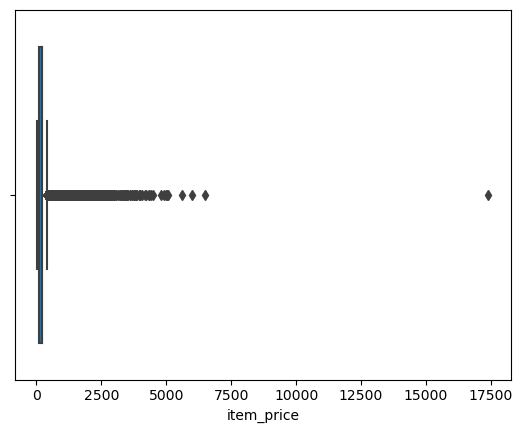

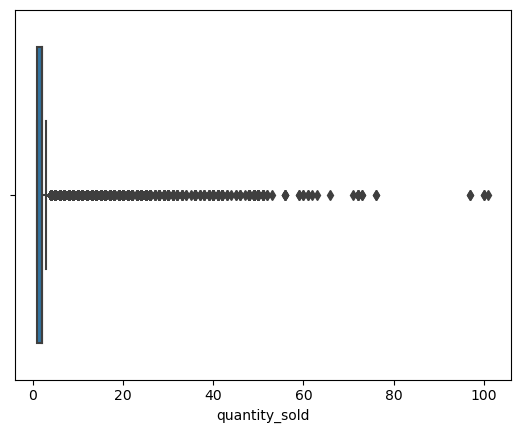

In [54]:
sns.boxplot(x='item_price', data=df)
plt.show()

sns.boxplot(x='quantity_sold', data=df)
plt.show()

In [55]:
df2 = df[df['item_price']>=2000]
df2

item_description          transaction_date  shop_id  \
2762       STRAWBERRY MILK 180ML  2021-12-08T00:00:00.000Z  SHOP070   
6609             TONIC PET 500ML  2021-12-03T00:00:00.000Z  SHOP046   
10831          GINGER BEER 500ML  2021-10-16T00:00:00.000Z  SHOP126   
10836   DRY GINGER ALE PET 500ML  2021-10-16T00:00:00.000Z  SHOP126   
11271       FIT O MIXED FRUIT 1L  2021-10-16T00:00:00.000Z  SHOP111   
...                          ...                       ...      ...   
467944                       N/A  2021-10-31T00:00:00.000Z  SHOP054   
470159     STRAWBERRY MILK 180ML  2021-12-15T00:00:00.000Z  SHOP018   
470863                       N/A  2021-12-09T00:00:00.000Z  SHOP022   
473033                       N/A  2021-12-14T00:00:00.000Z  SHOP118   
473718           FIT O ORANGE 1L  2021-12-12T00:00:00.000Z  SHOP018   

        item_price  quantity_sold  
2762          2100             30  
6609          2720             17  
10831         2500             26  
10836         2400             15  
11271         2700             11  
...            ...            ...  
467944        2100             30  
470159        2450             36  
470863        2450             36  
473033        2800             40  
473718        2320              8  

[265 rows x 5 columns]

<br>These plots gives the number of the occurrences for the each price per beverage.

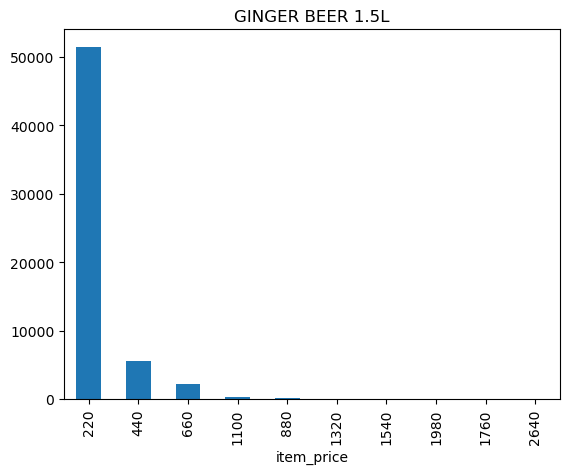

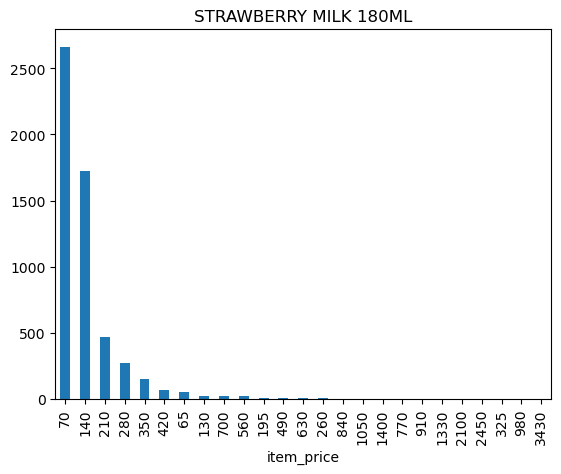

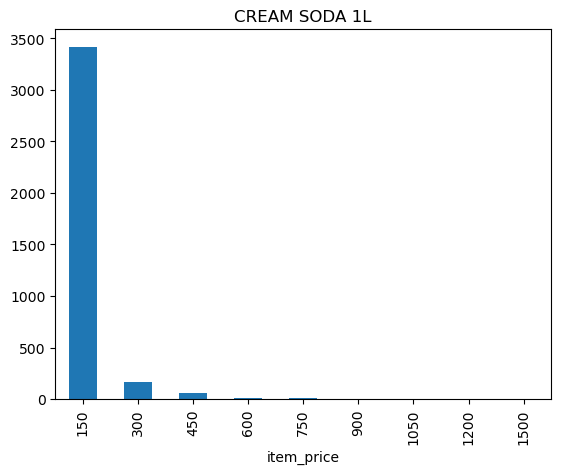

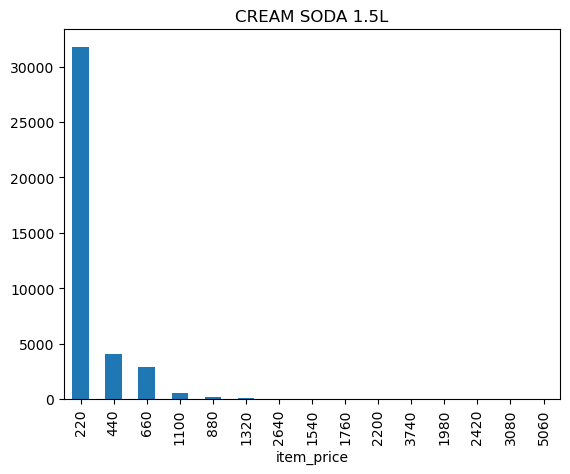

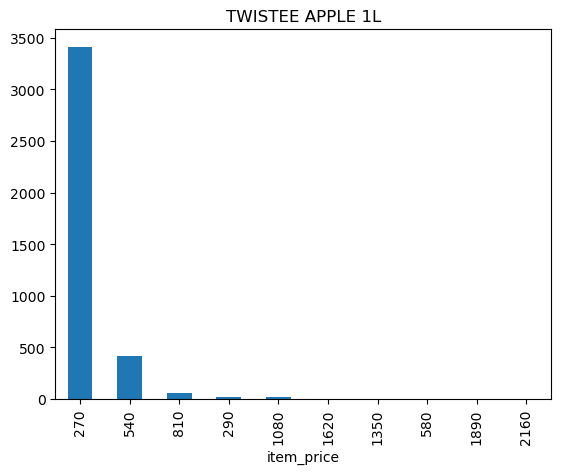

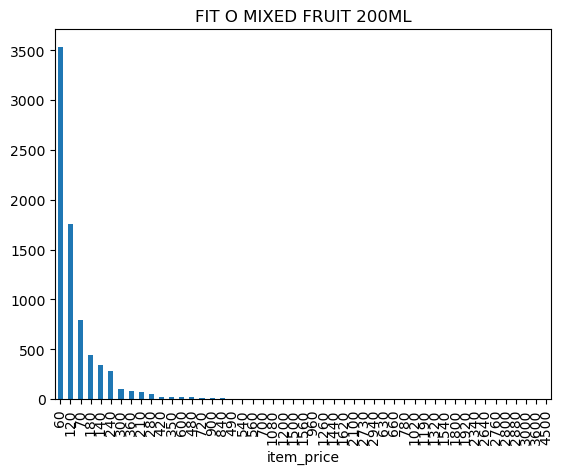

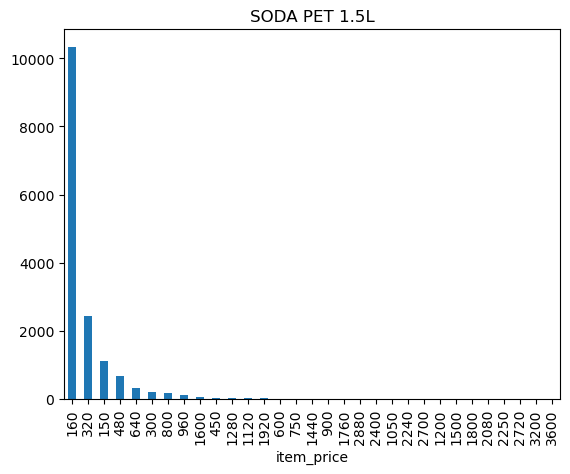

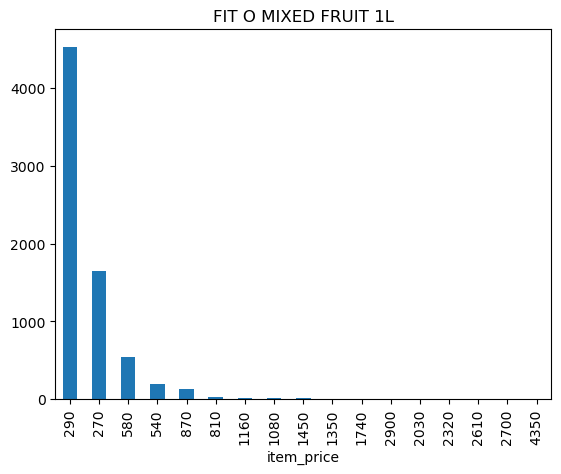

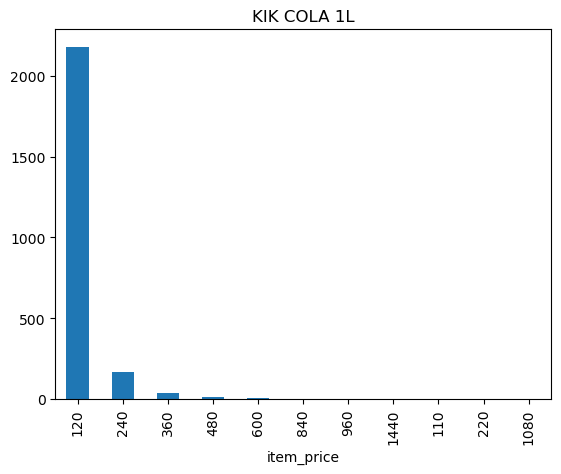

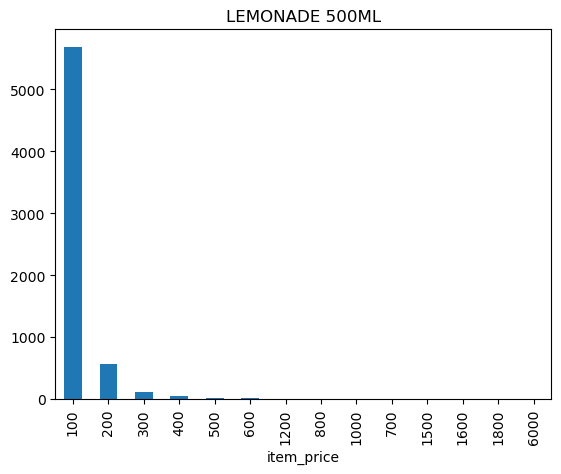

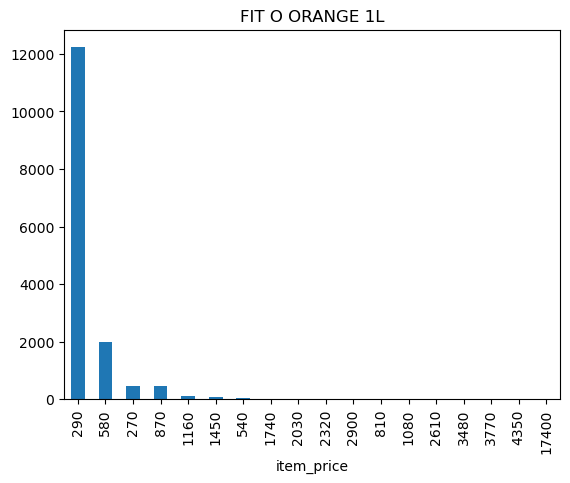

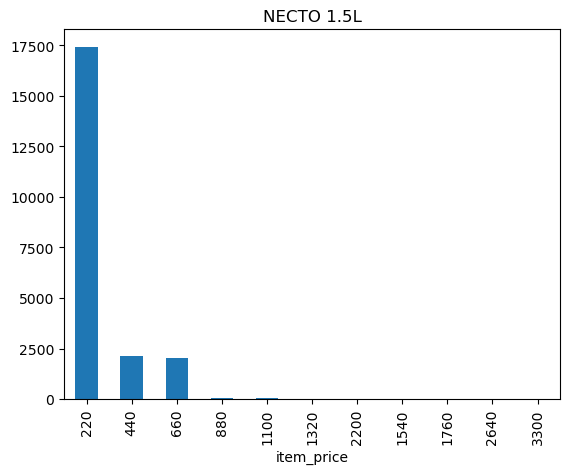

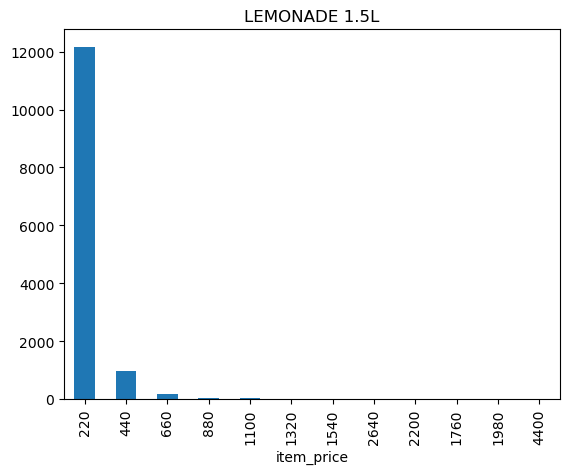

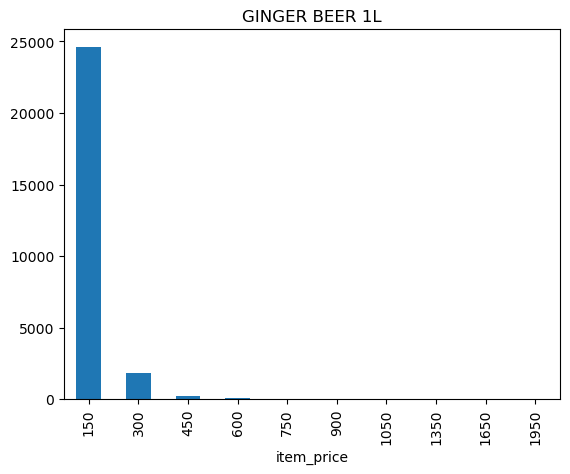

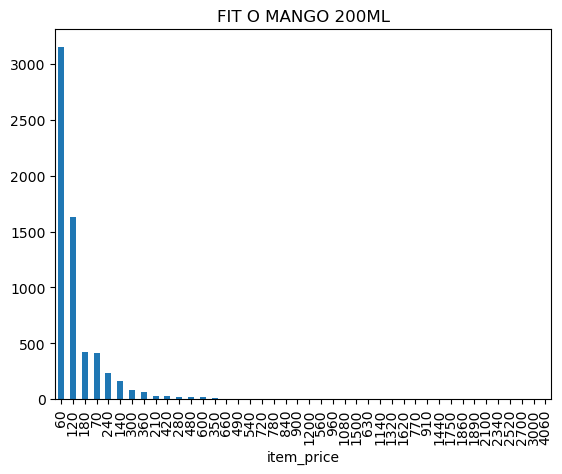

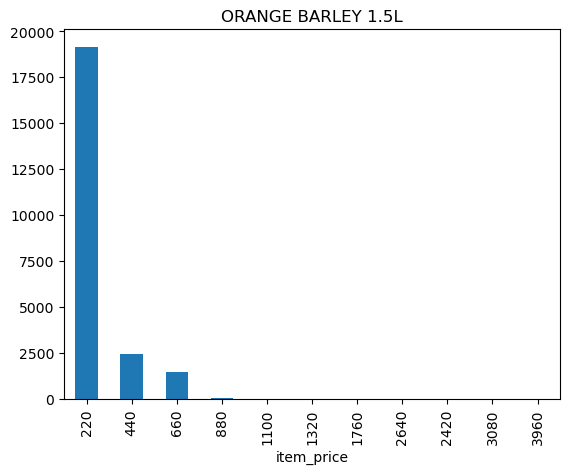

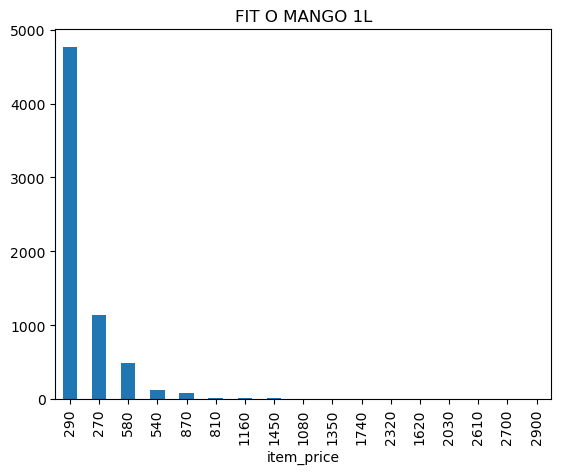

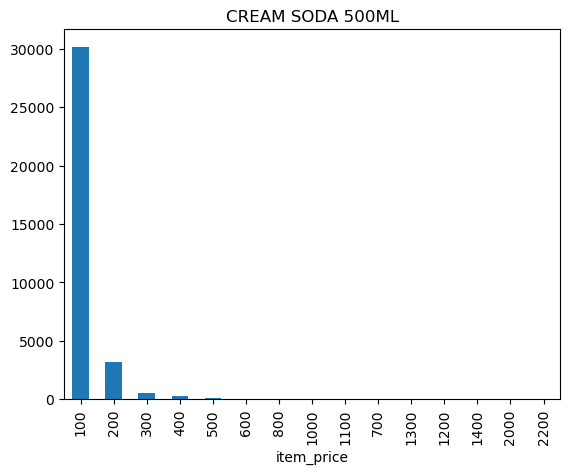

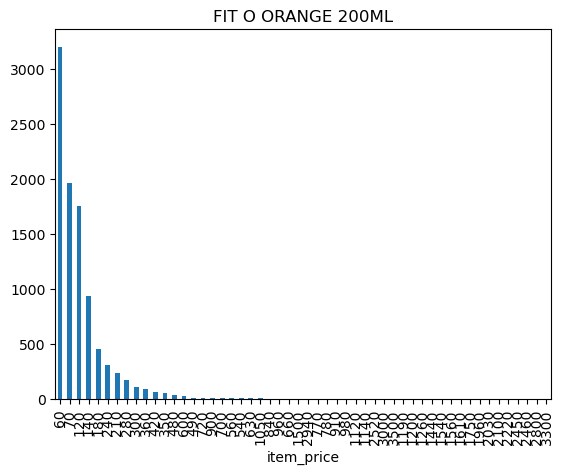

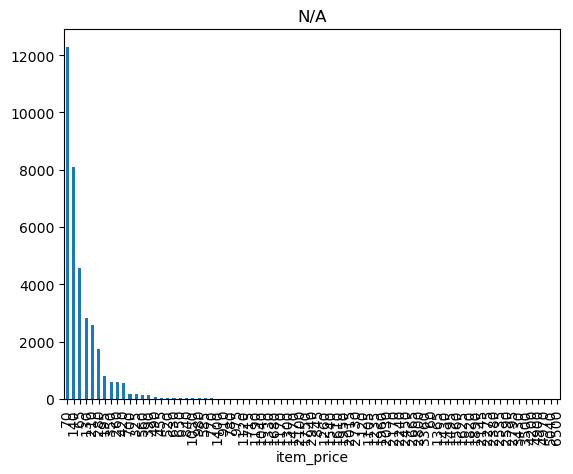

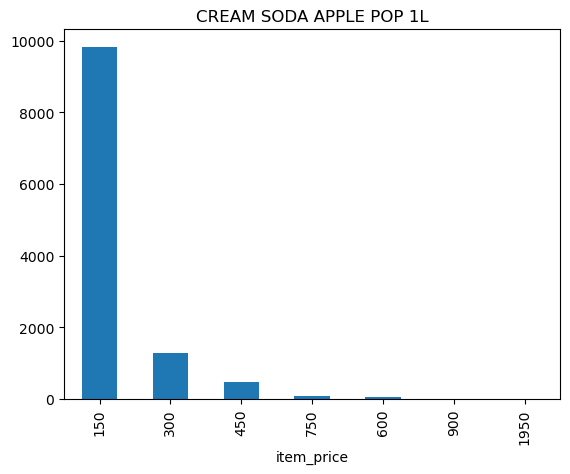

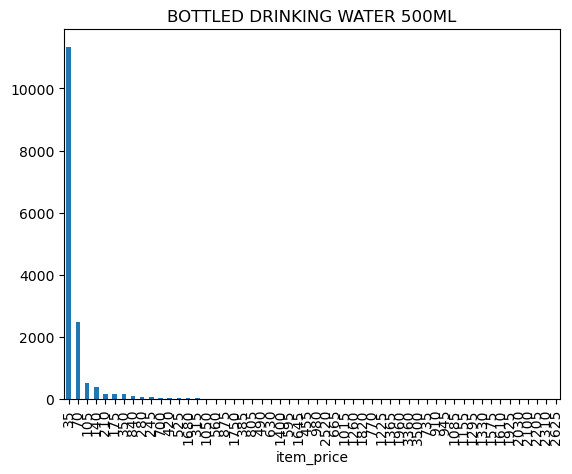

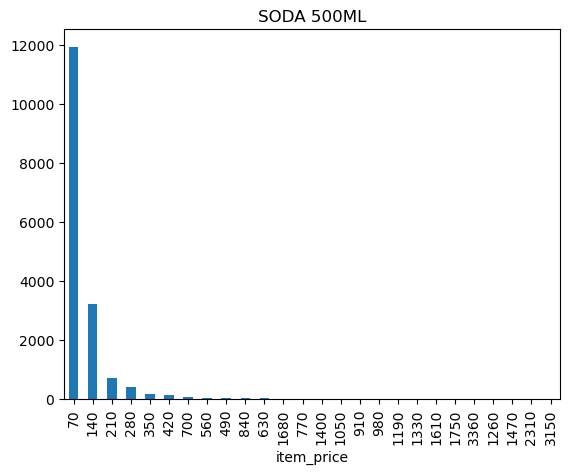

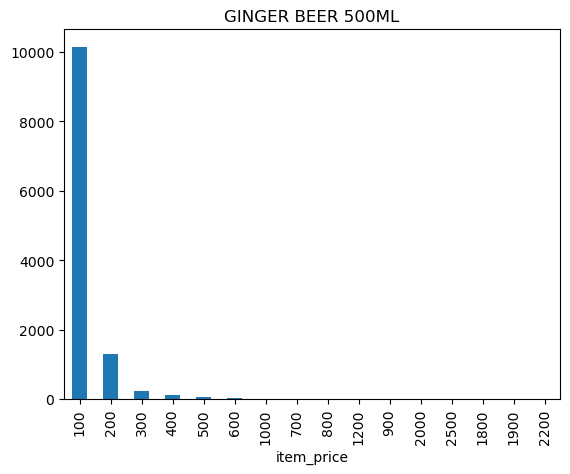

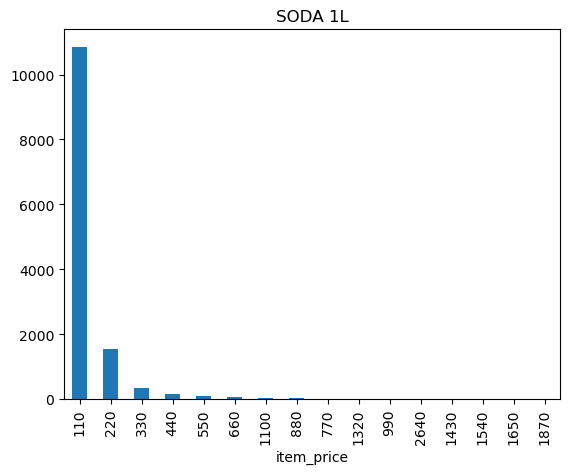

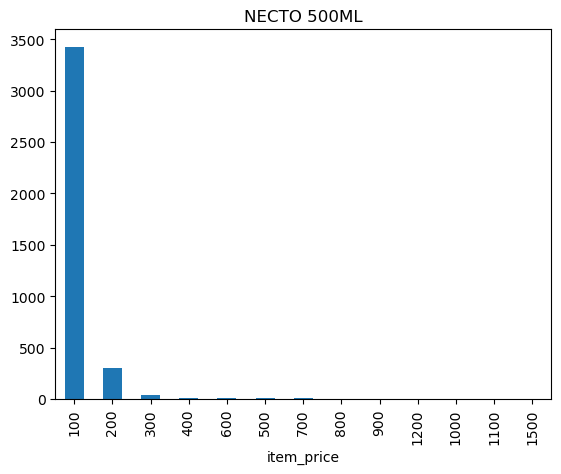

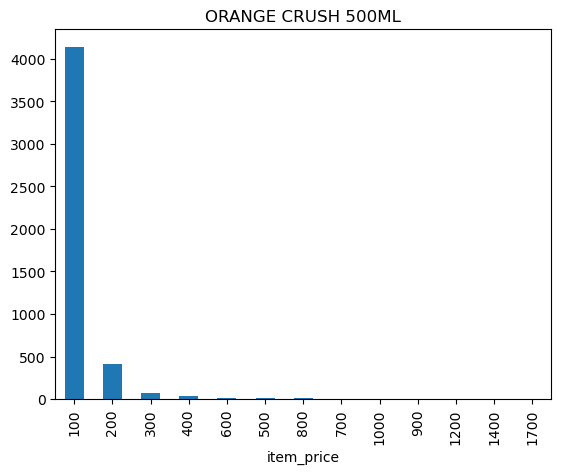

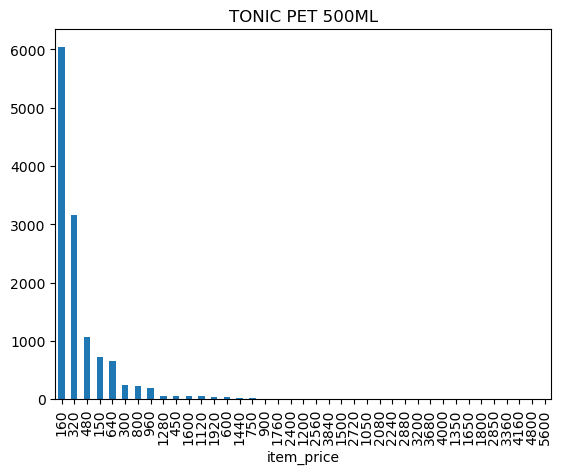

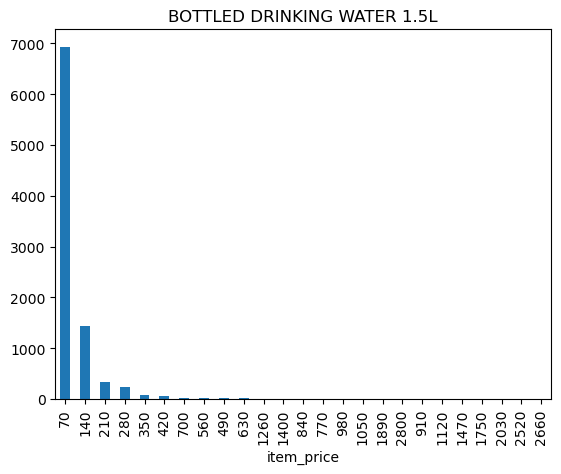

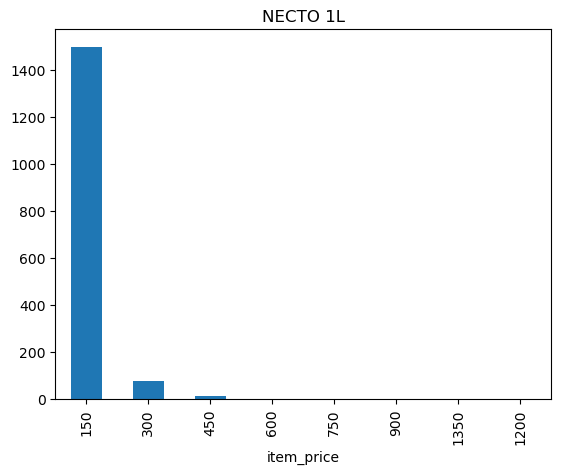

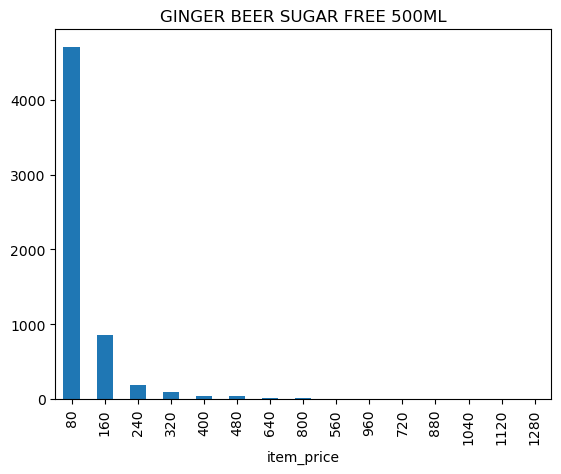

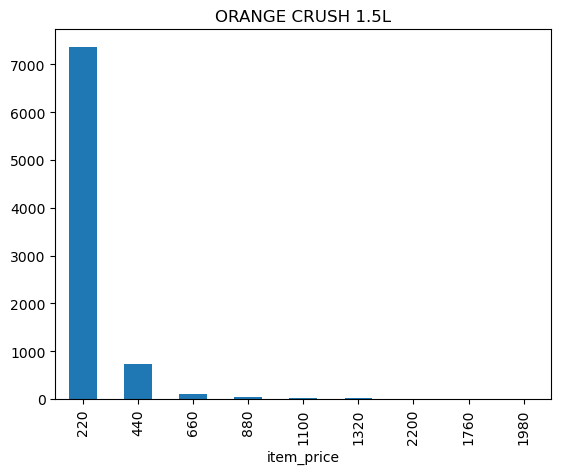

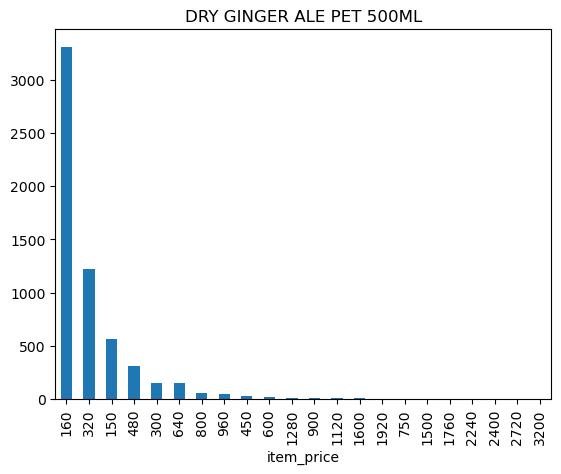

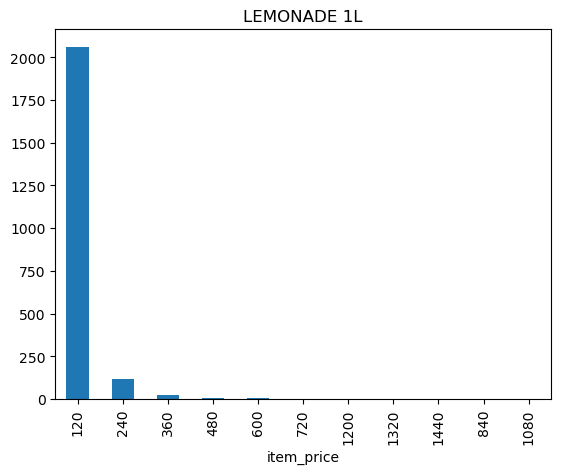

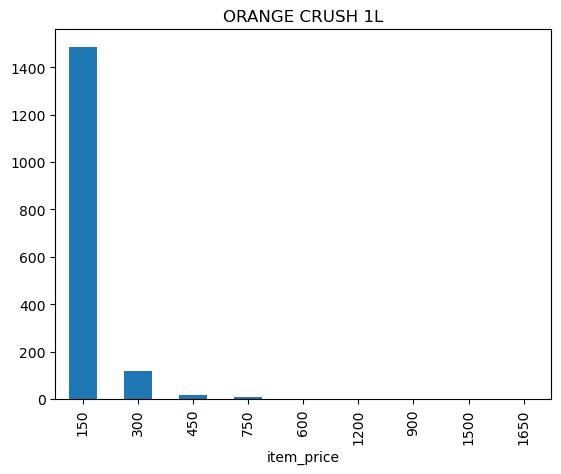

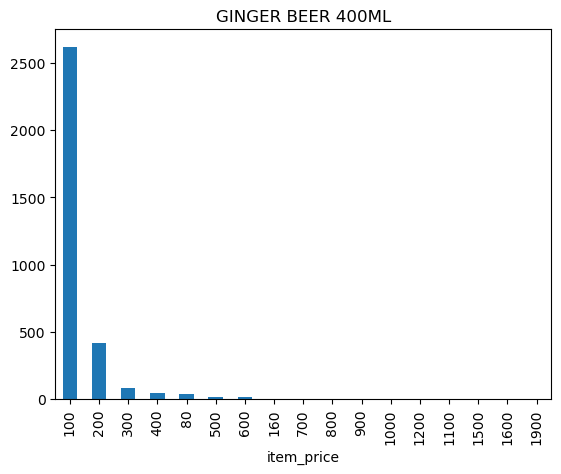

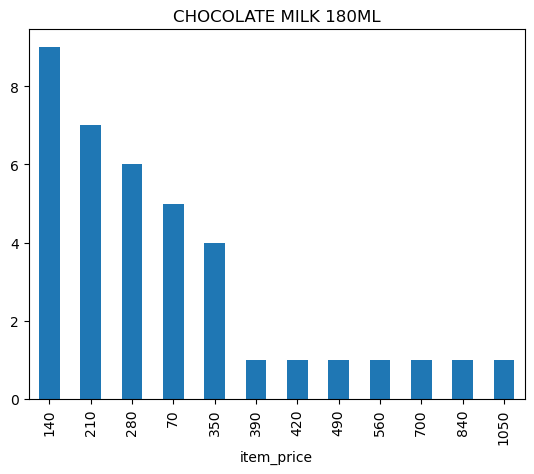

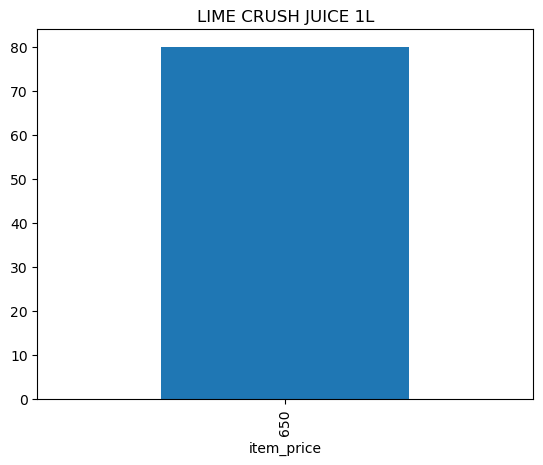

In [56]:
# Filter out any rows with null values in the "item_description" or "item_price" columns
df2 = df.dropna(subset=['item_description', 'item_price'])

# Group the DataFrame by the "item_description" column and calculate the count of each price using the groupby and value_counts methods
counts = df2.groupby('item_description')['item_price'].value_counts()

# Iterate over the unique items in the DataFrame and plot a bar graph for each item using the plot method
for item in df2['item_description'].unique():
    if item is not None:
        counts[item].plot(kind='bar', title=item)
        plt.show()

<br>The following function gives the plot for the each beverage, prices of that beverage for the each week. this would be benifitiol if there are seasonal price canges are present.

In [57]:
def weekly_prices(items):
    for item in items:
        df_item = df[df['item_description'] == item].copy()  # create a copy of the filtered DataFrame
        df_item.loc[:, 'transaction_date'] = pd.to_datetime(df_item['transaction_date'])  # use .loc to set the values

        date_range = pd.date_range(start='2021-10-15', end='2021-12-15', freq='W')

        # create a new column with the week number of each row
        df_item['week_number'] = df_item['transaction_date'].dt.isocalendar().week  # use .isocalendar().week instead of .week

        # group the dataframe by shop and week number, and sum the item prices
        grouped = df_item.groupby(['week_number'])['item_price'].value_counts().unstack()

        # normalize the dataframe
        grouped = grouped.div(grouped.sum(axis=1), axis=0)

        # create a stacked bar plot
        ax = grouped.plot(kind='bar', stacked=True,figsize=(50,10))

        # set the x-label and y-label
        ax.set_xlabel('Week')
        ax.set_ylabel('Item Price')
        ax.set_title(item)

        # set the tick labels of the x-axis to the week number of each row
        ax.set_xticklabels(grouped.index, rotation=90)

        # show the plot
        plt.show()

<br>Following function visualize the relationship between quantity_sold column's value and the prices count for that quentity per each beverage. From this we can examine the correct idea of the item_price column. whether it represent the one item's price or a total price.

In [58]:
def item_count_prices(items):
  for item in items:
    df_item = df[df['item_description'] == item]

    # group the dataframe by shop and week number, and sum the item prices
    grouped = df_item.groupby(['quantity_sold'])['item_price'].value_counts().unstack()

    # normalize the dataframe
    grouped = grouped.div(grouped.sum(axis=1), axis=0)

    # create a stacked bar plot
    ax = grouped.plot(kind='bar', stacked=True,figsize=(50,10))

    # set the x-label and y-label
    ax.set_xlabel('quantity_sold')
    ax.set_ylabel('Item Price')
    ax.set_title(item)

    # set the tick labels of the x-axis to the week number of each row
    ax.set_xticklabels(grouped.index, rotation=90)

    # show the plot
    plt.show()

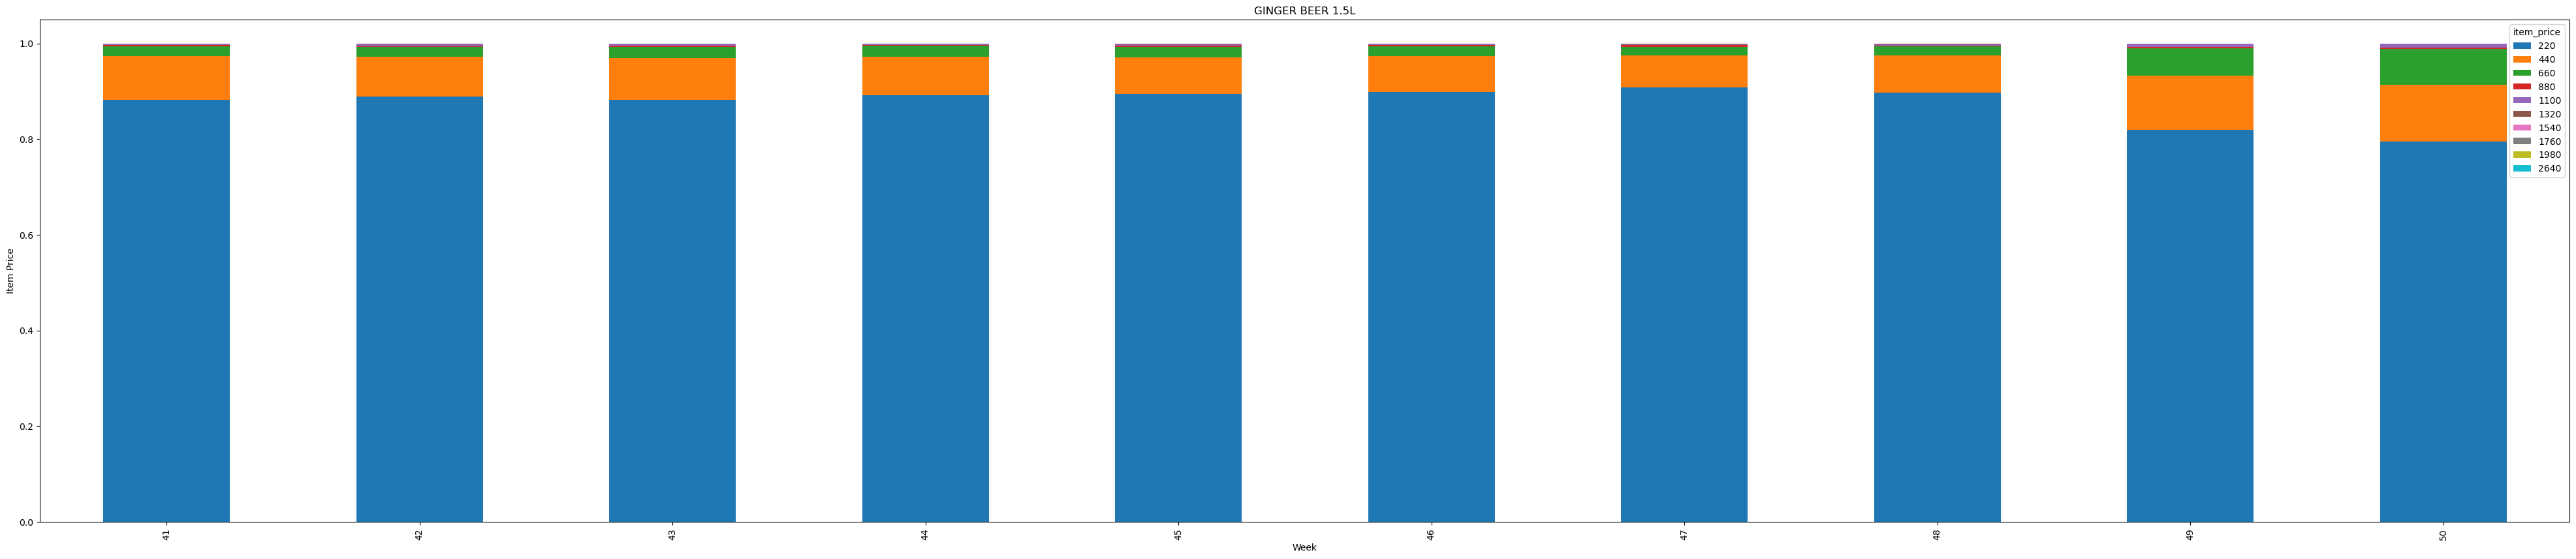

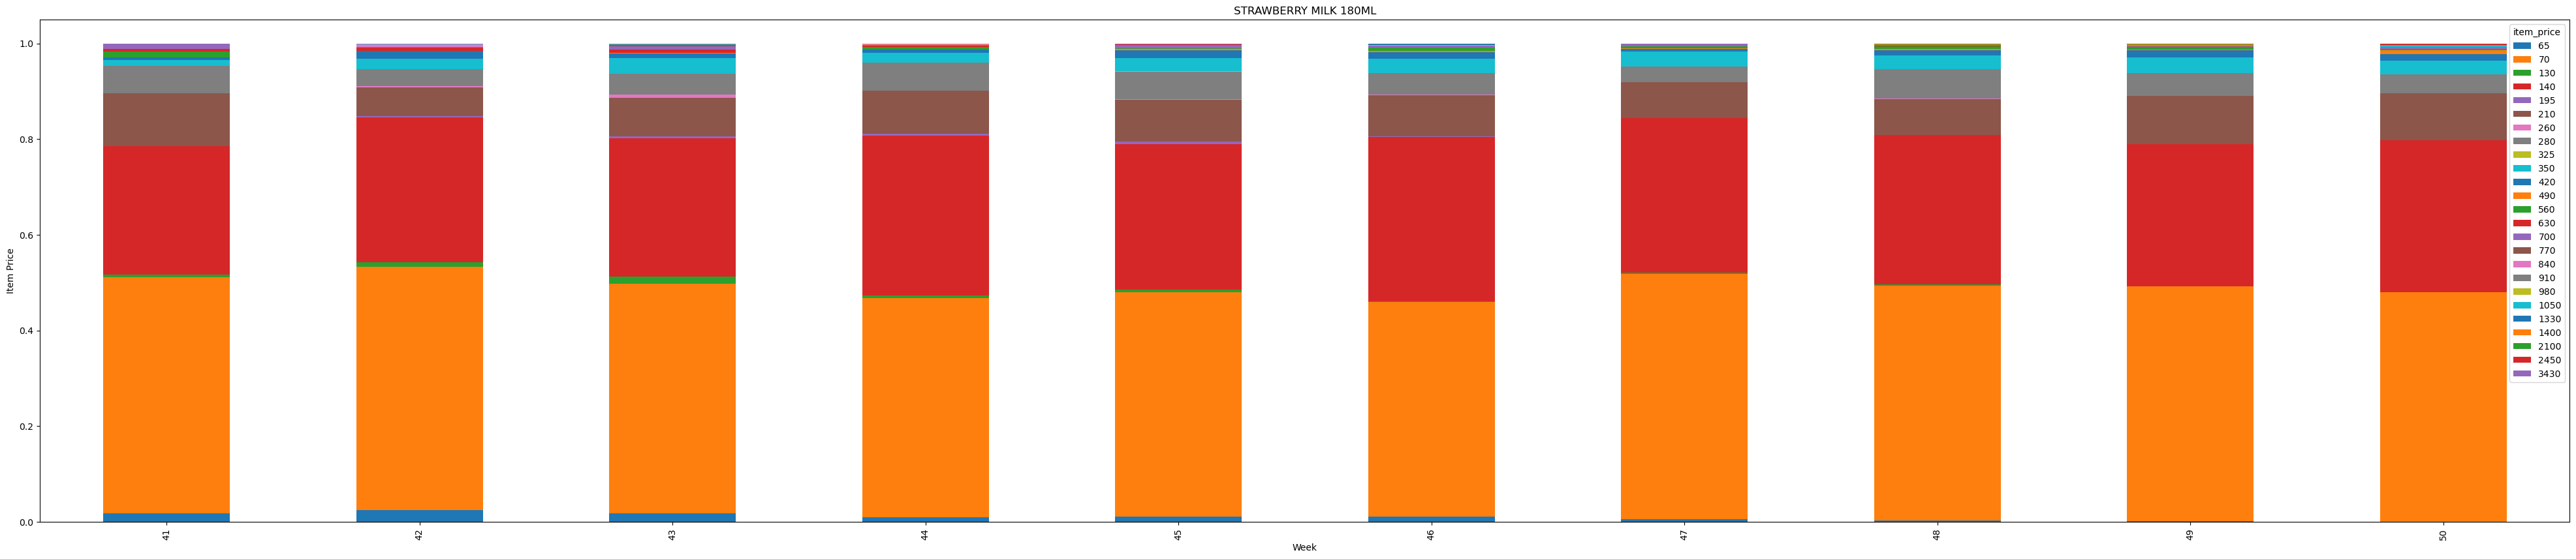

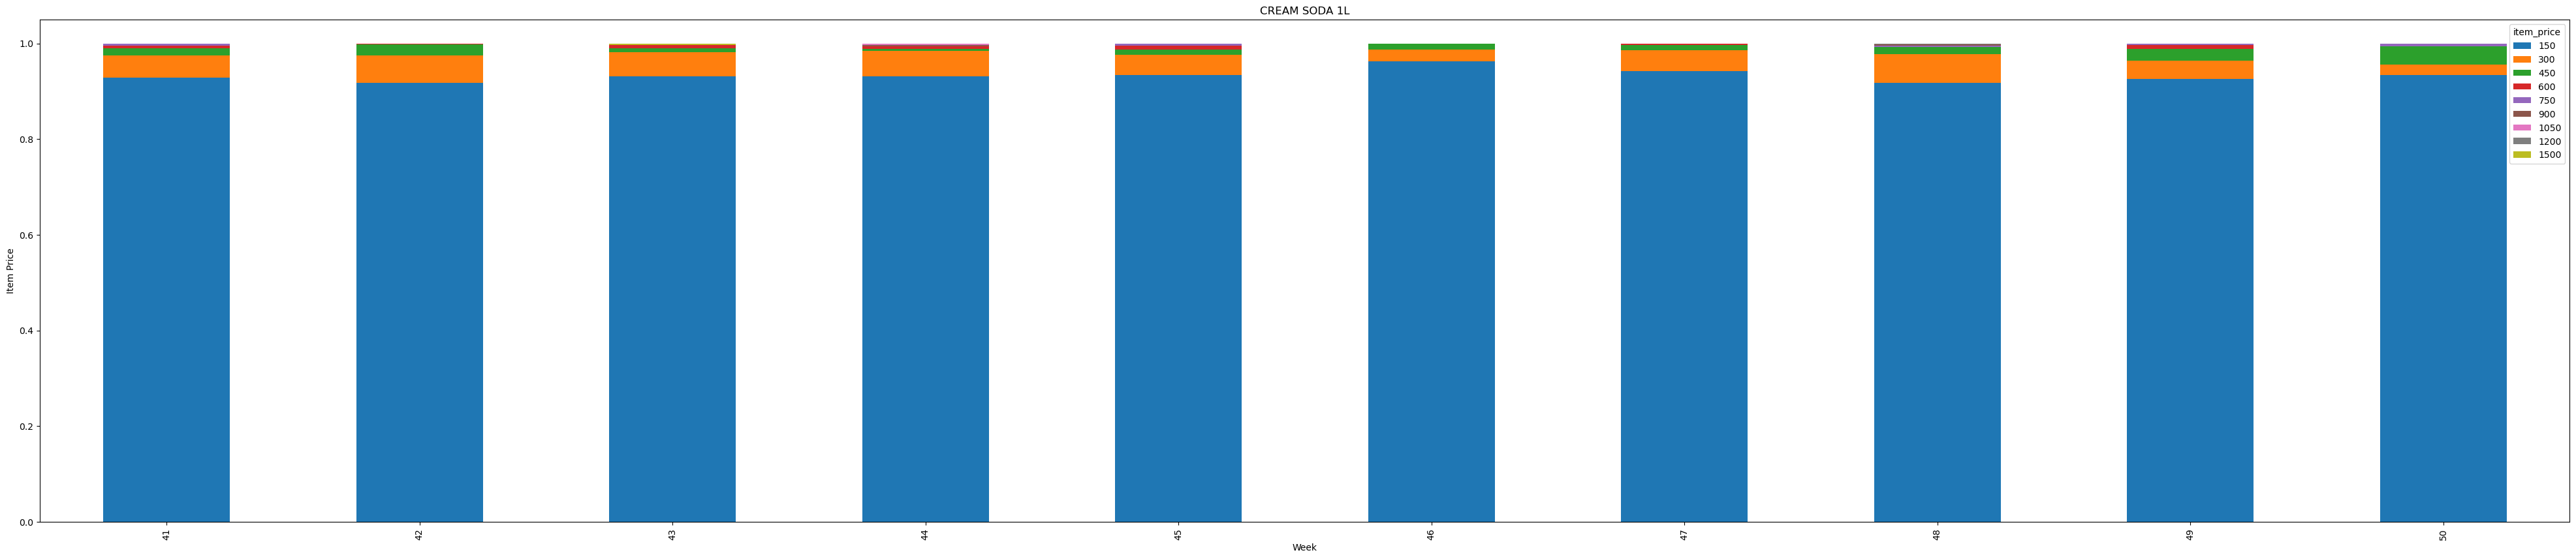

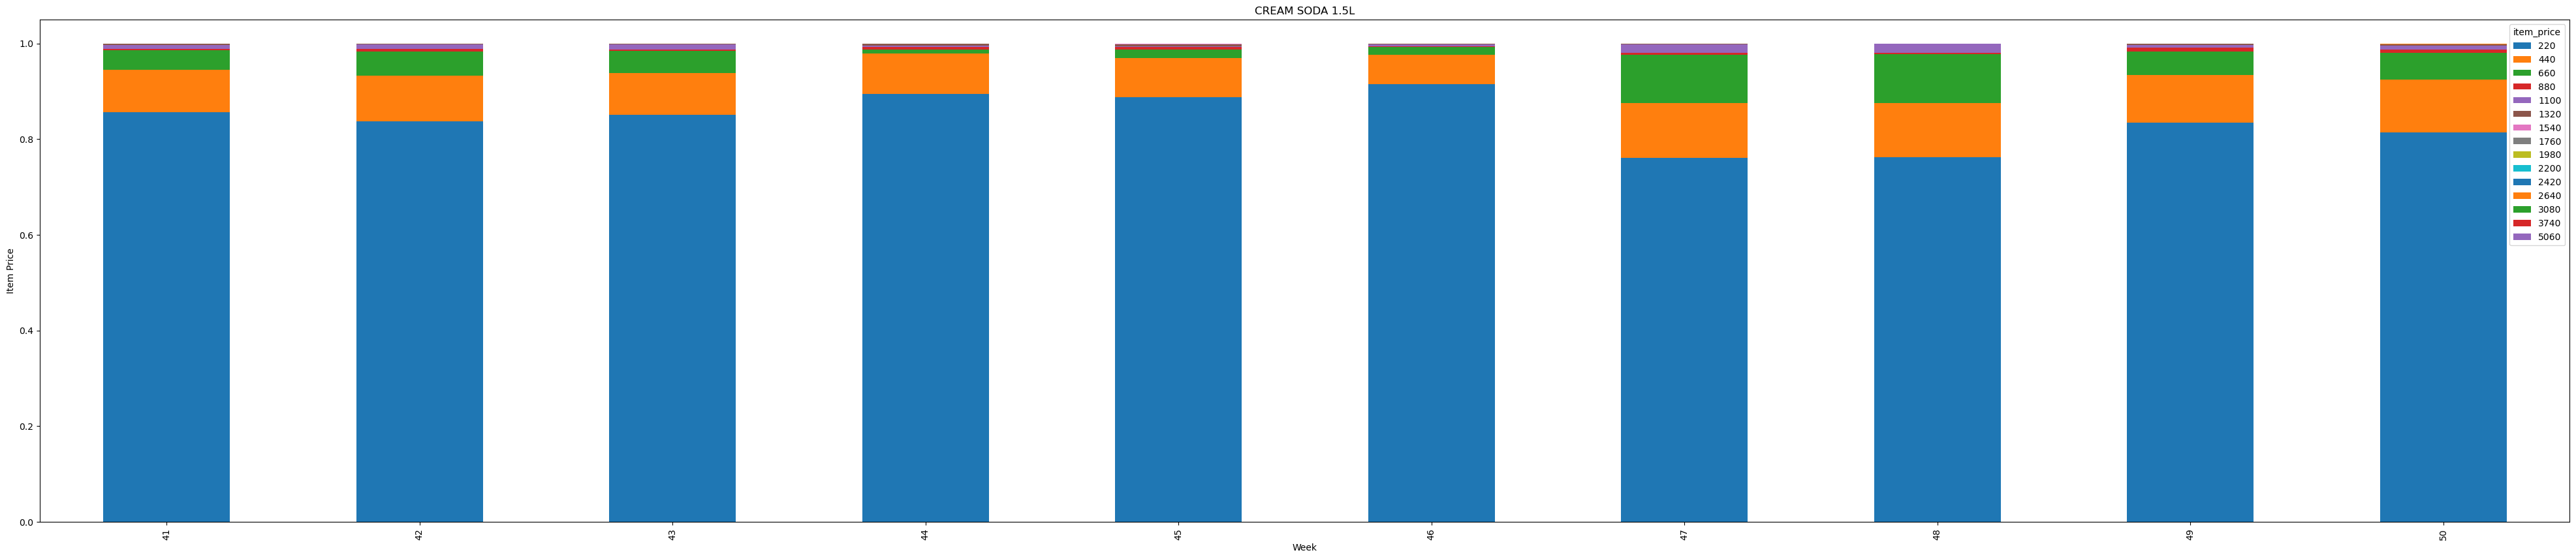

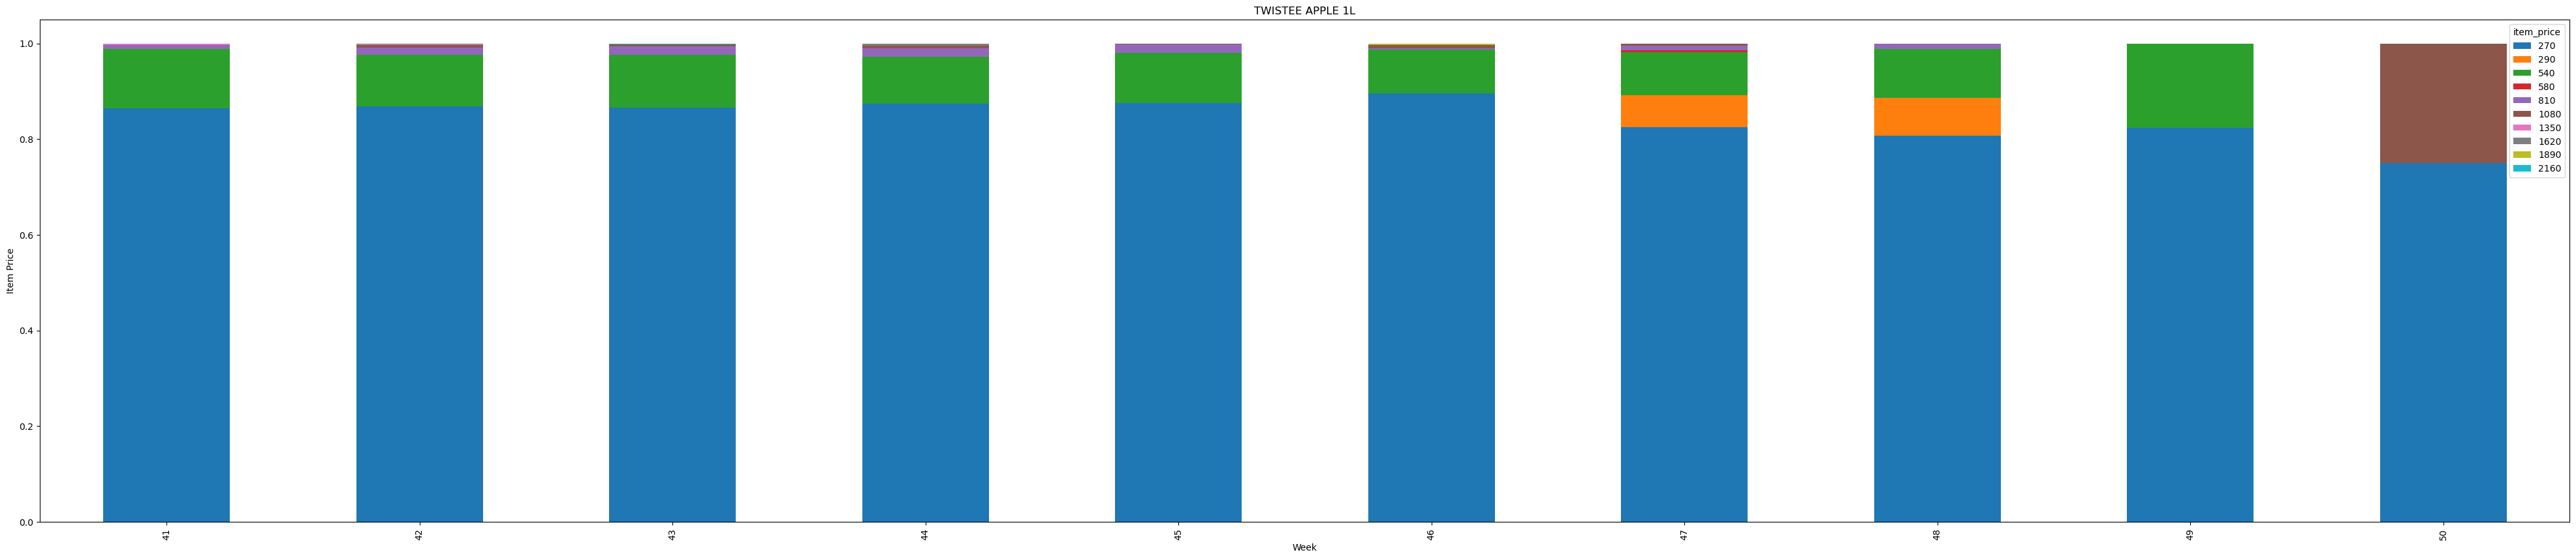

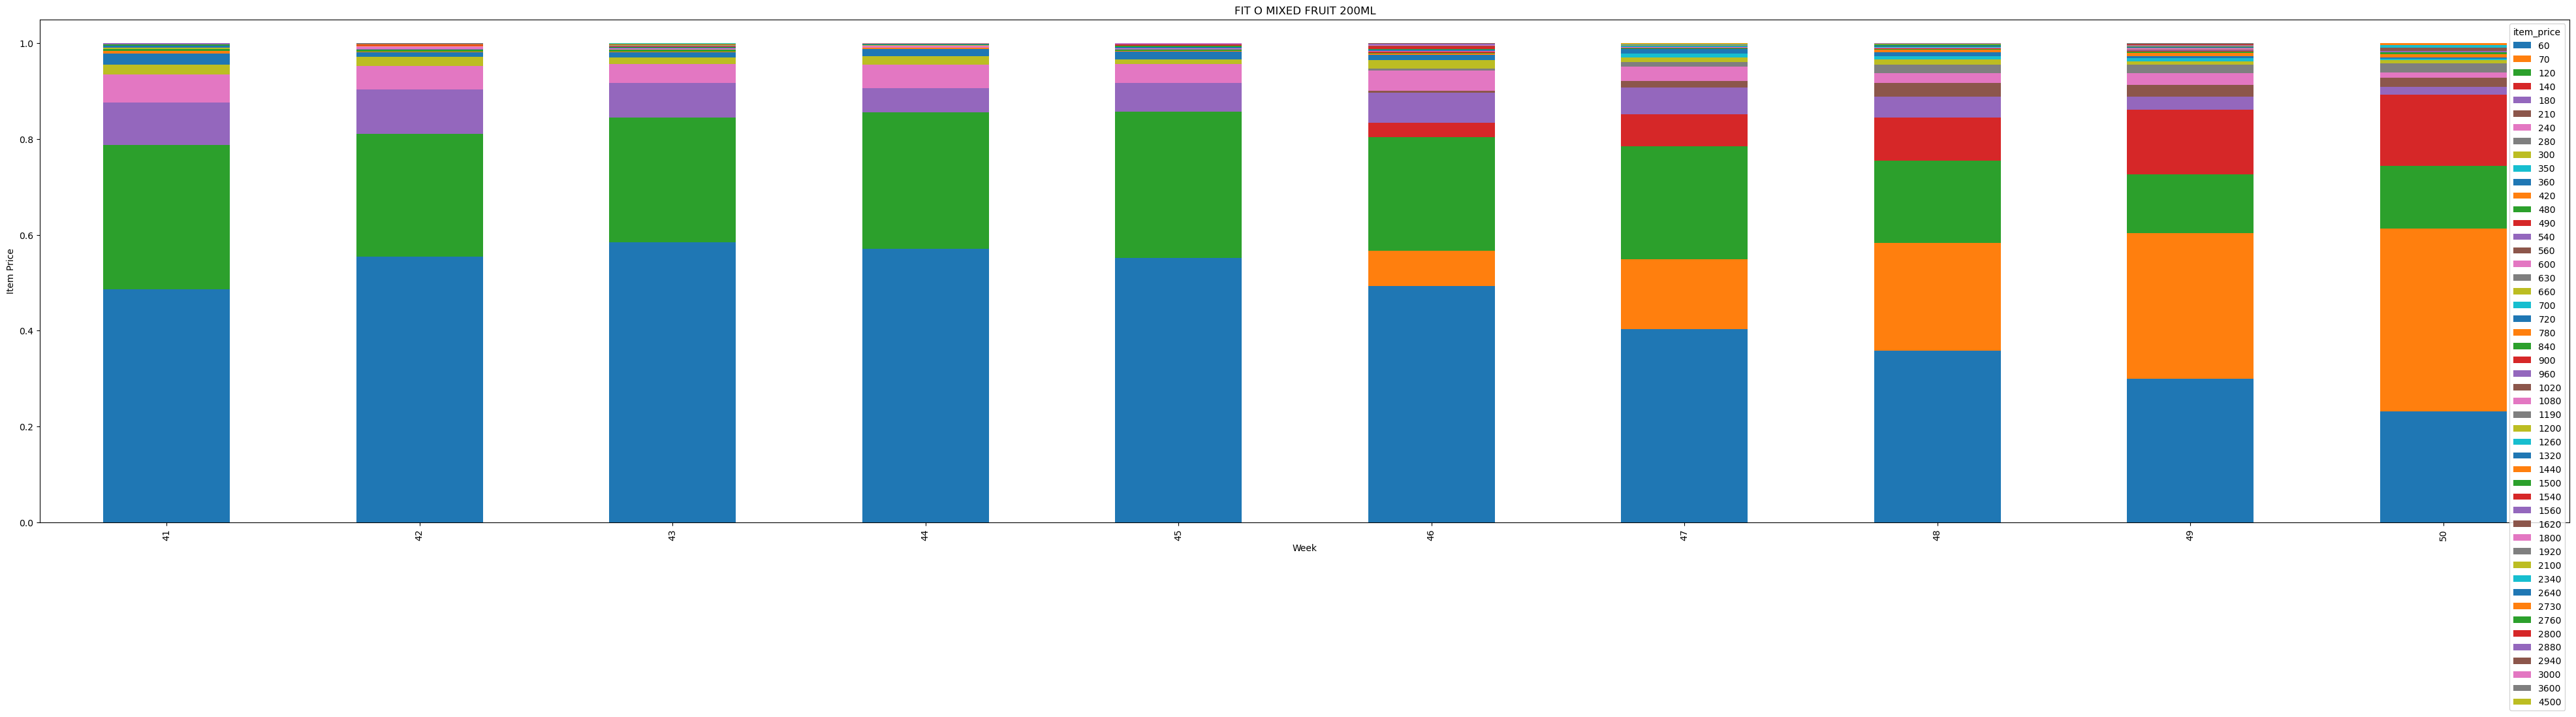

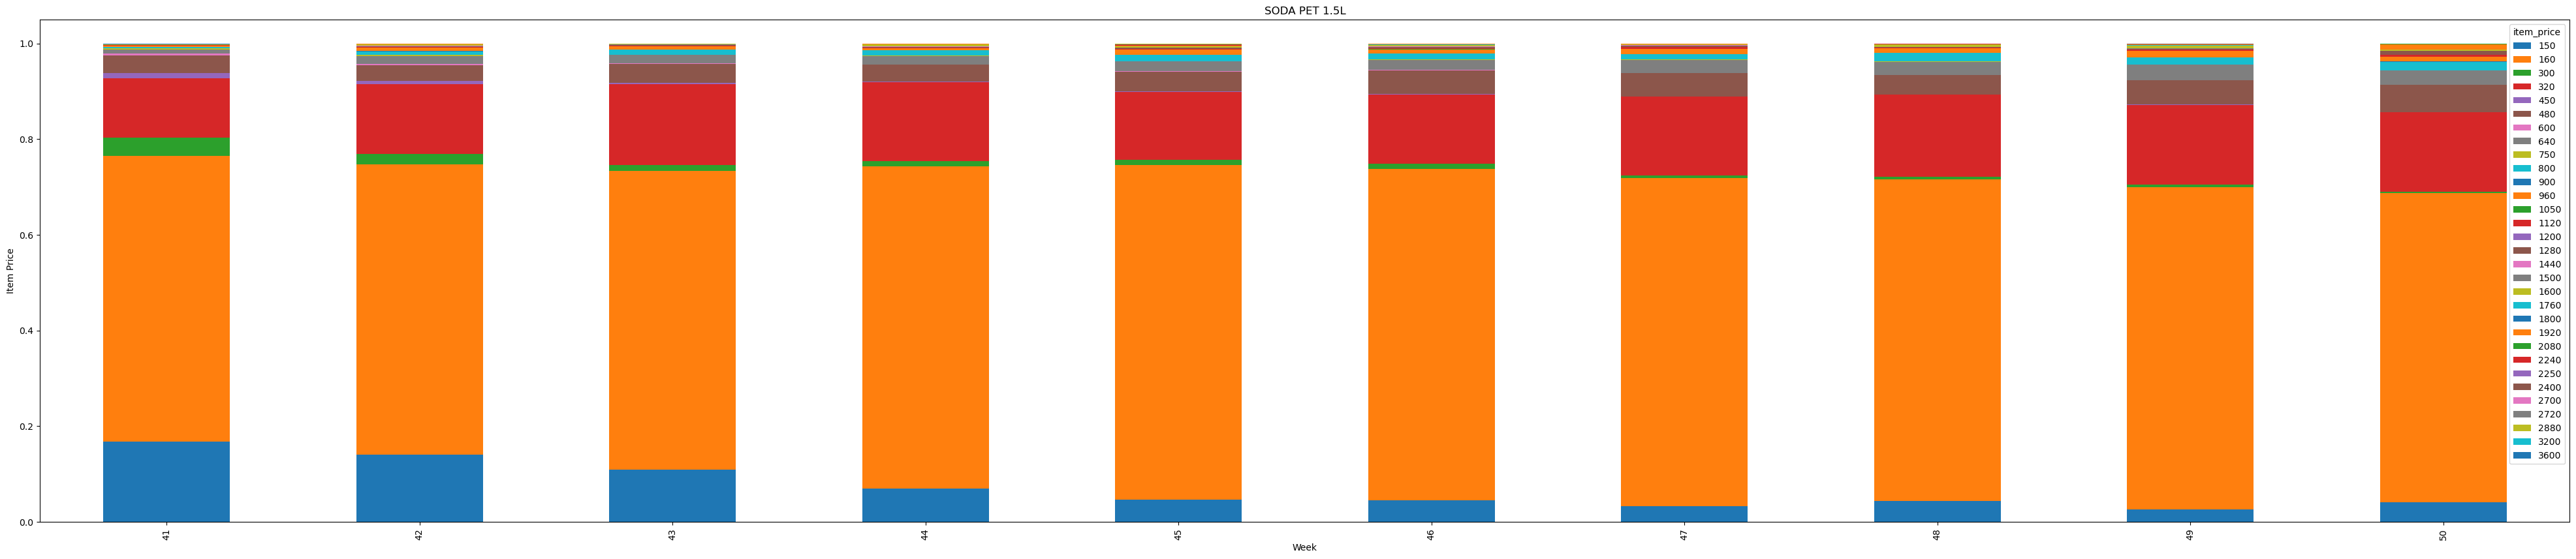

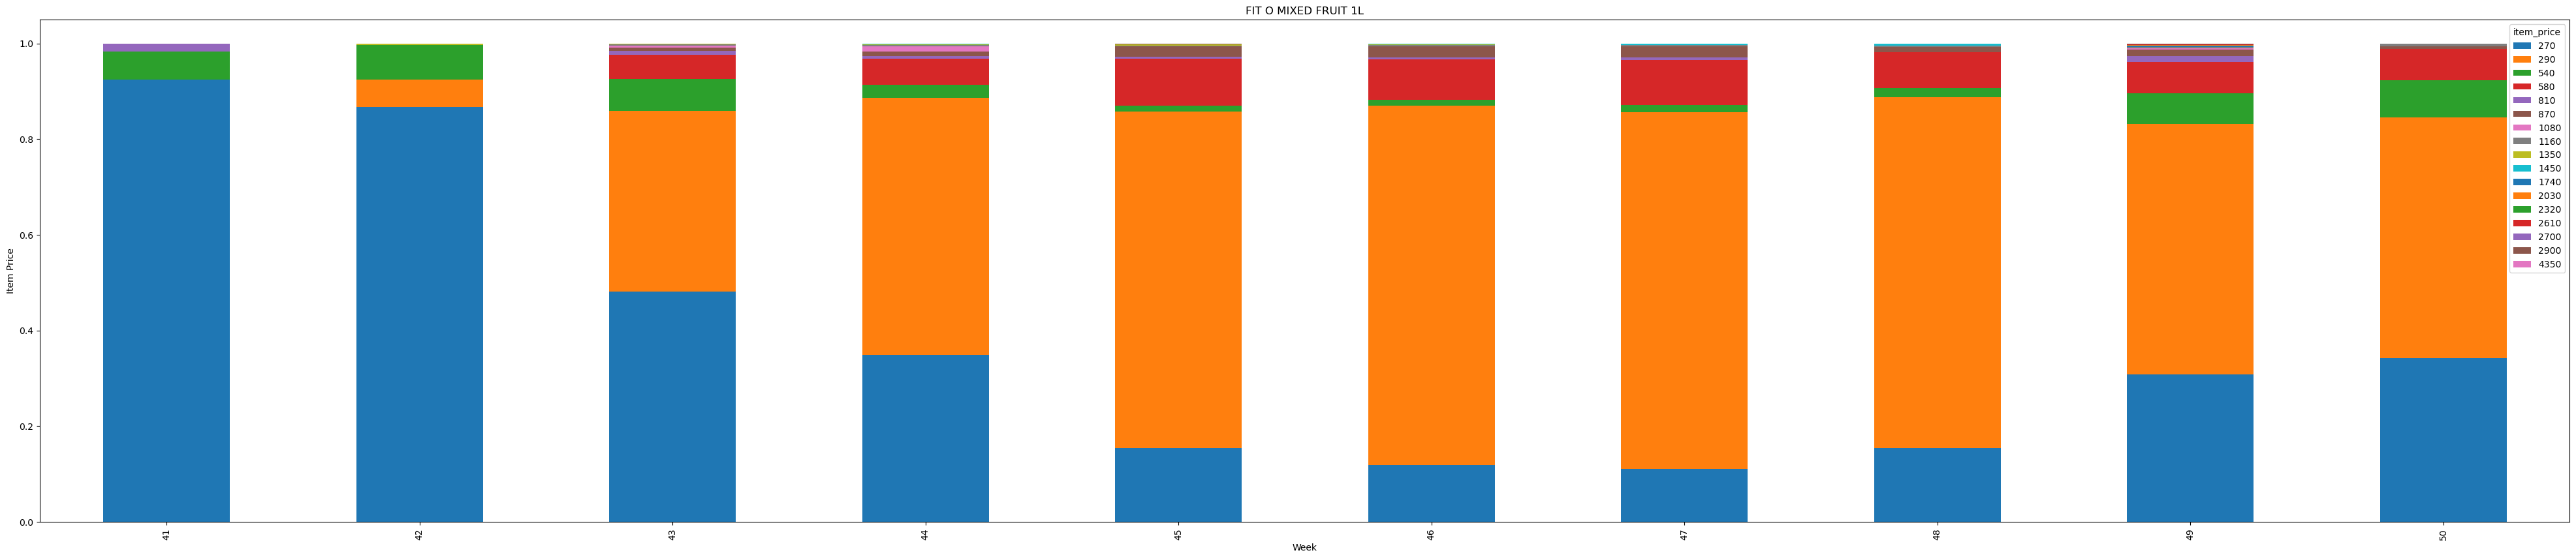

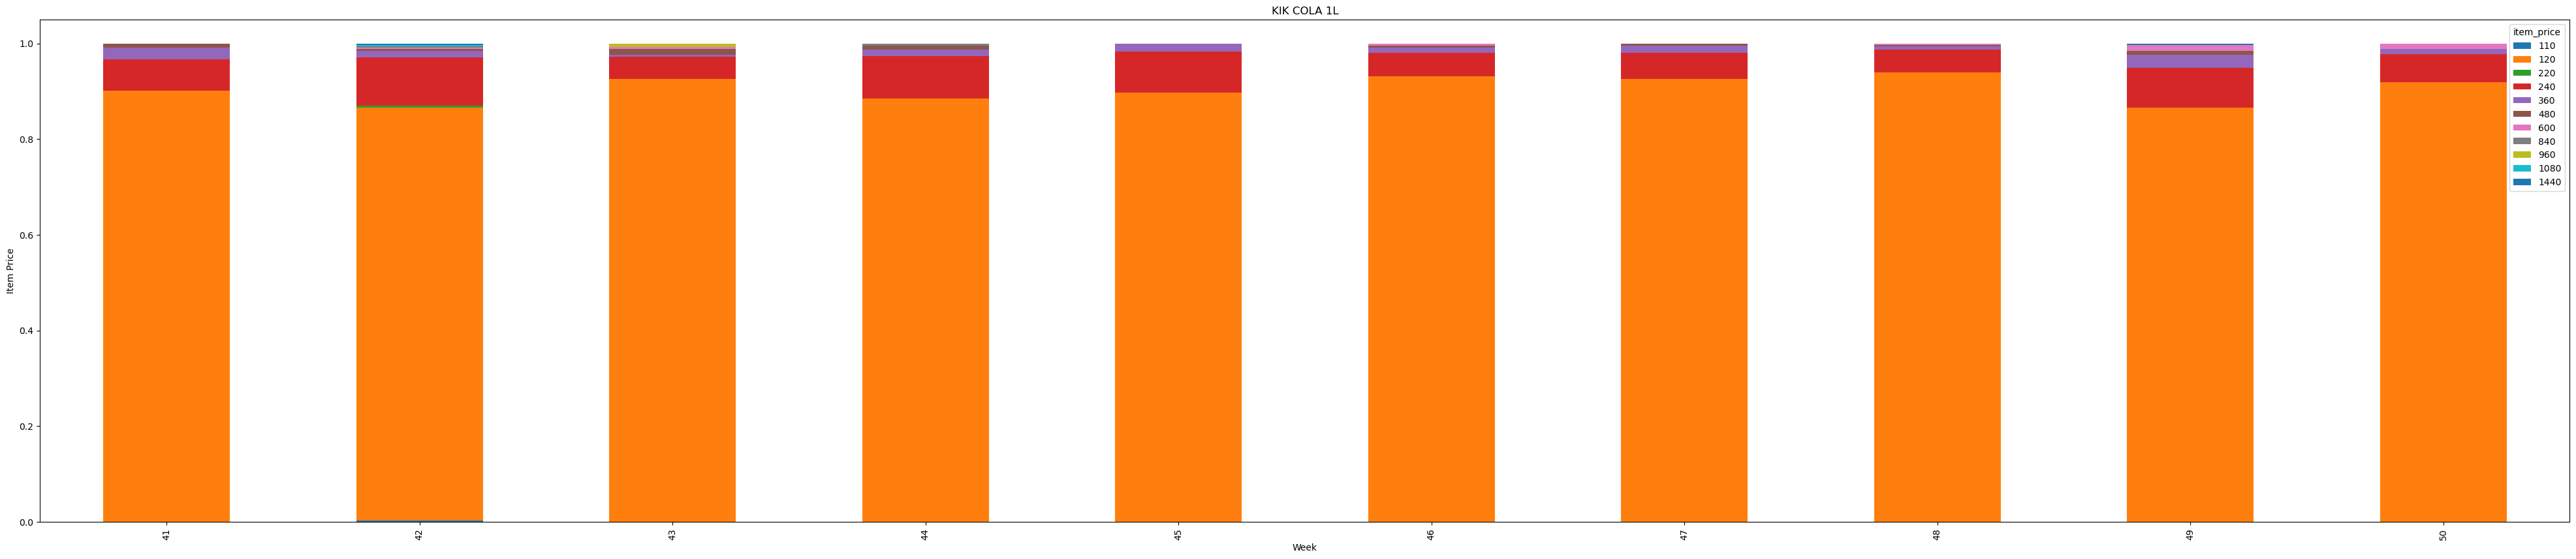

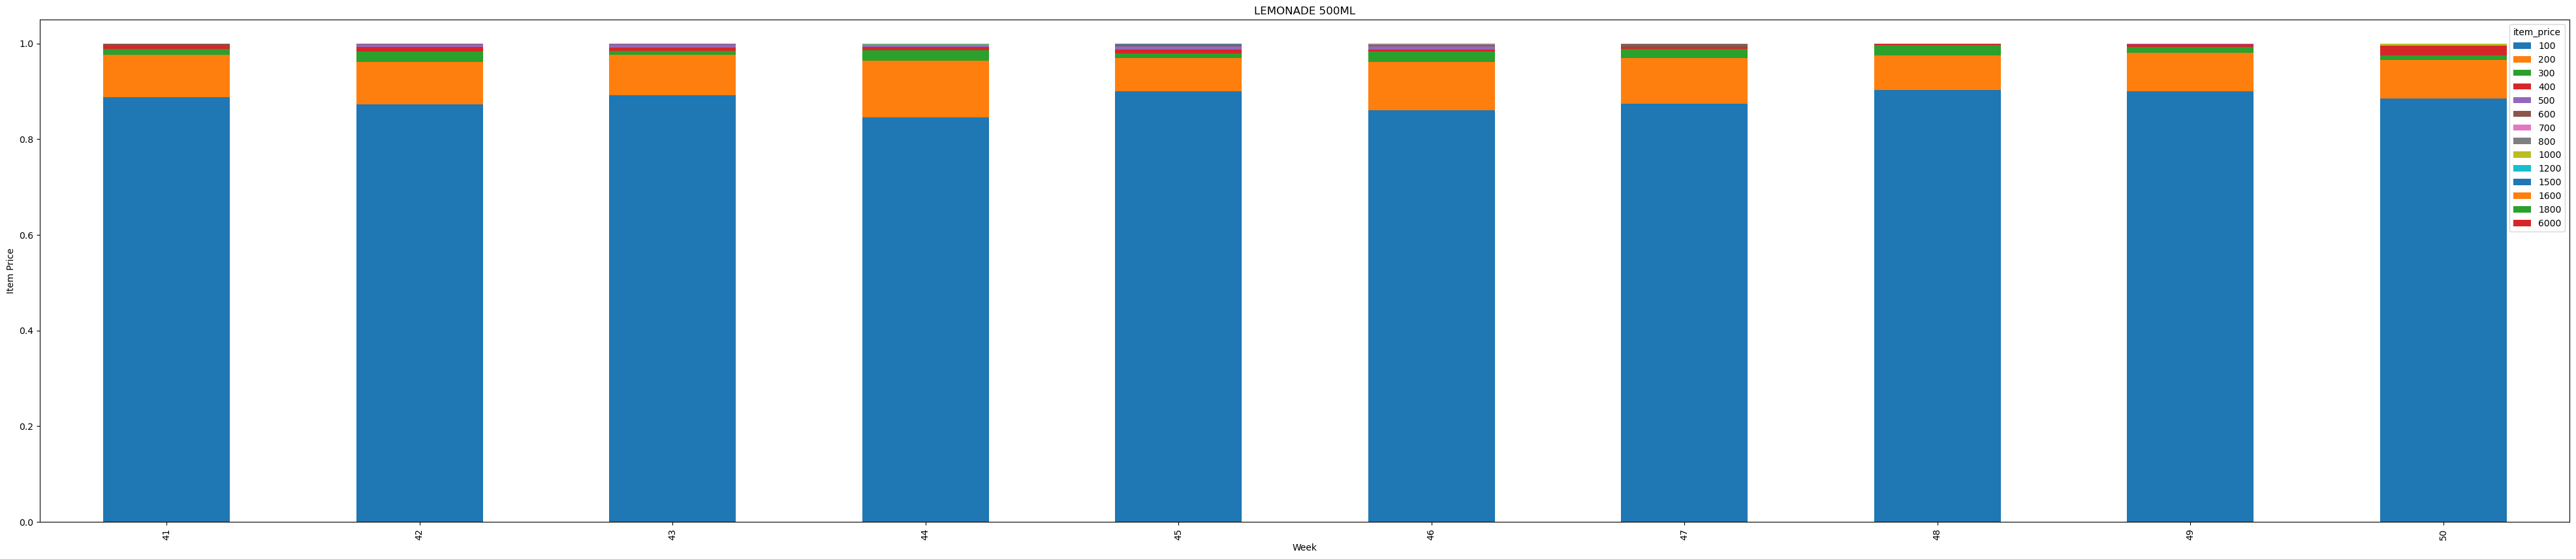

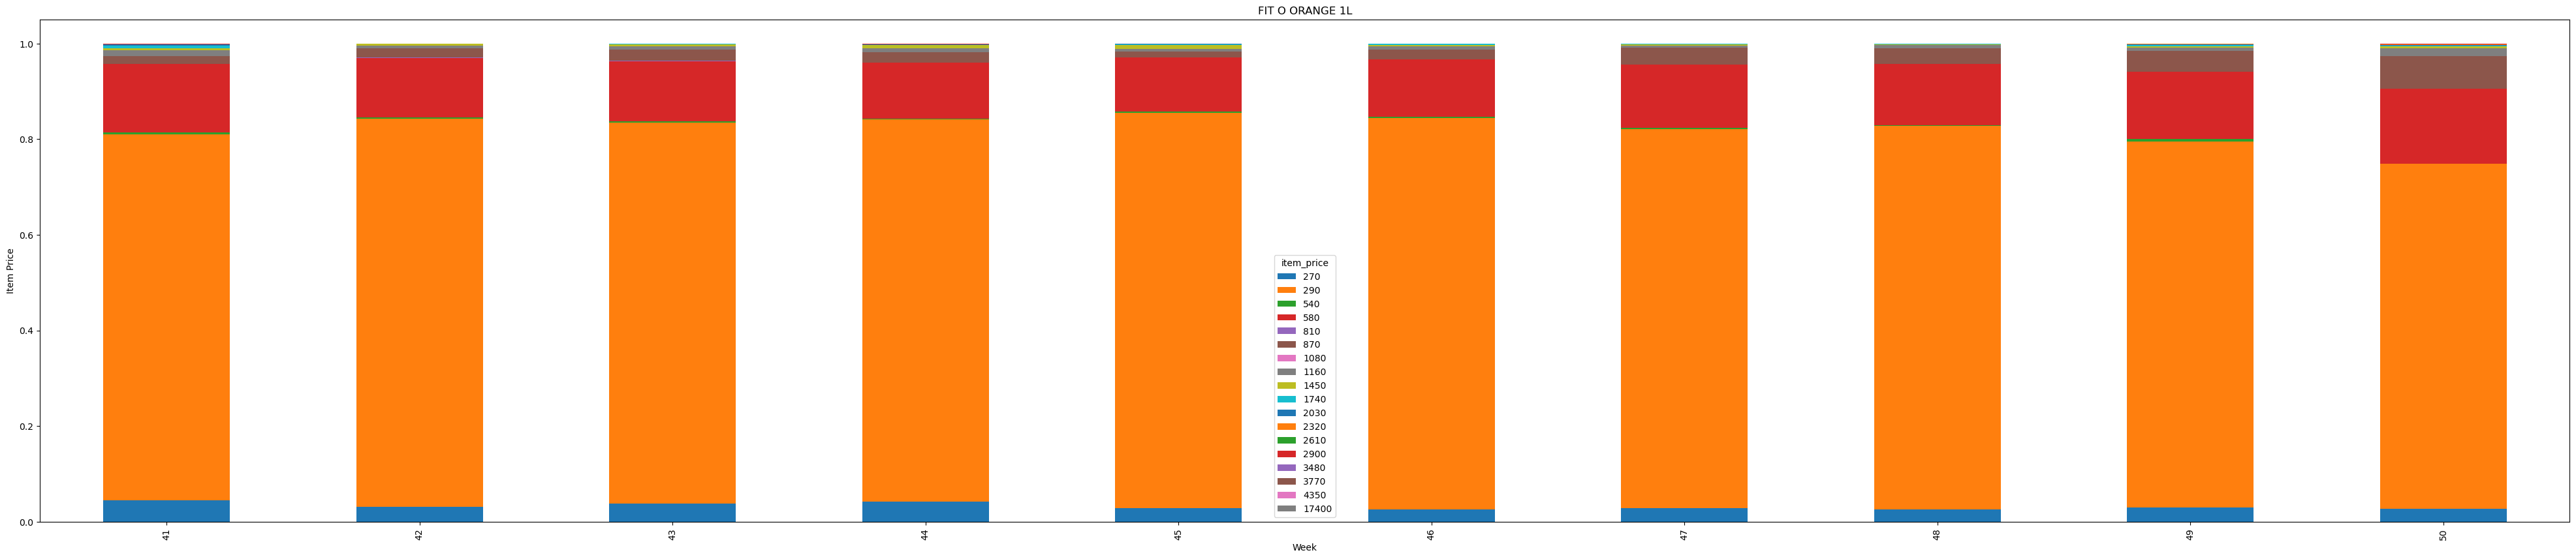

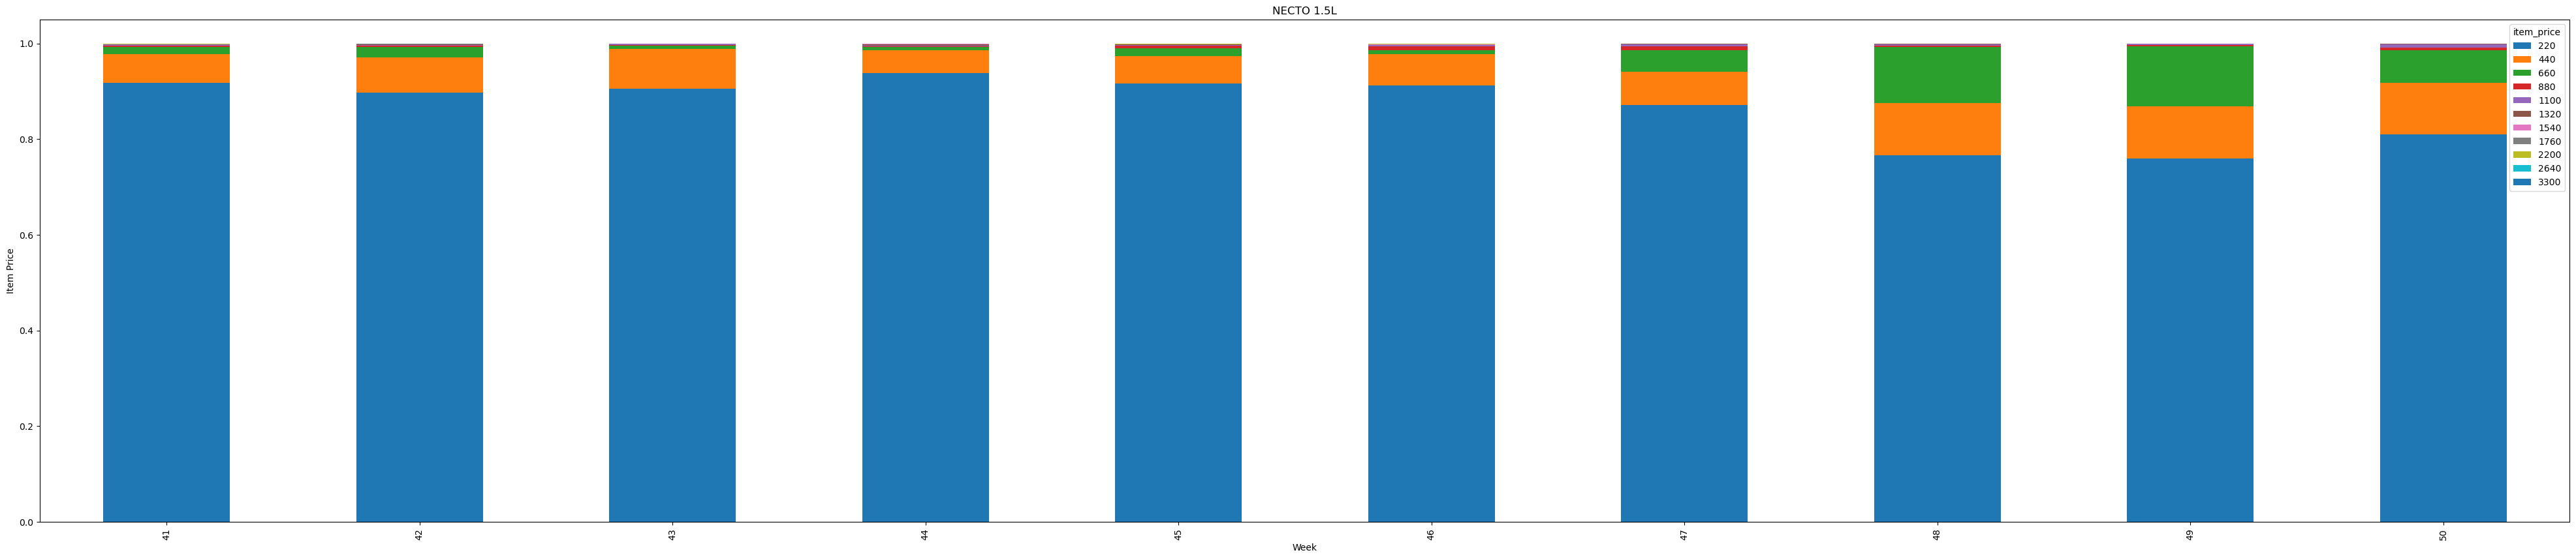

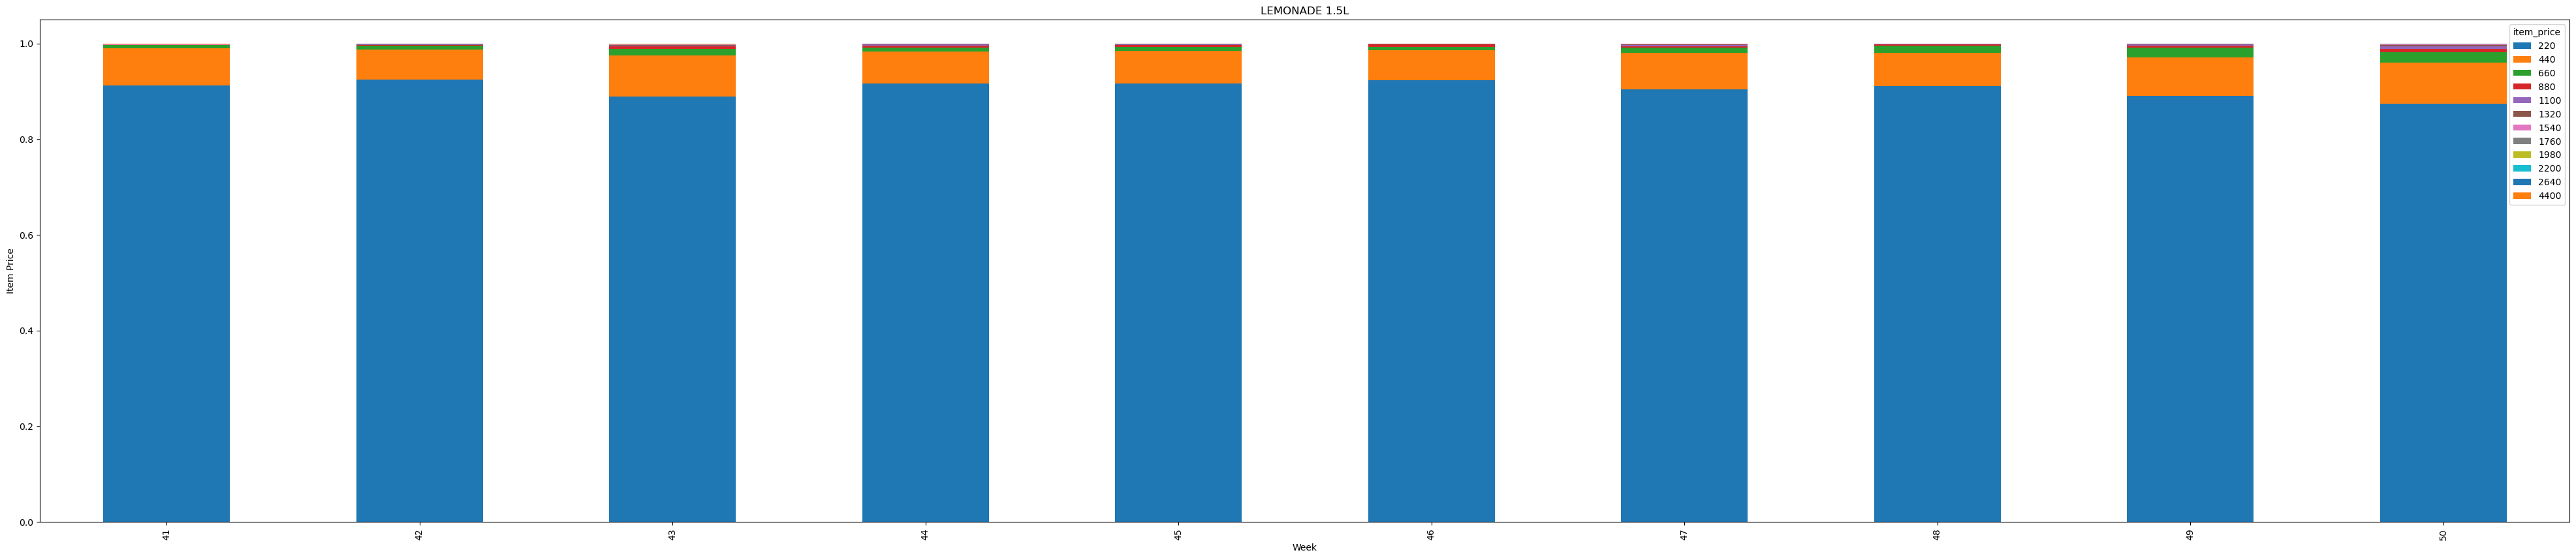

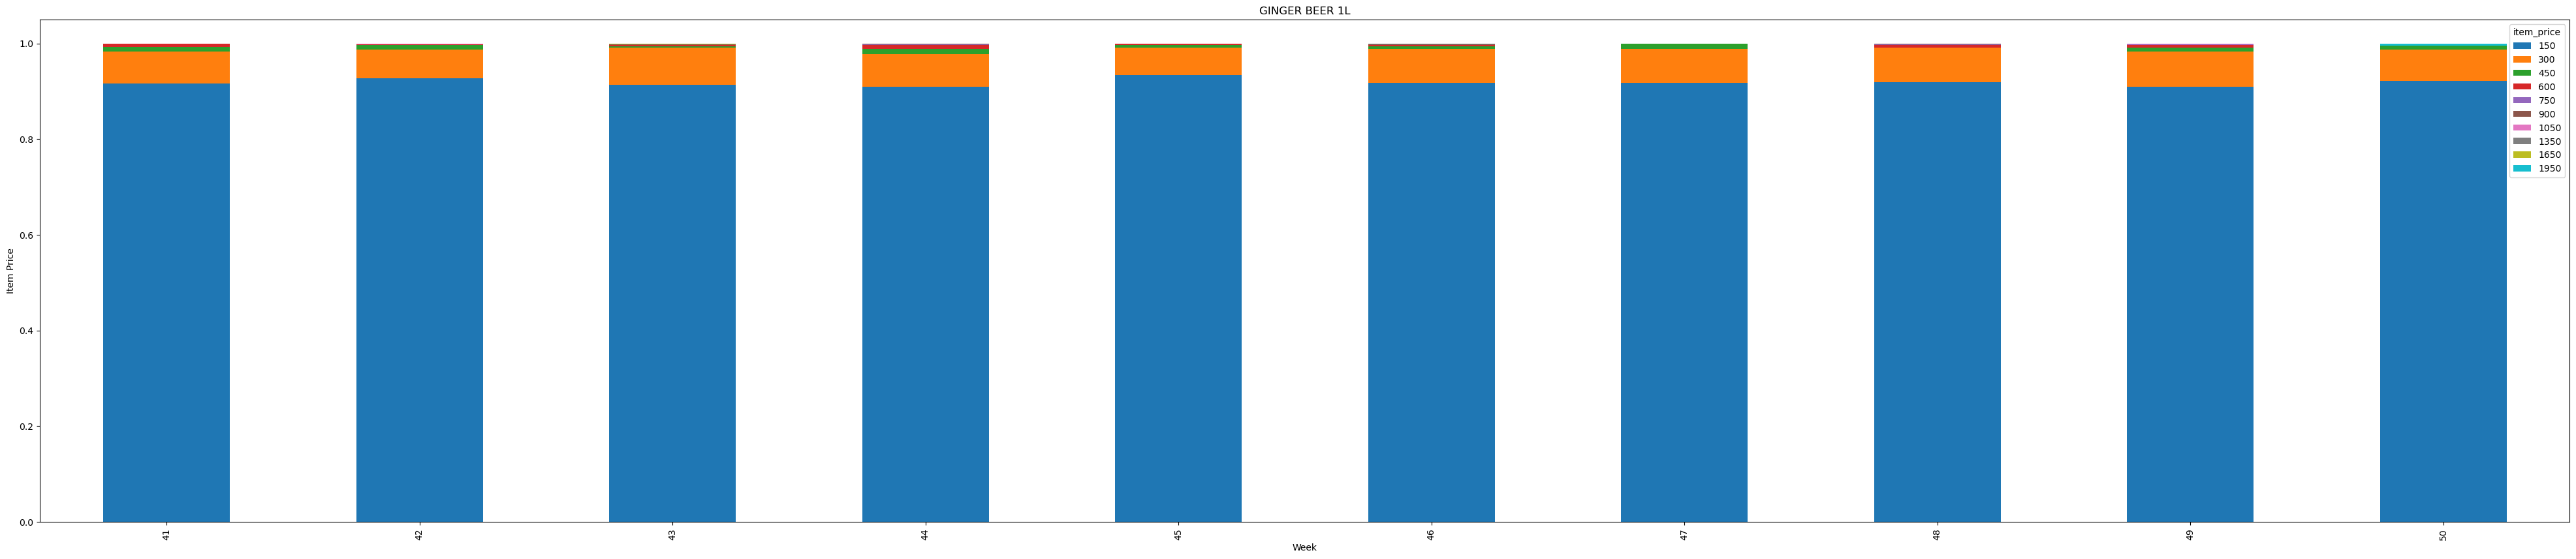

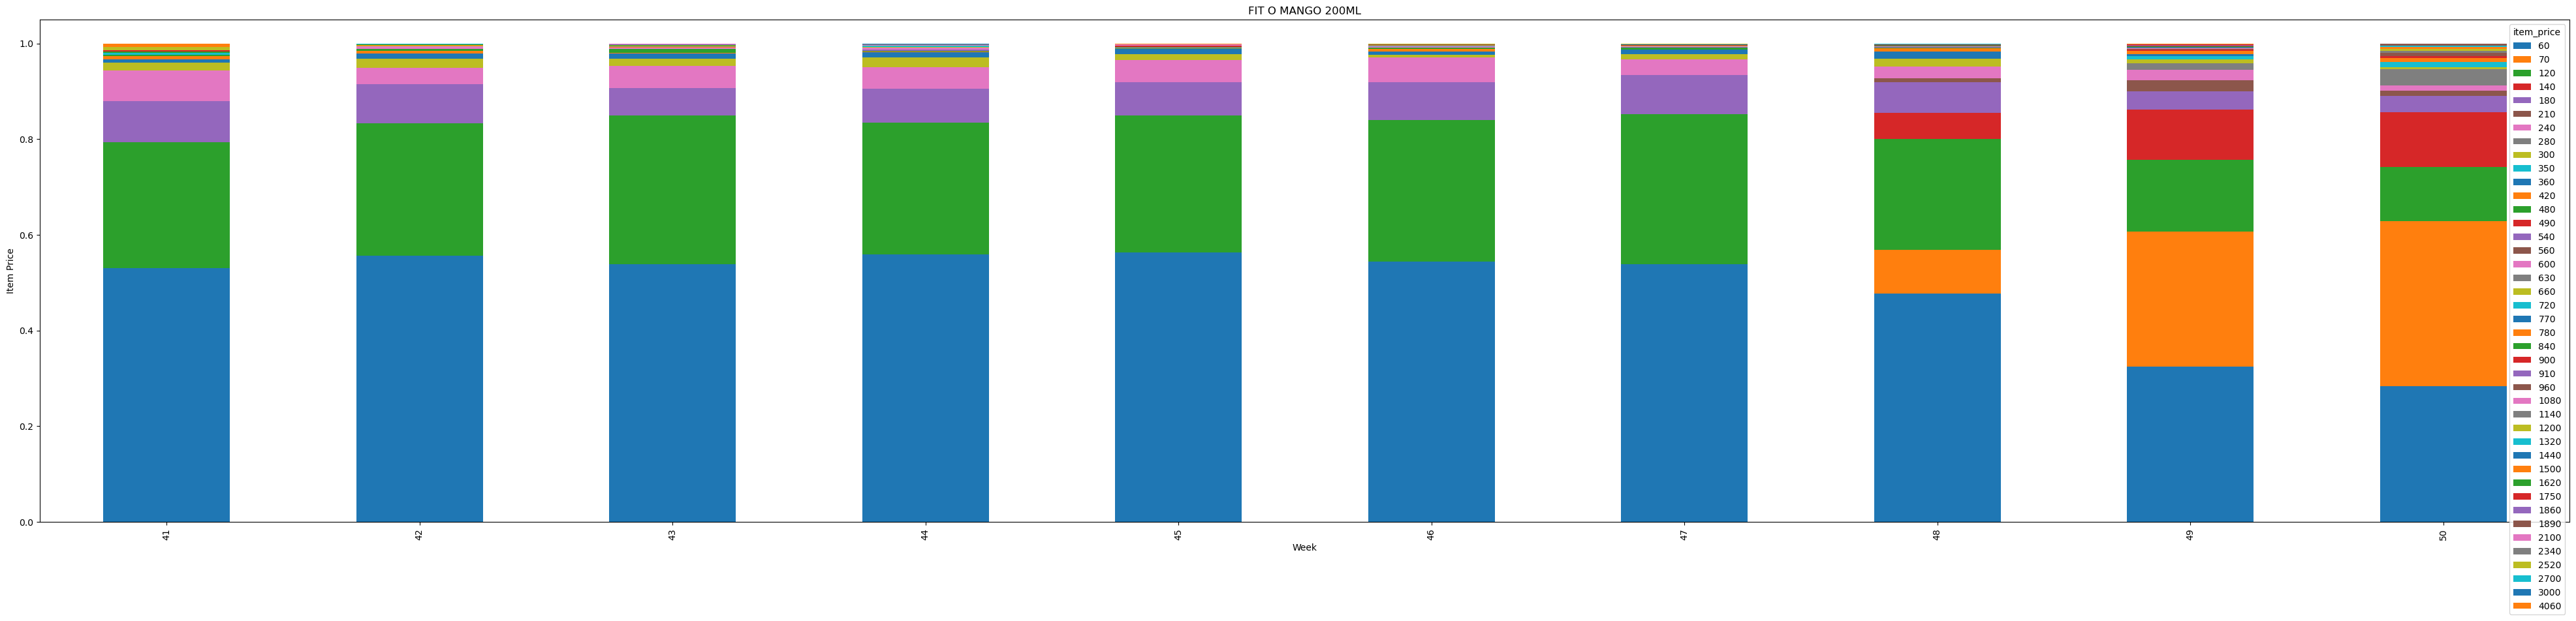

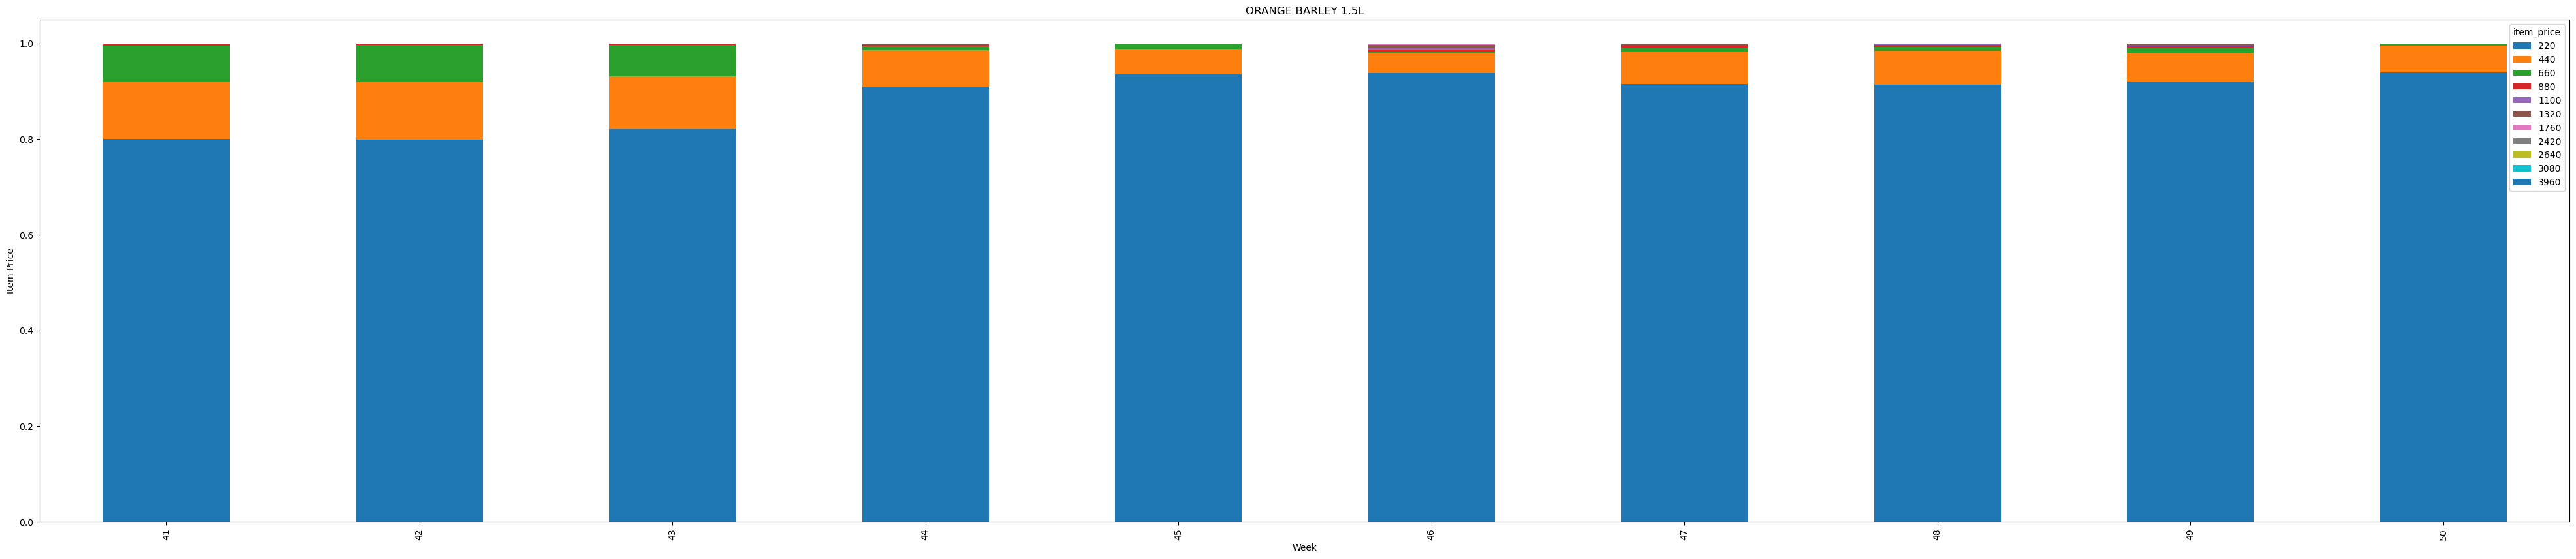

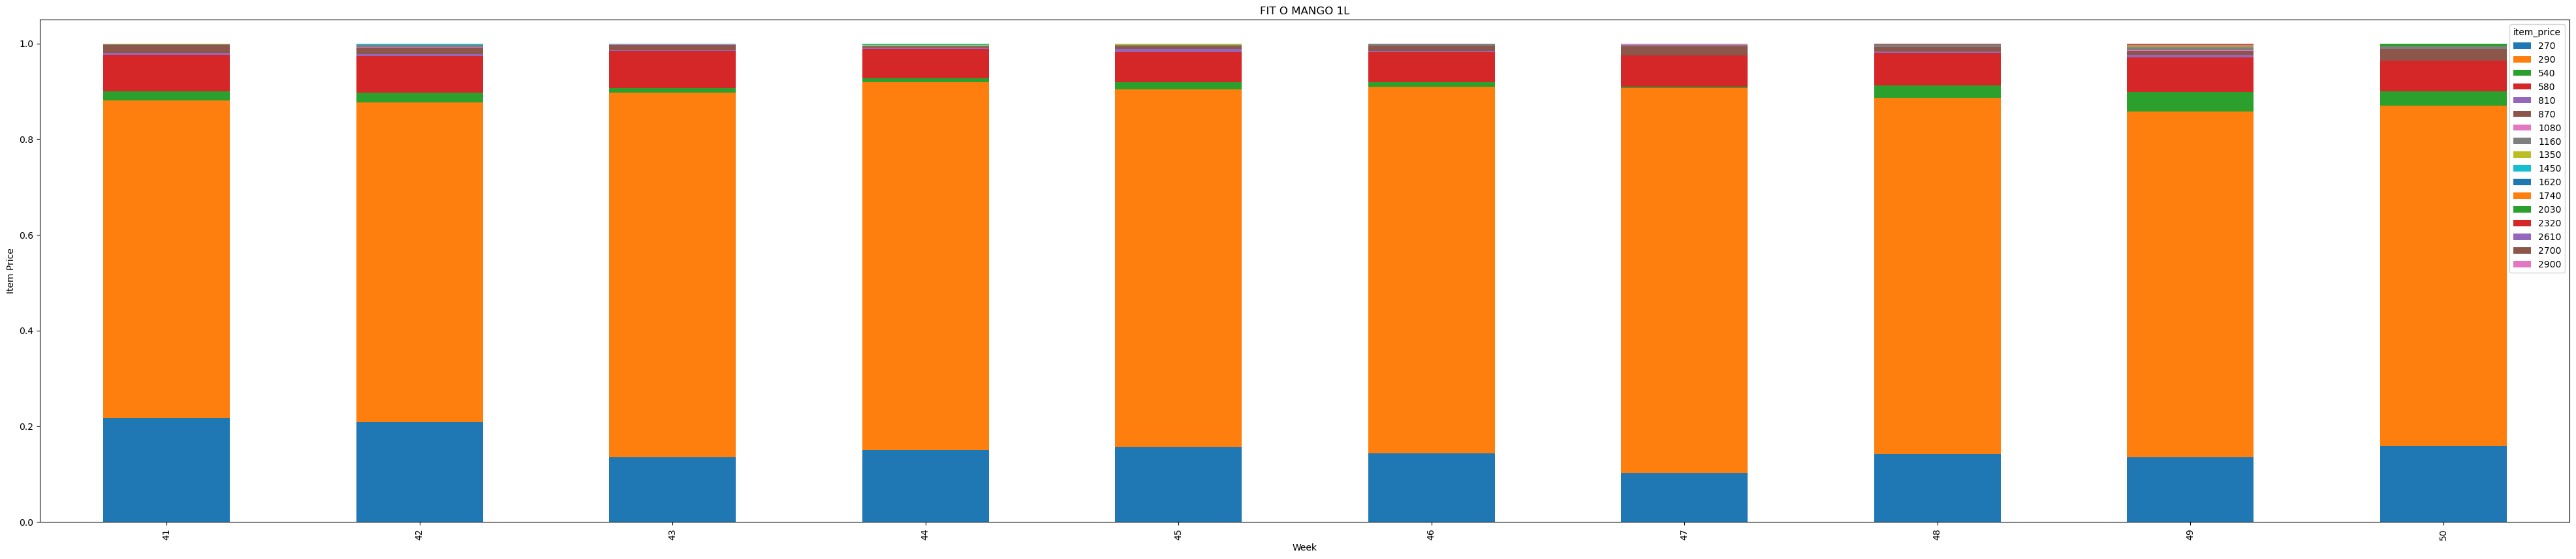

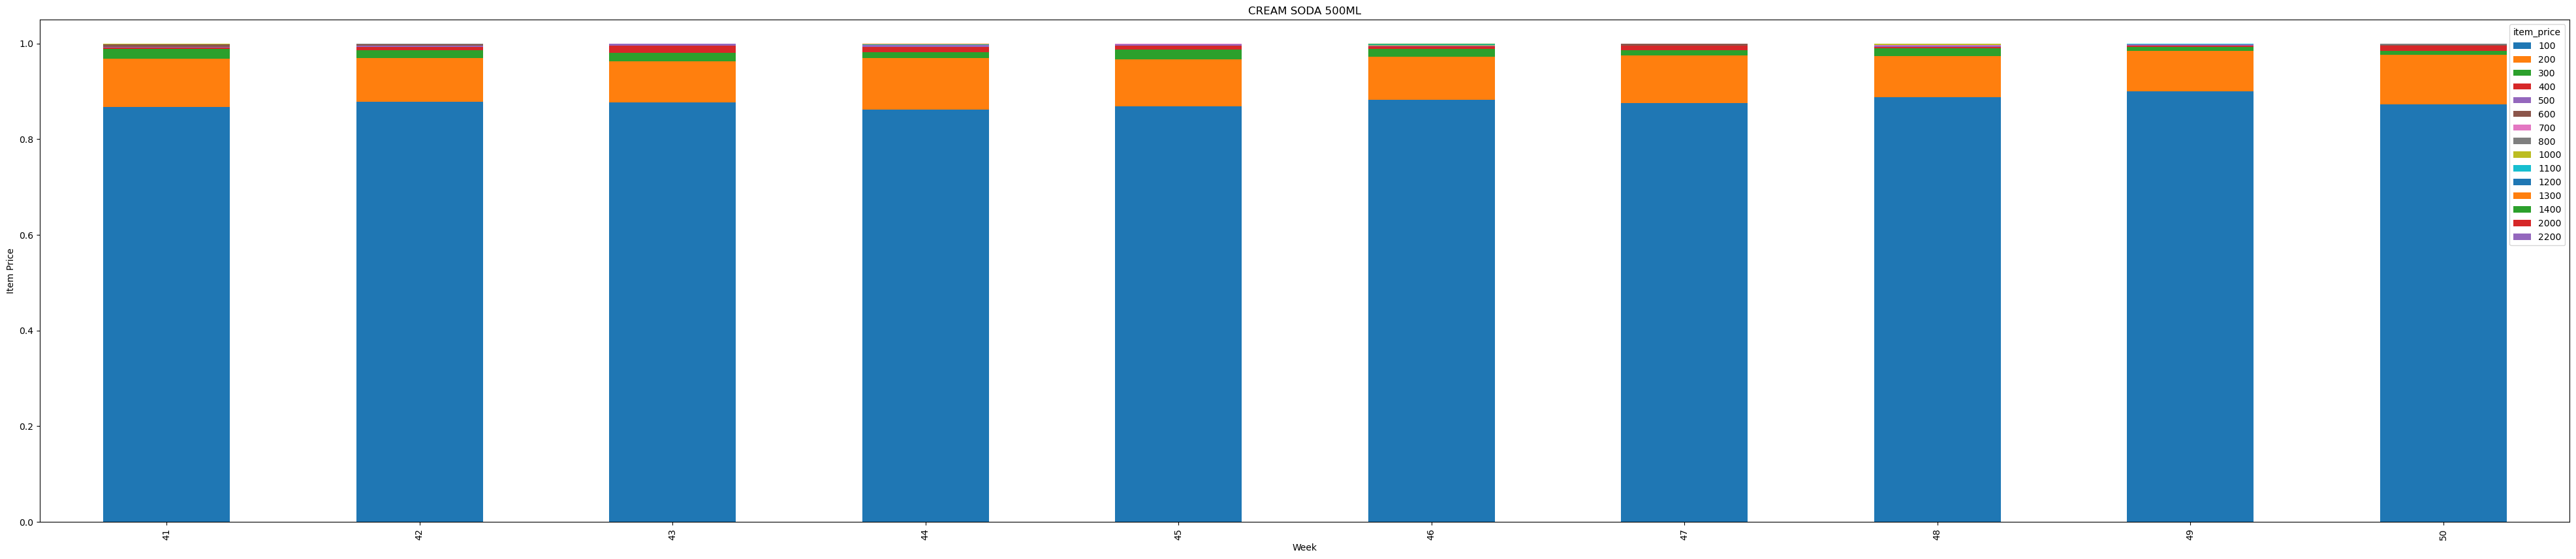

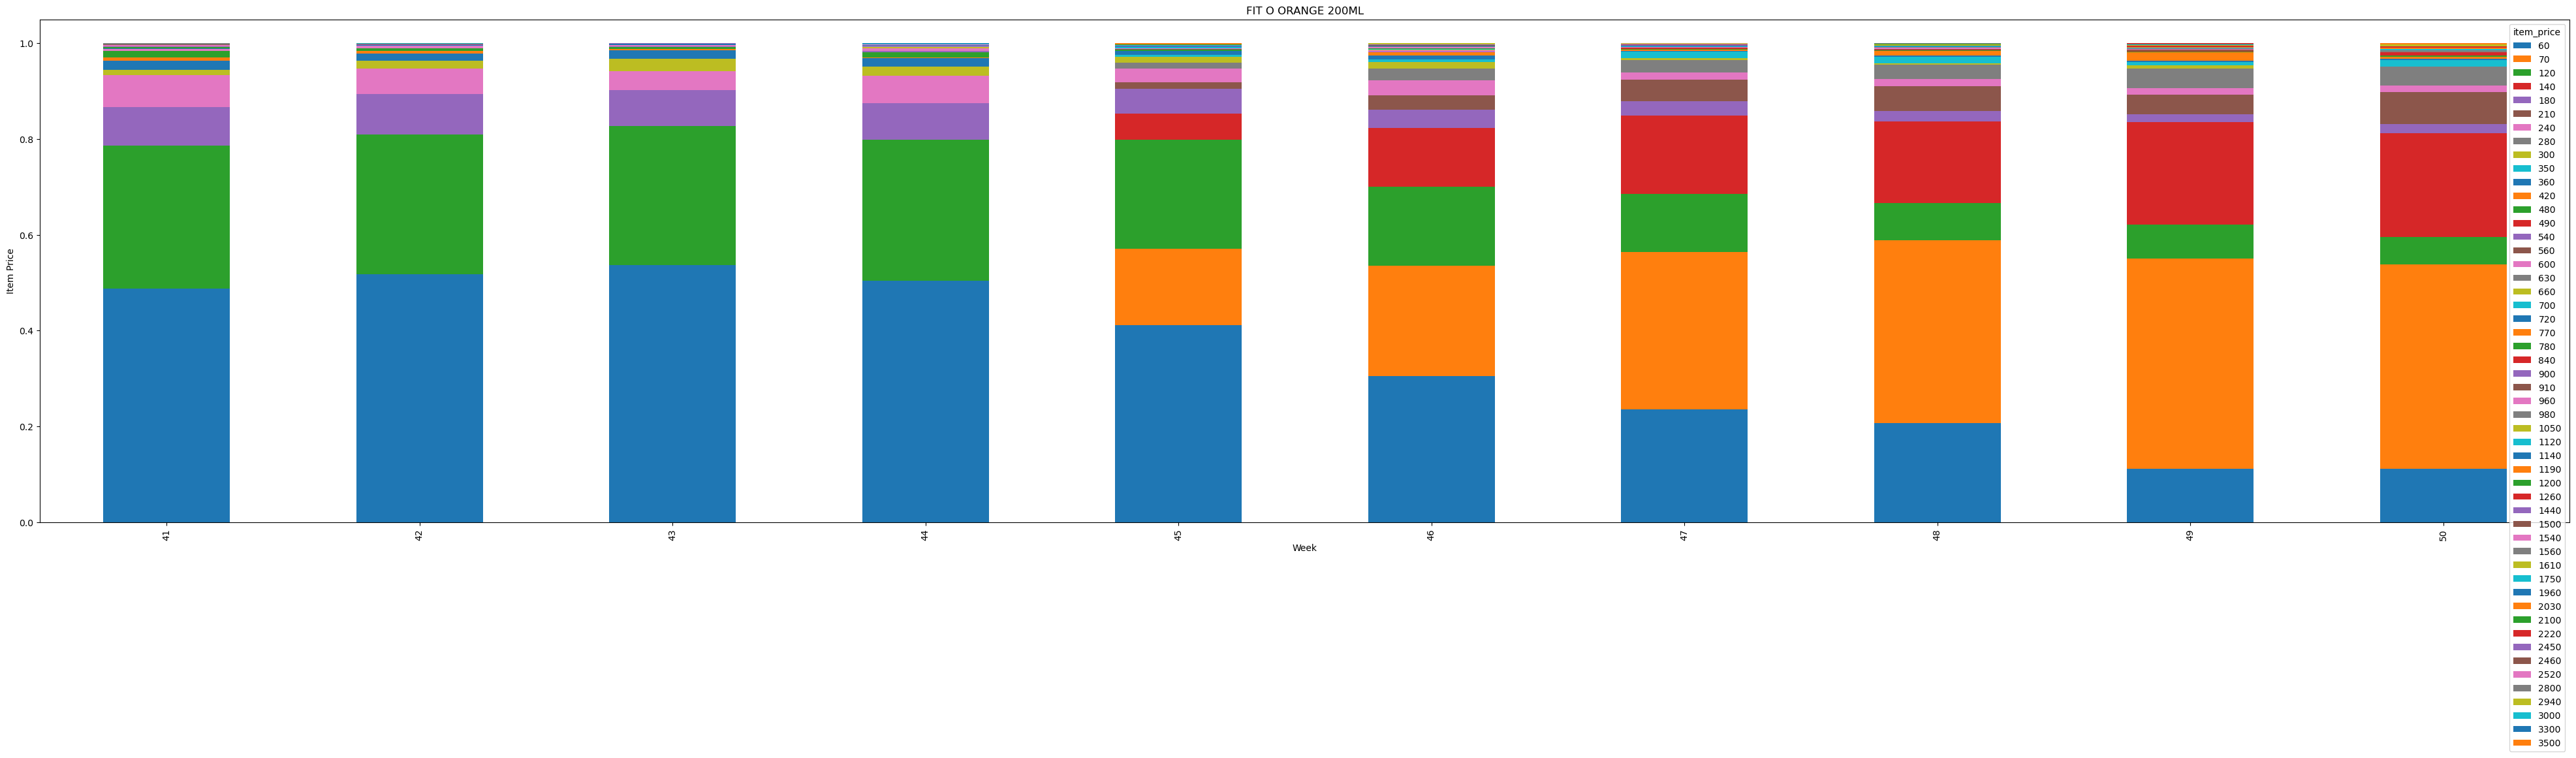

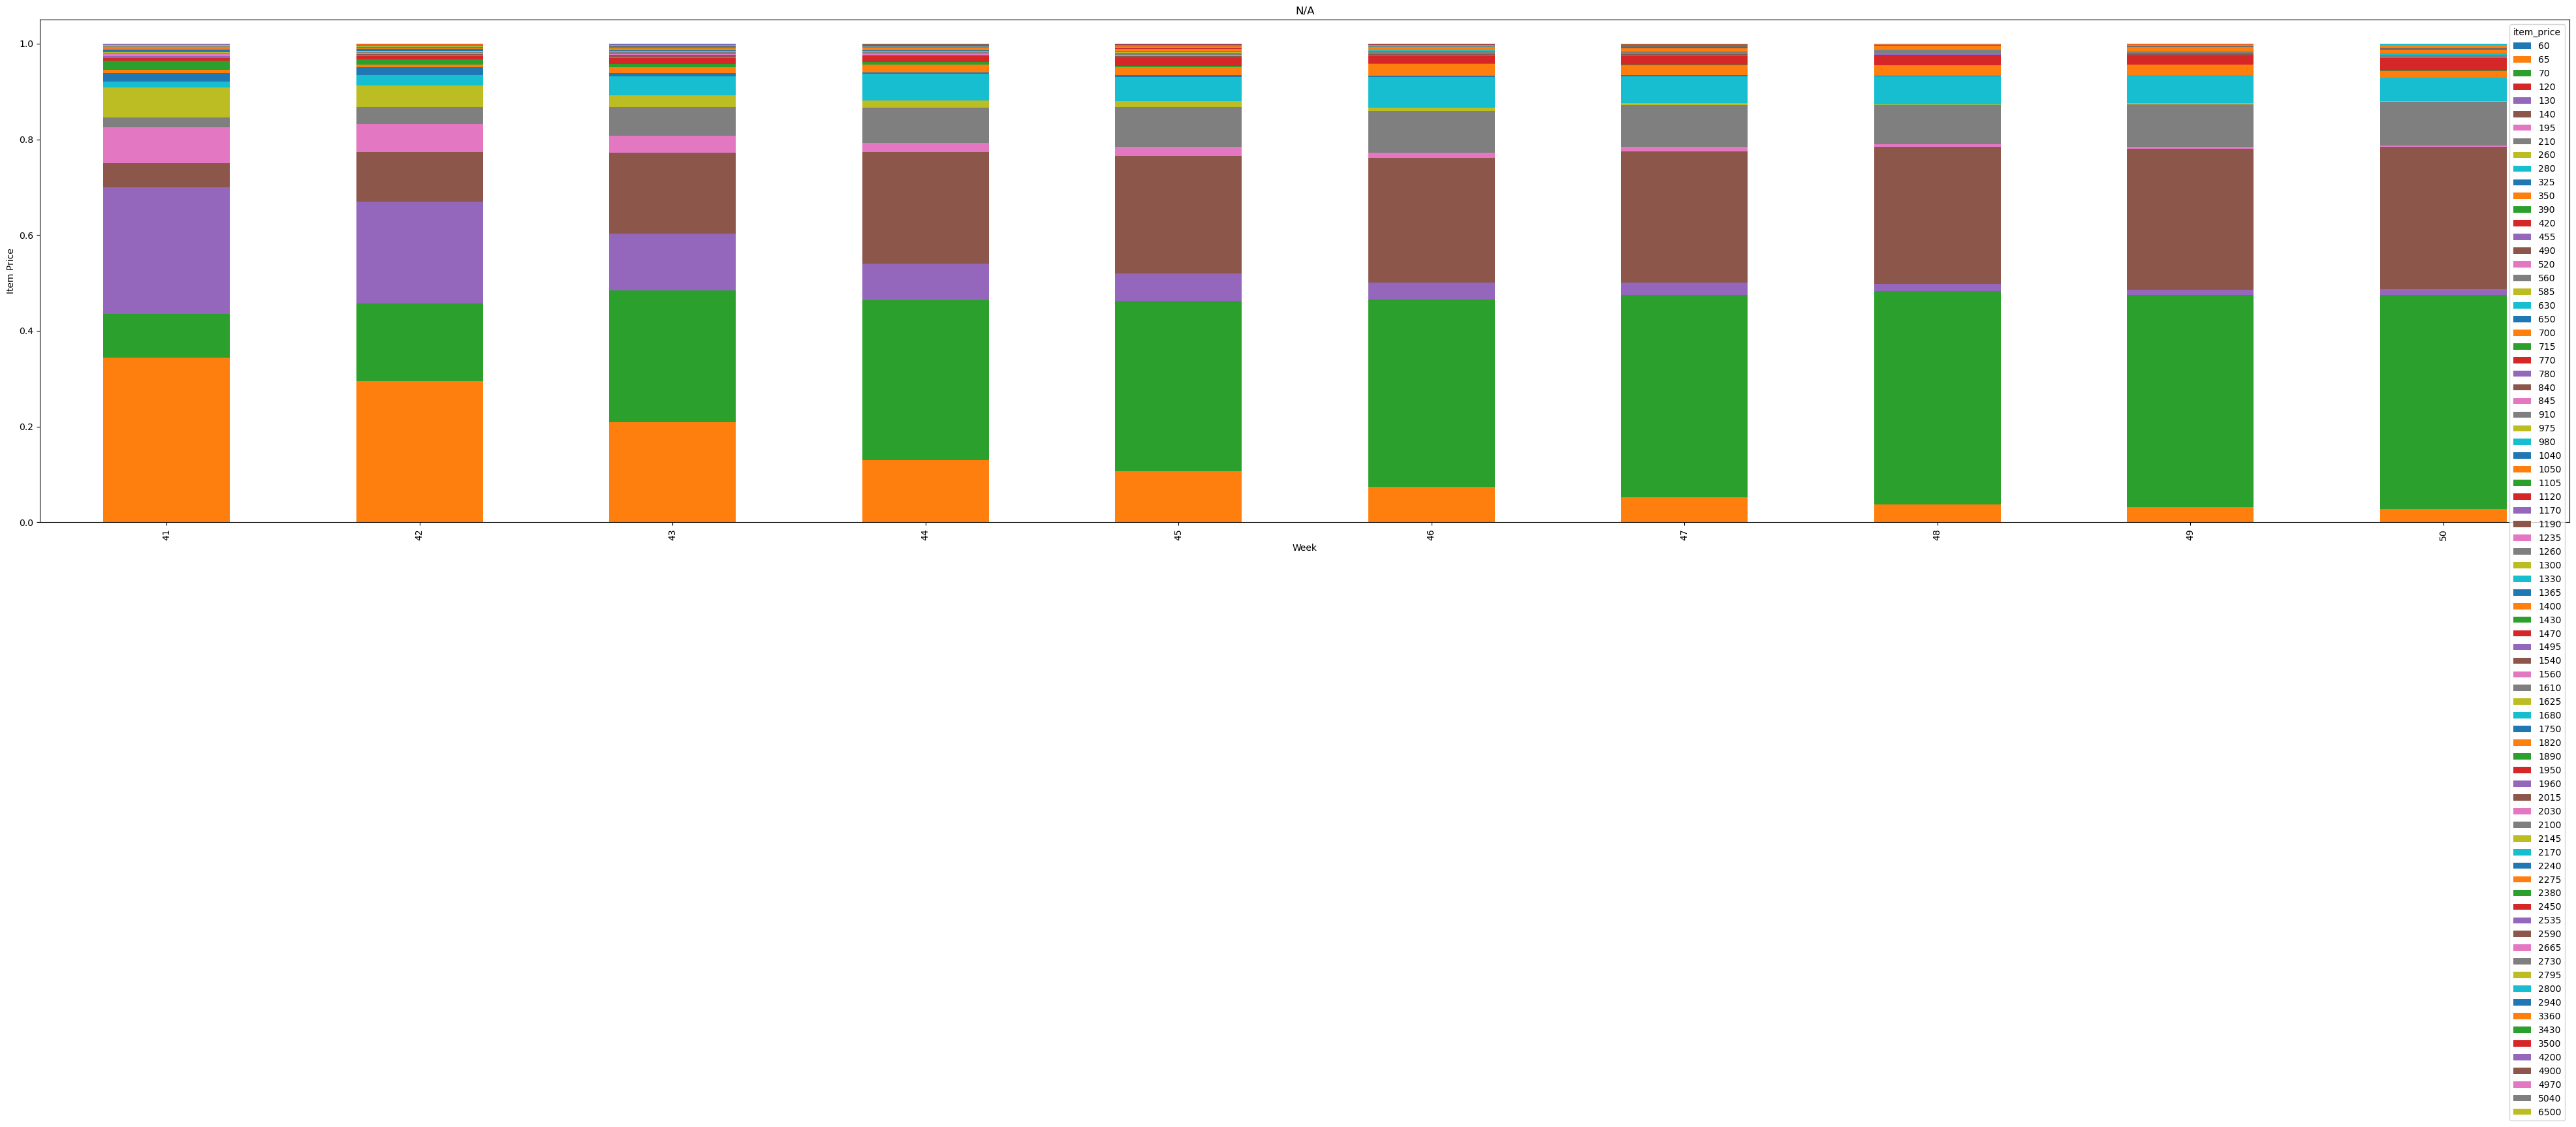

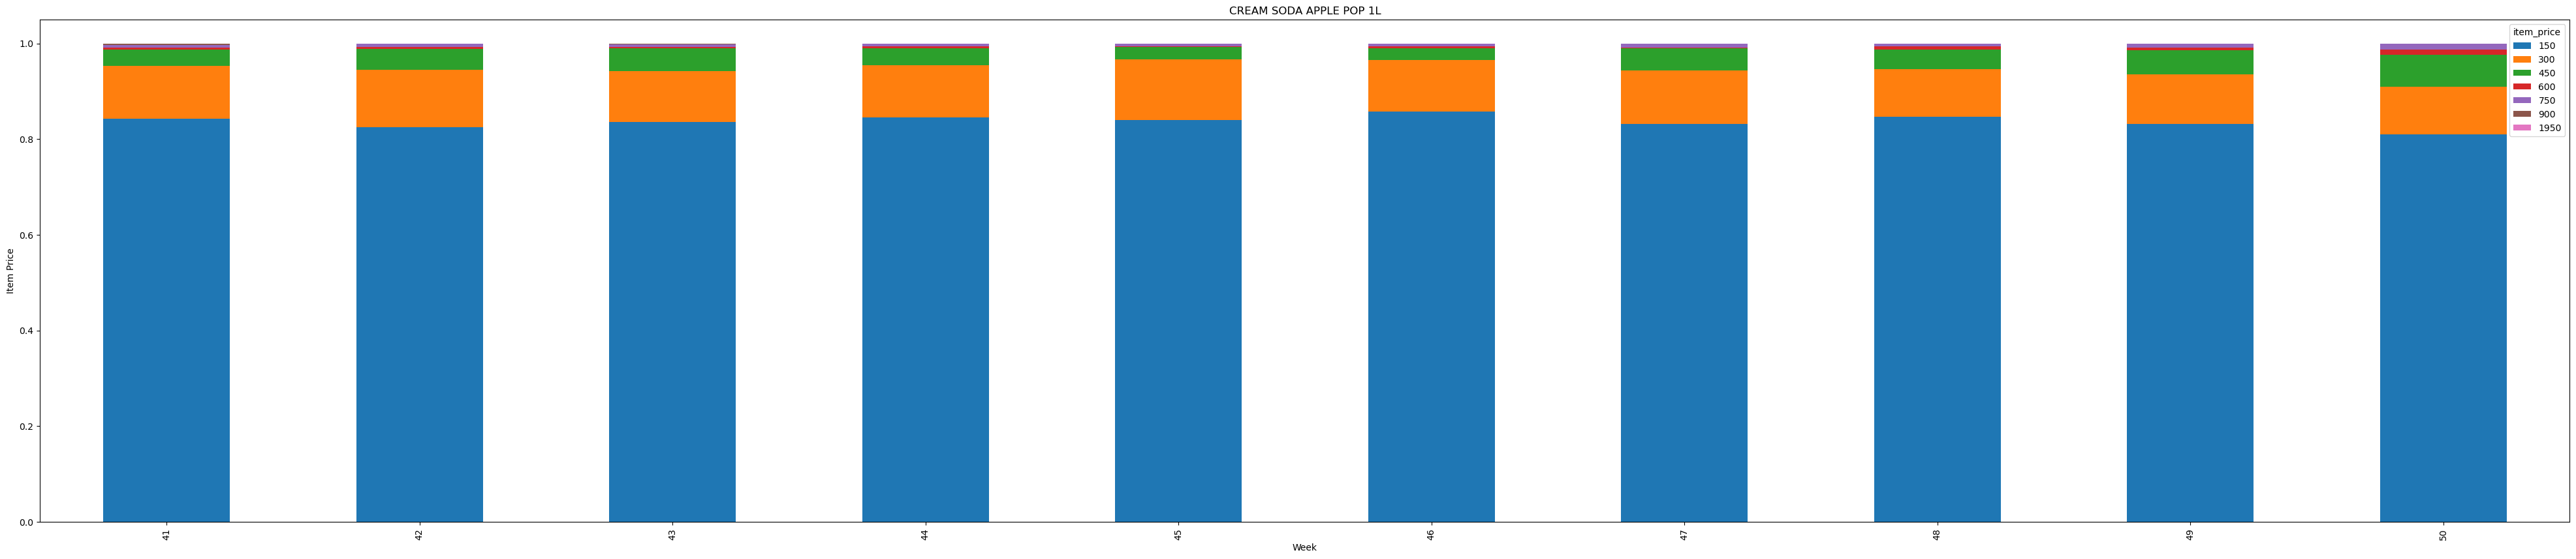

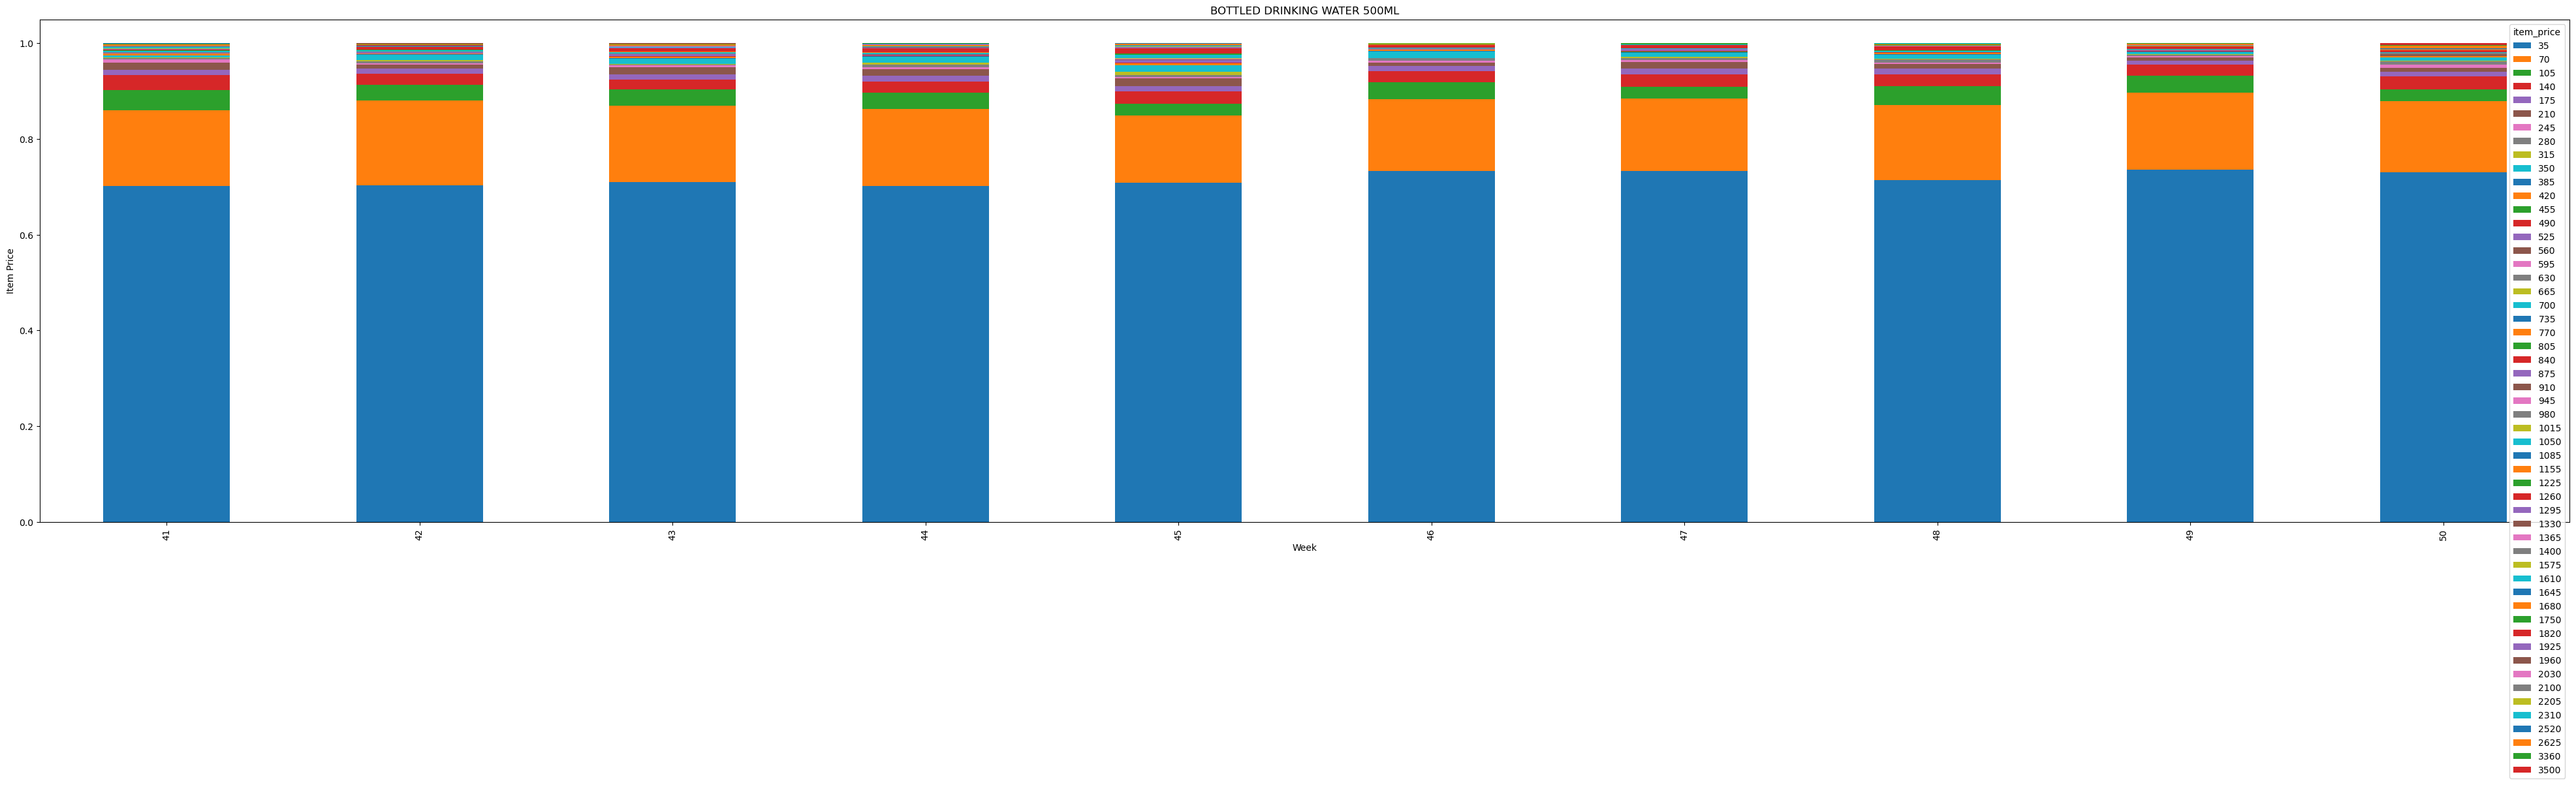

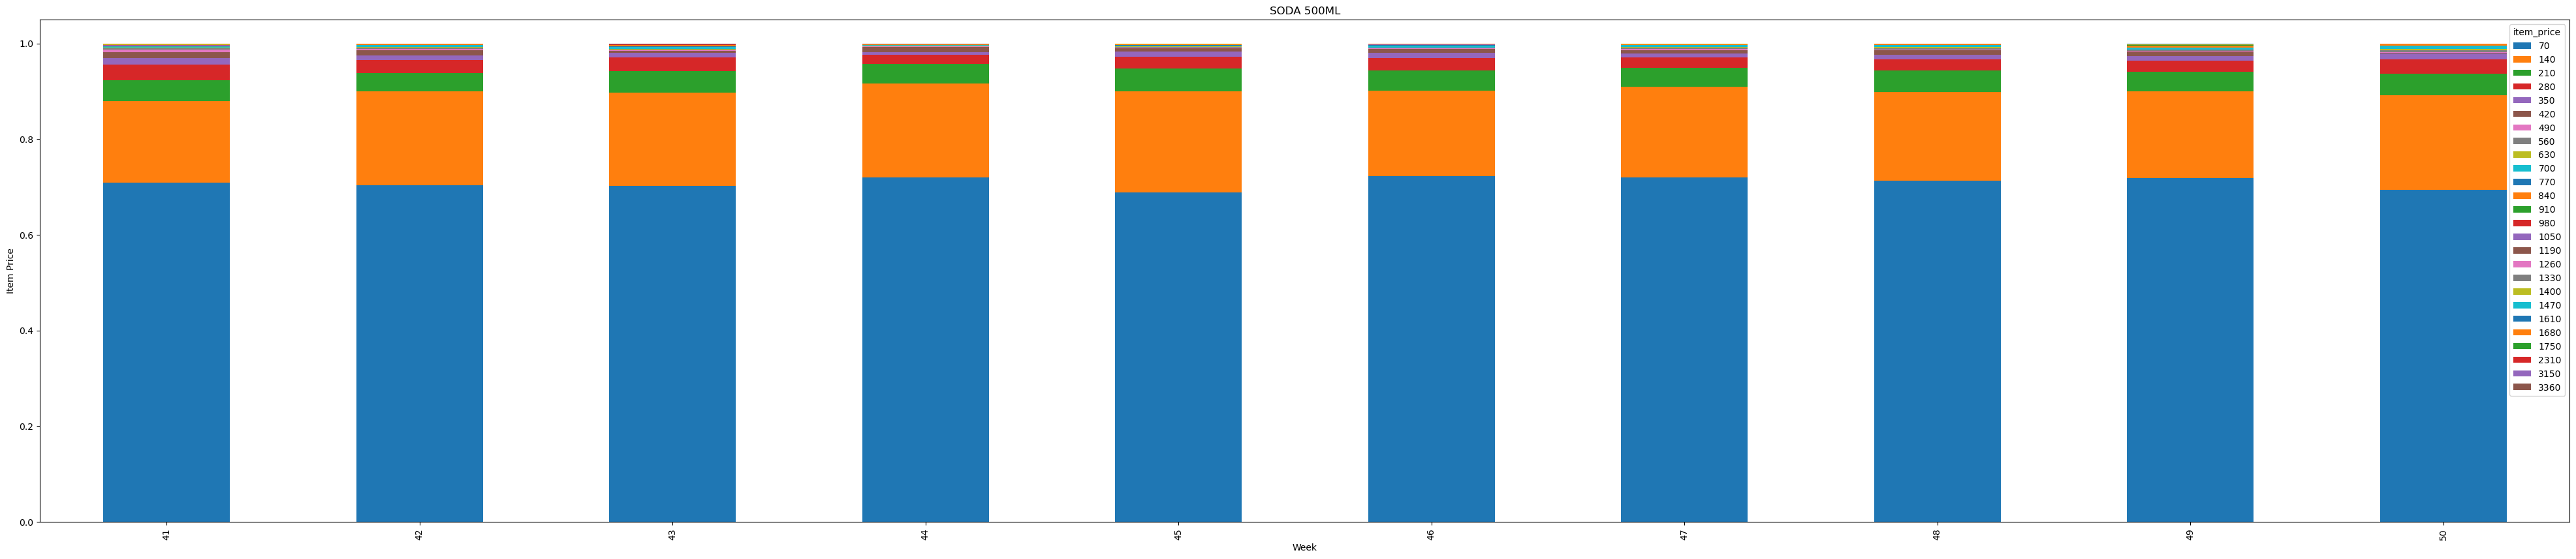

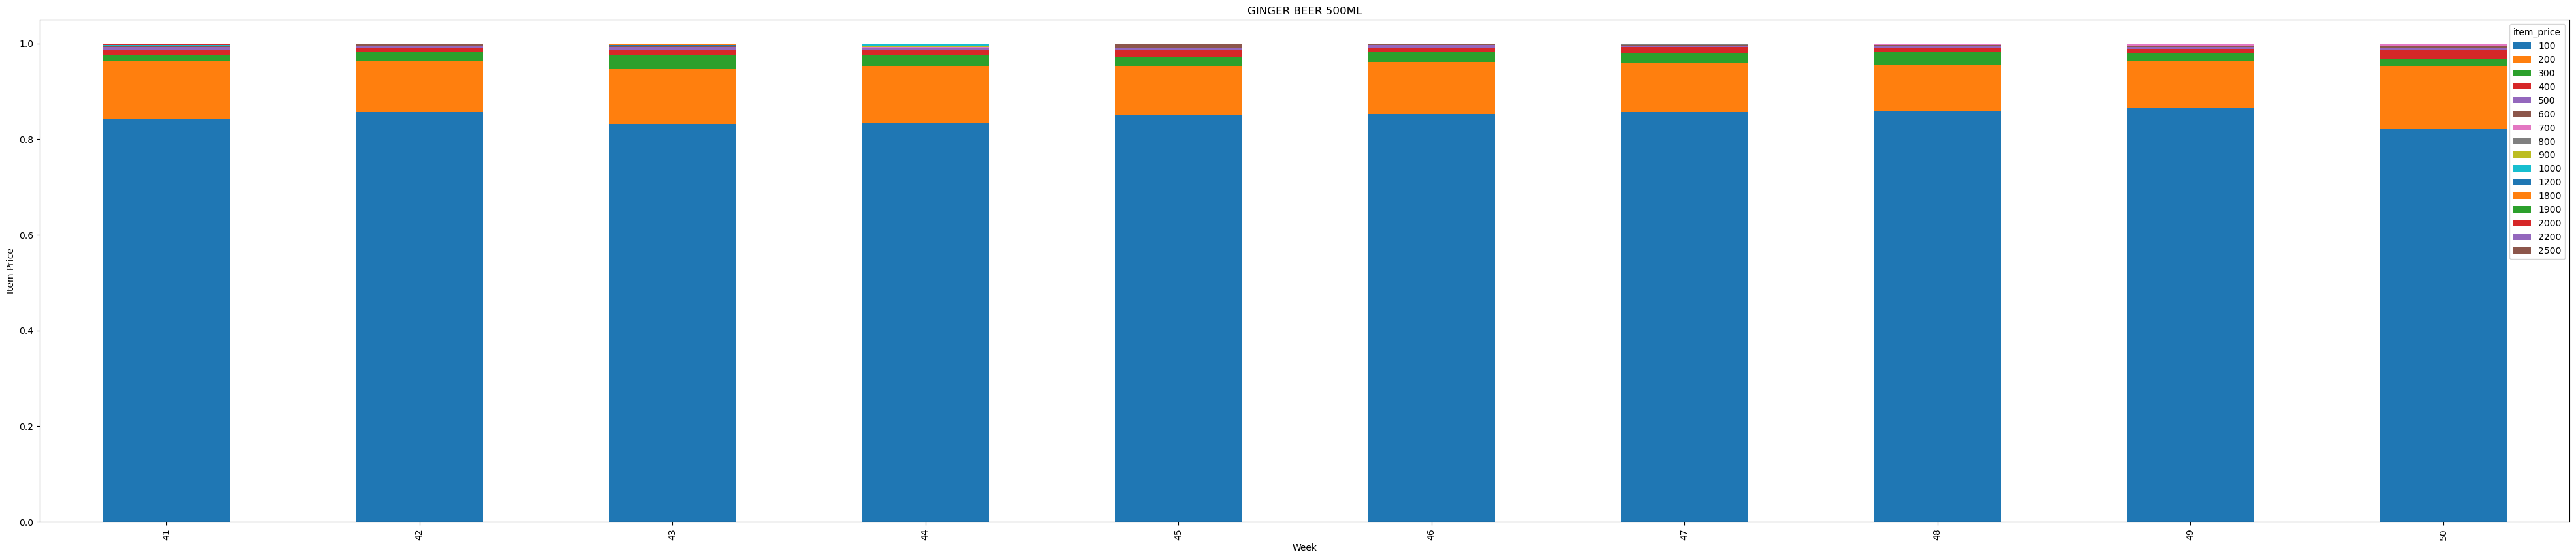

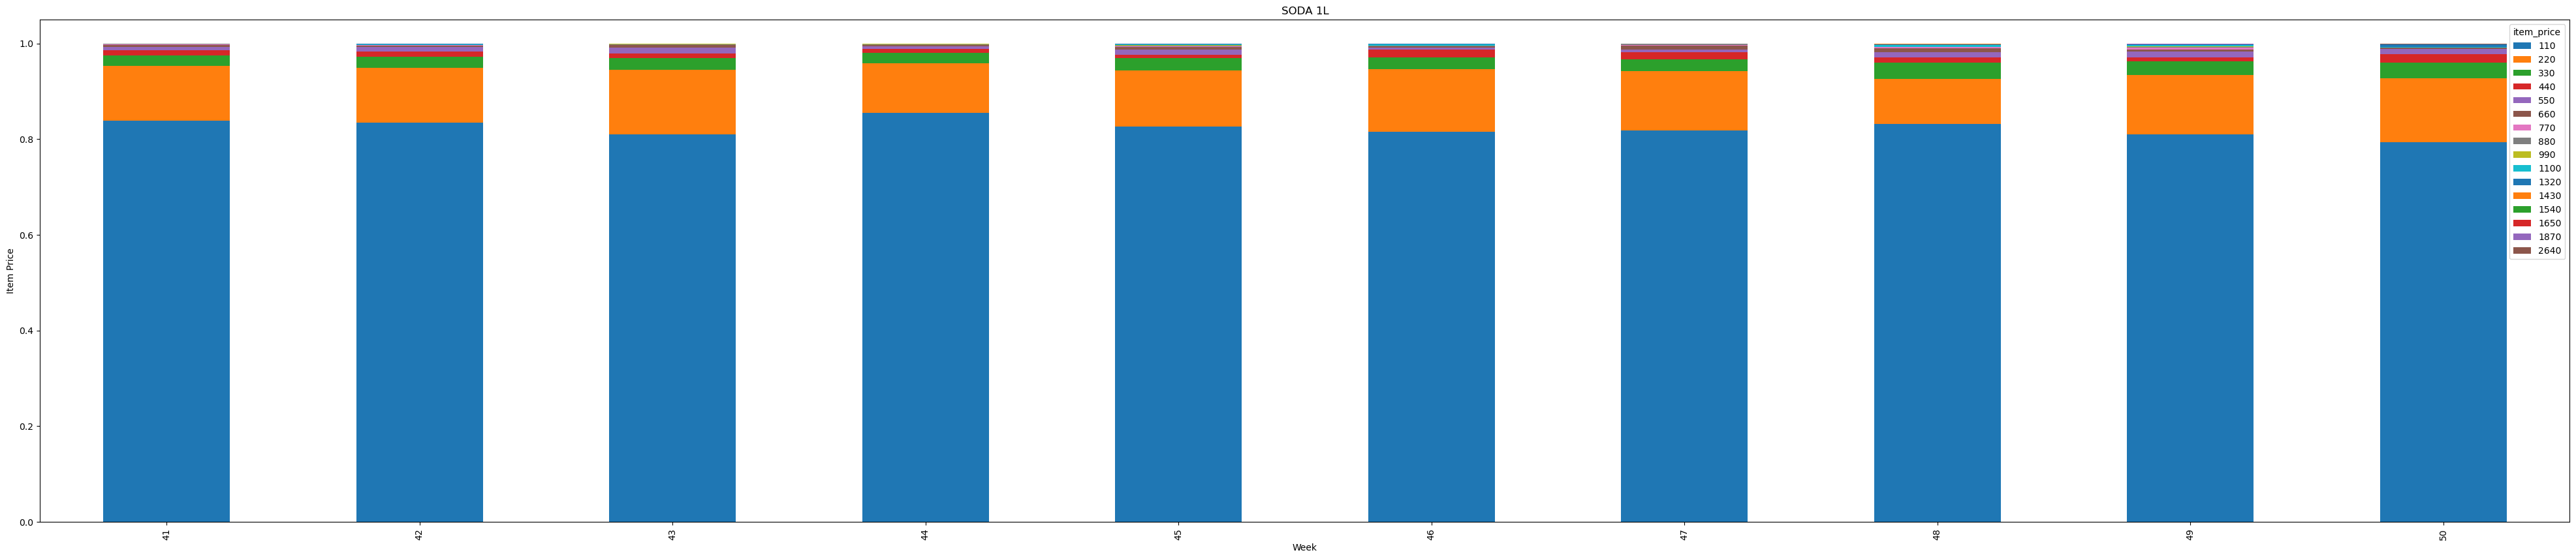

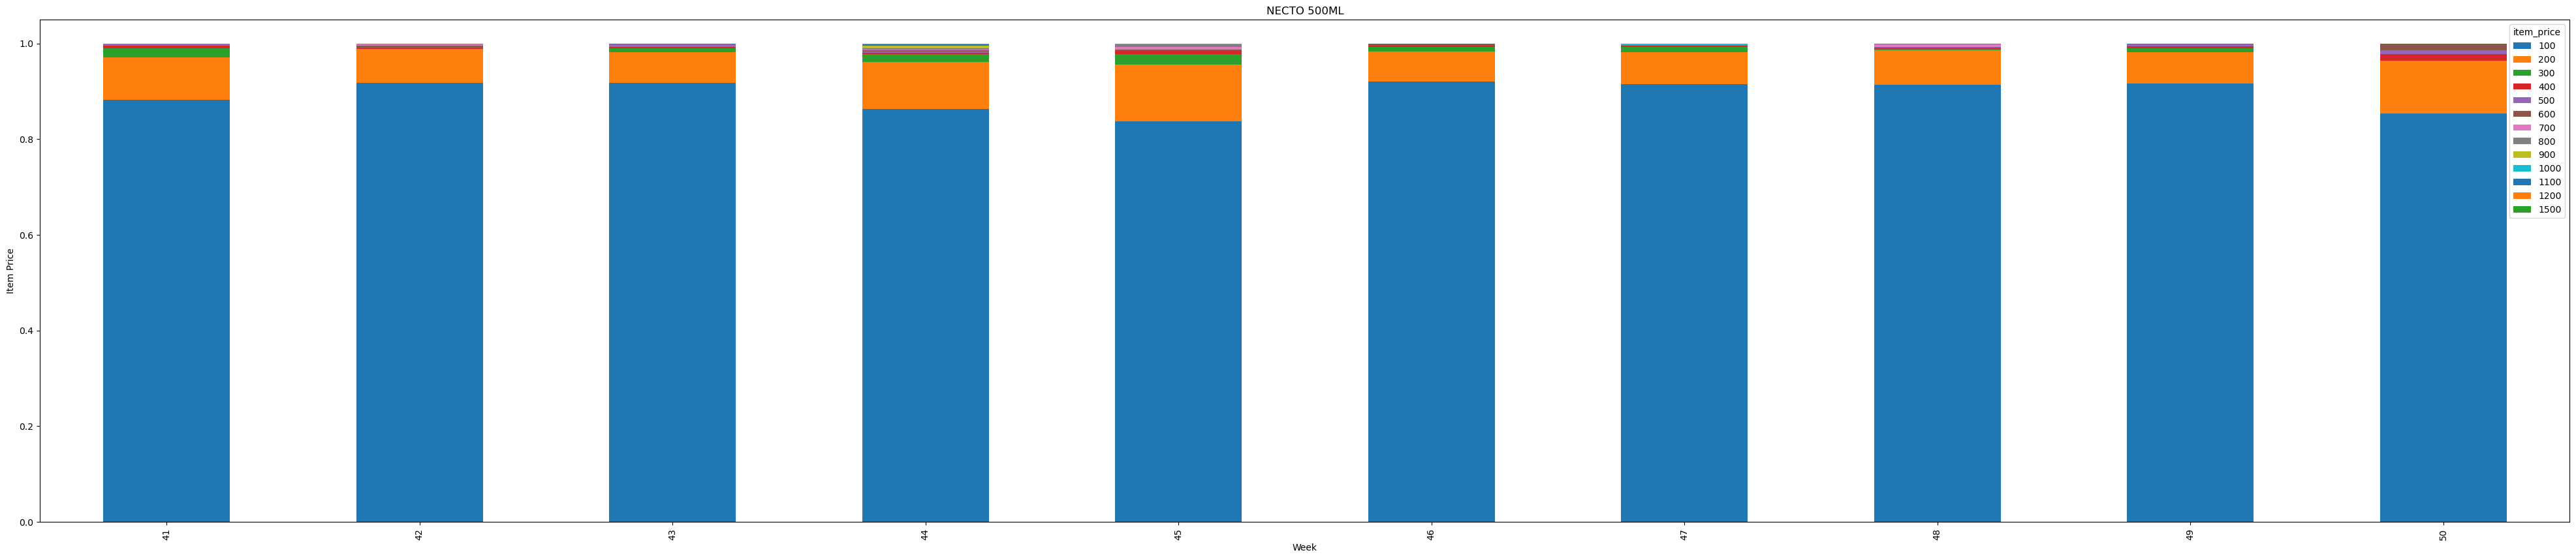

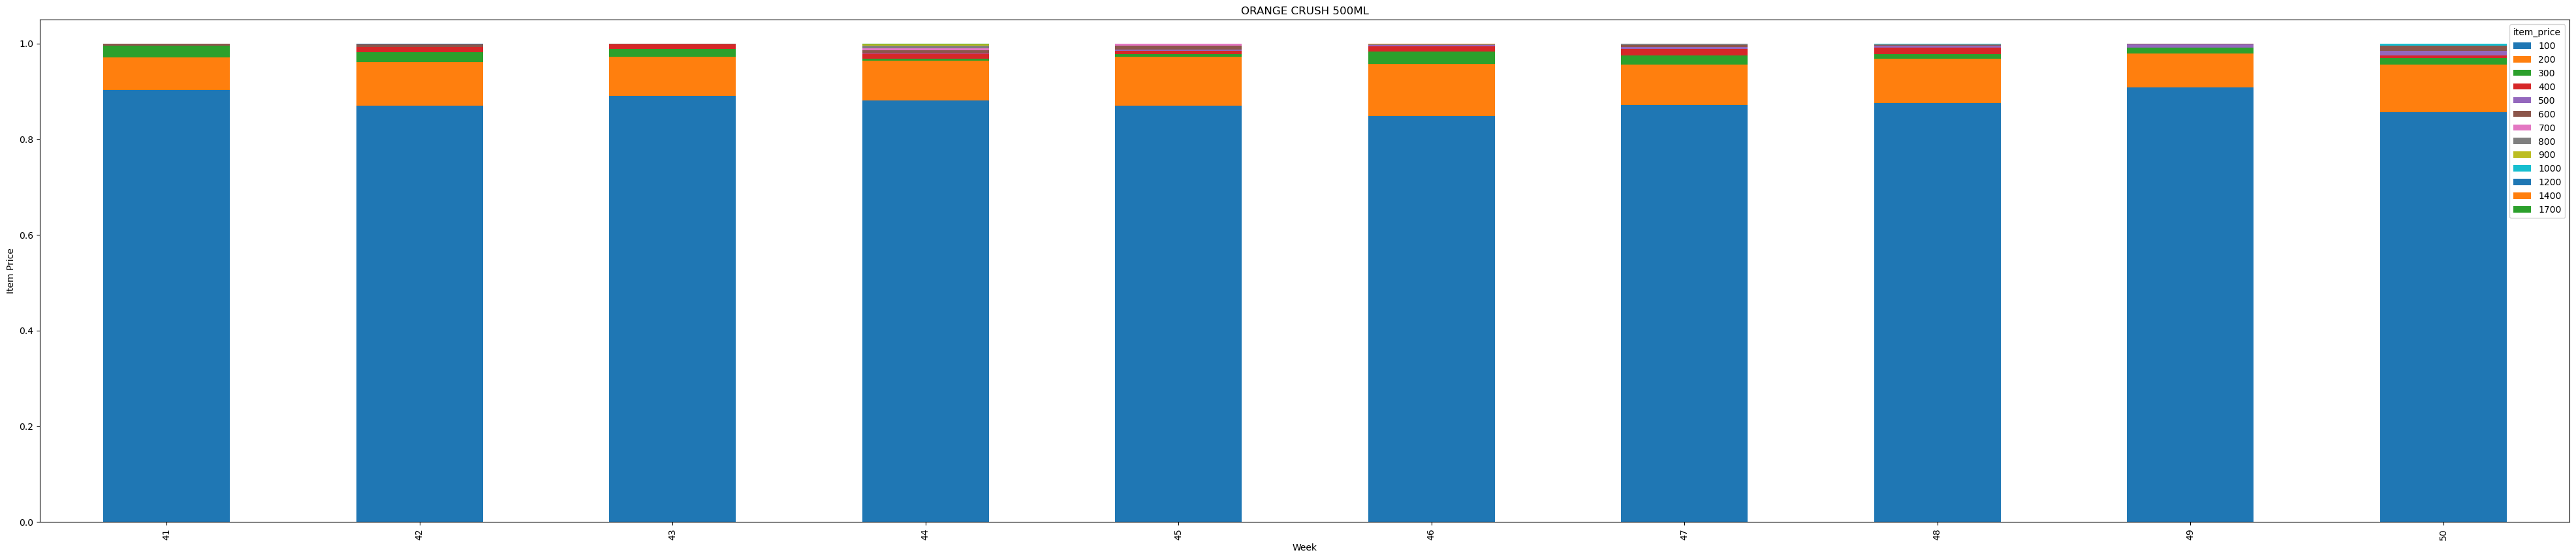

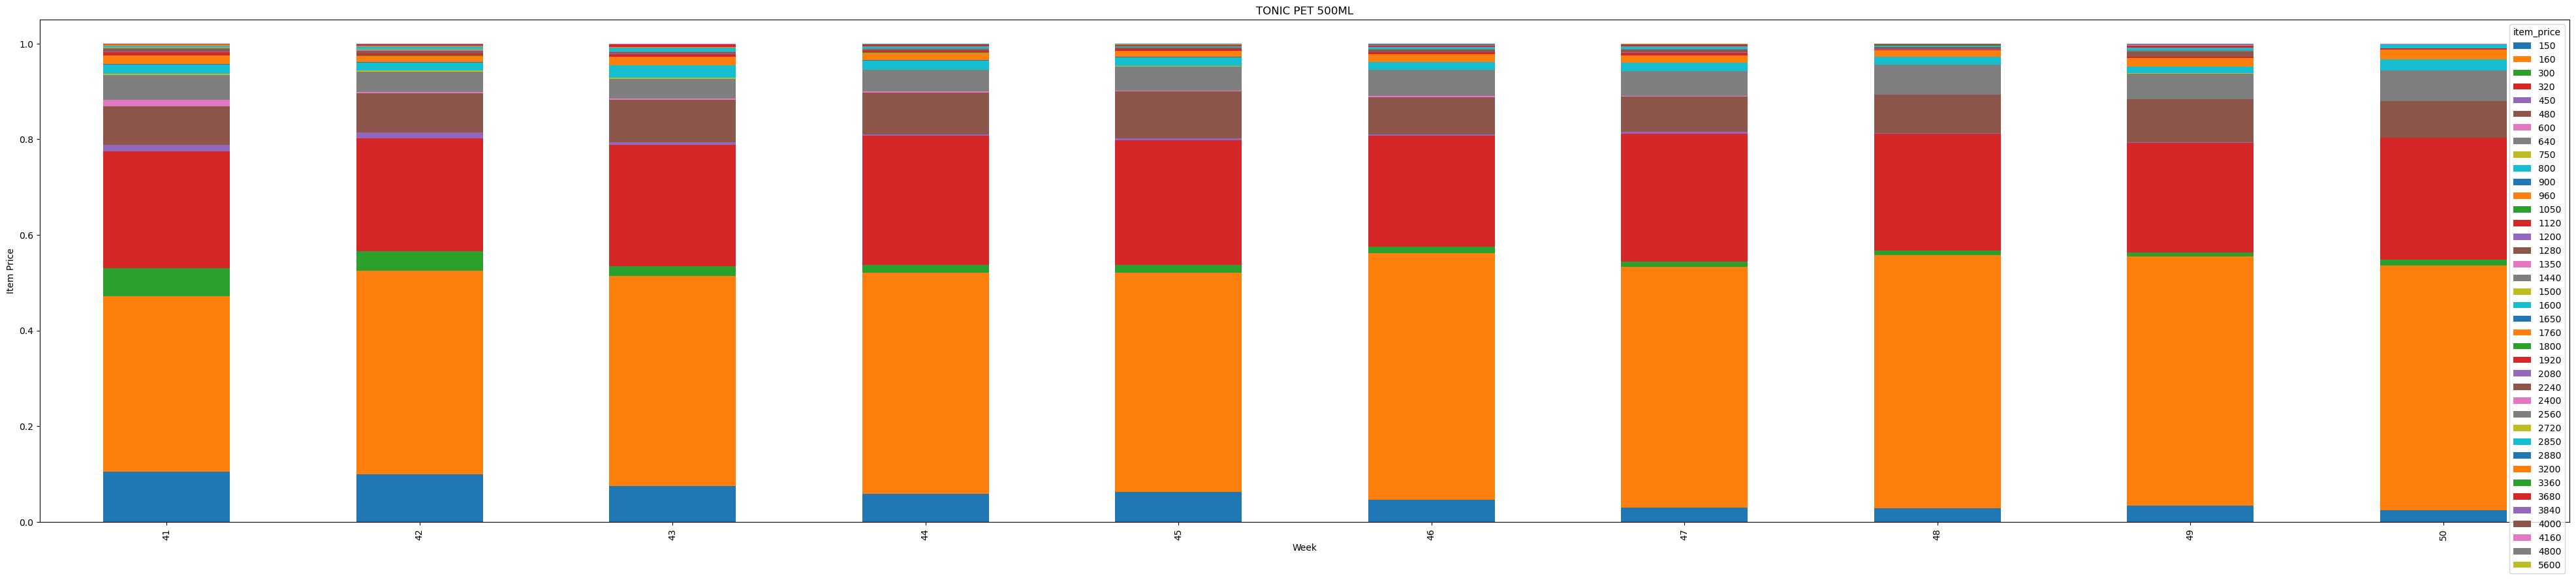

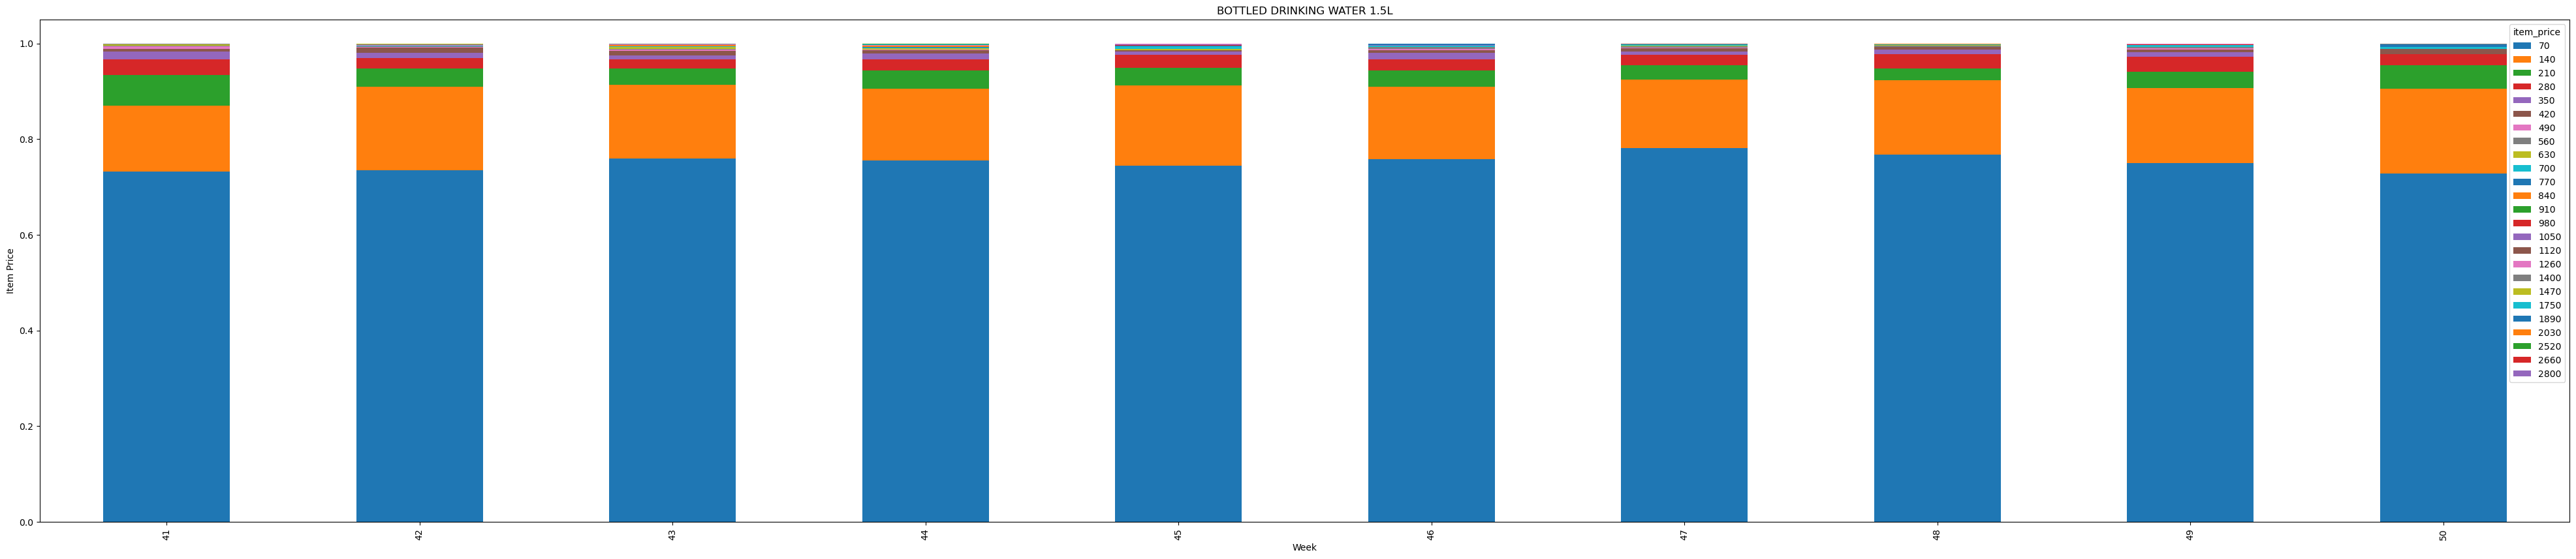

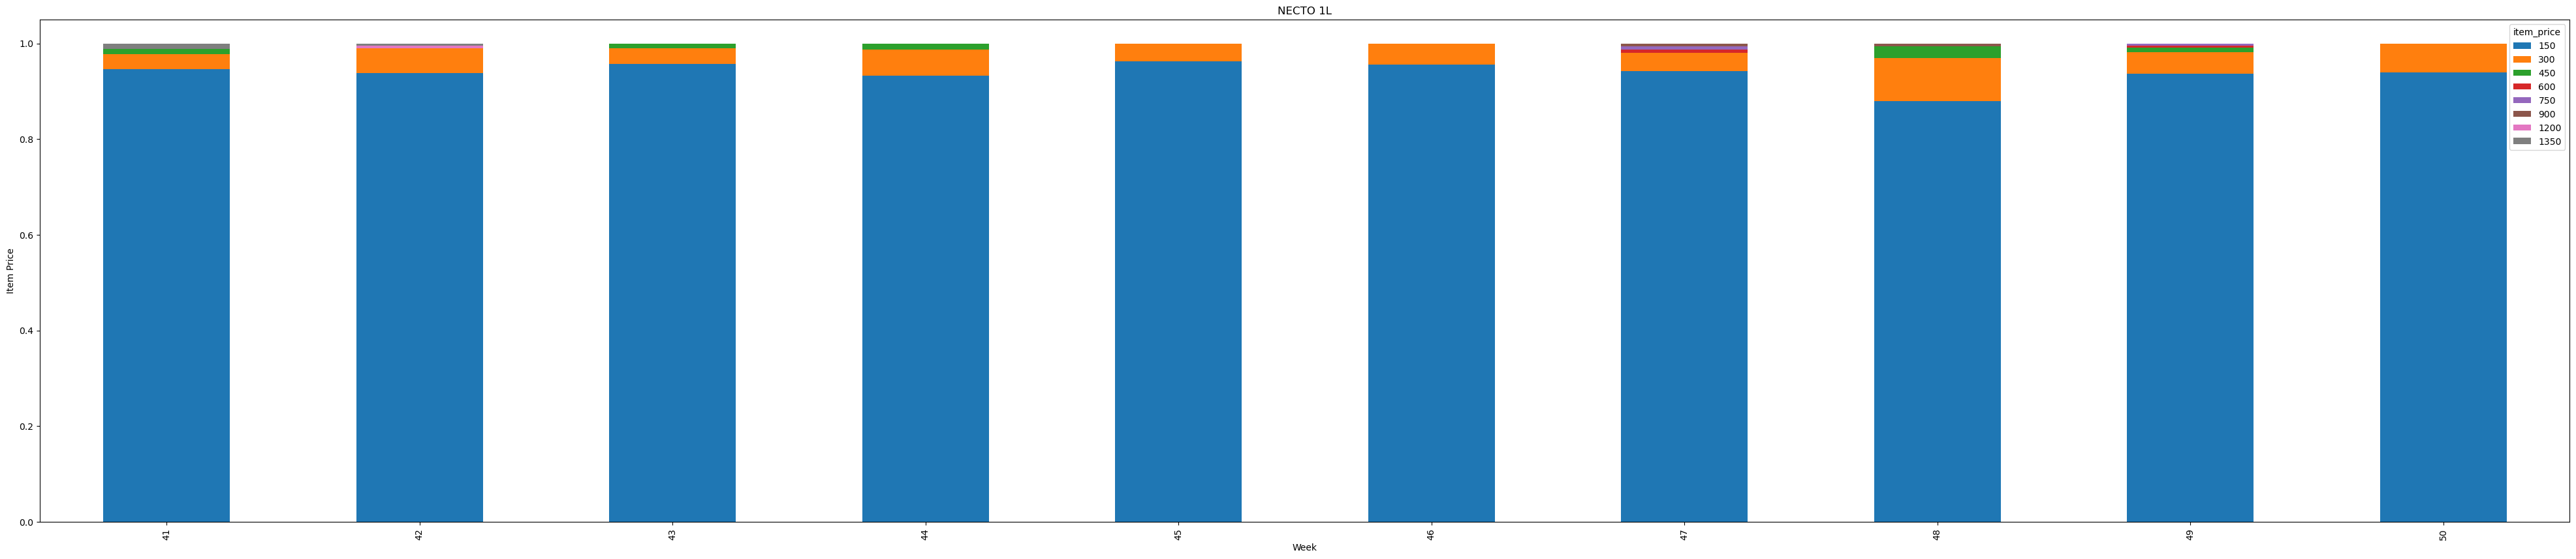

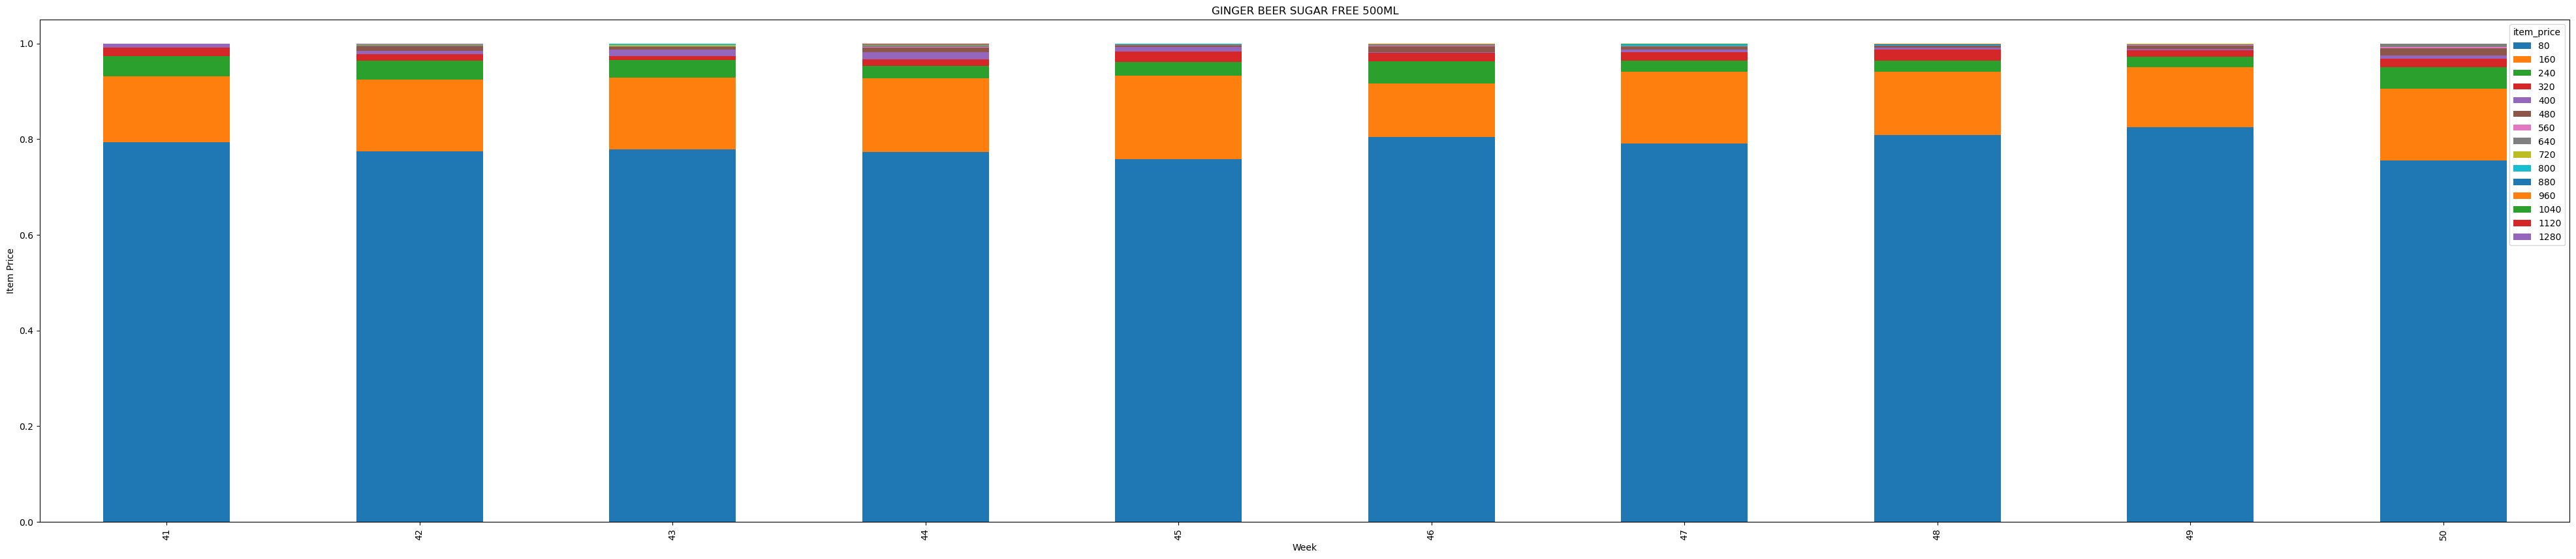

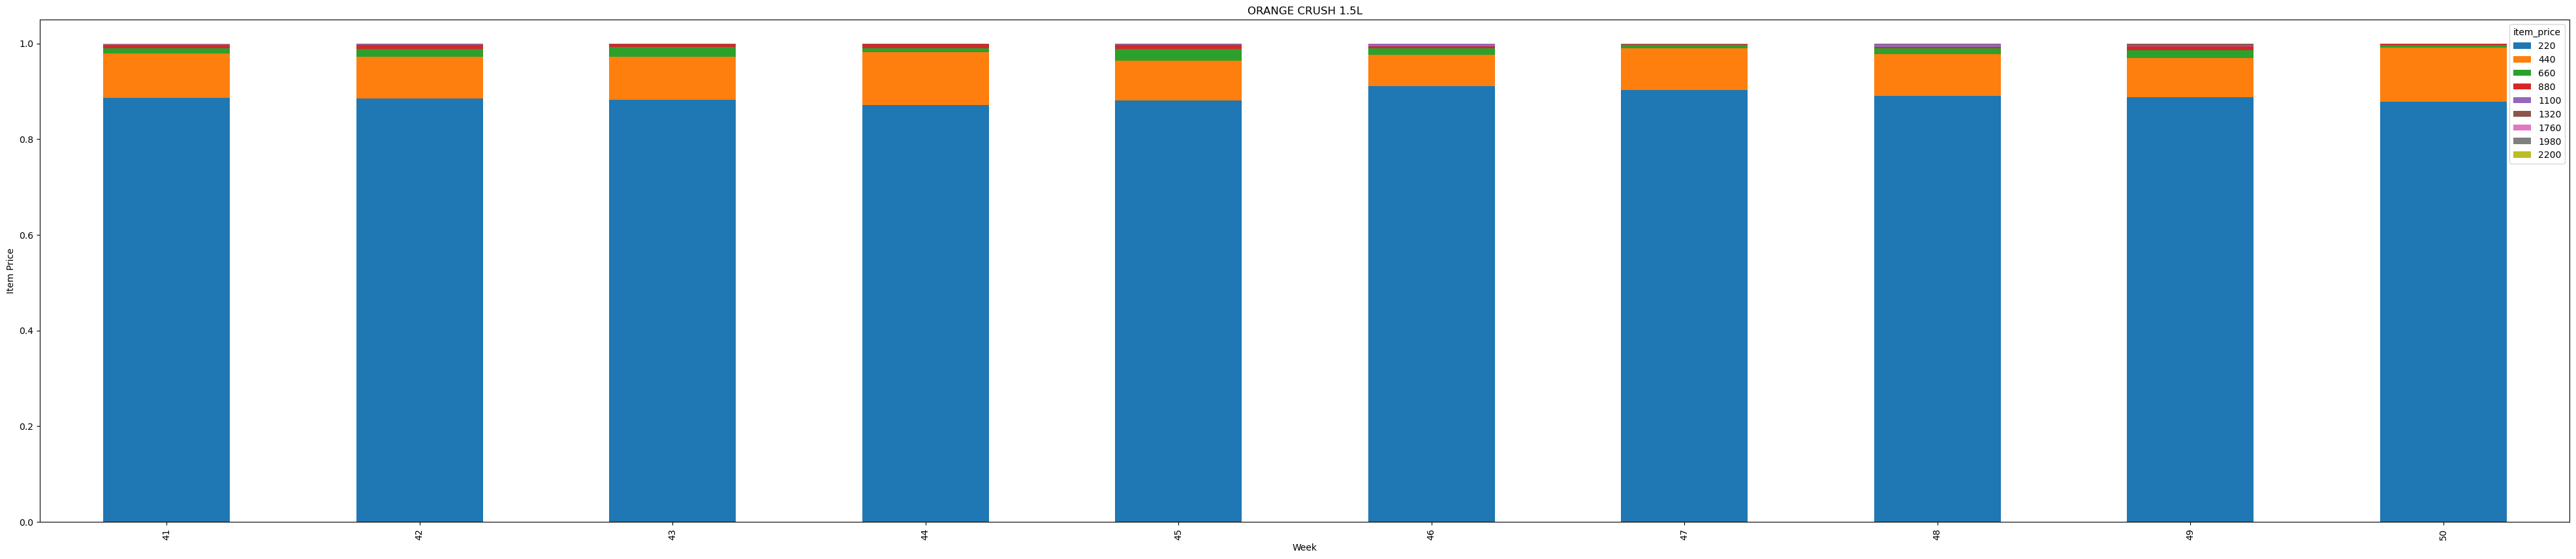

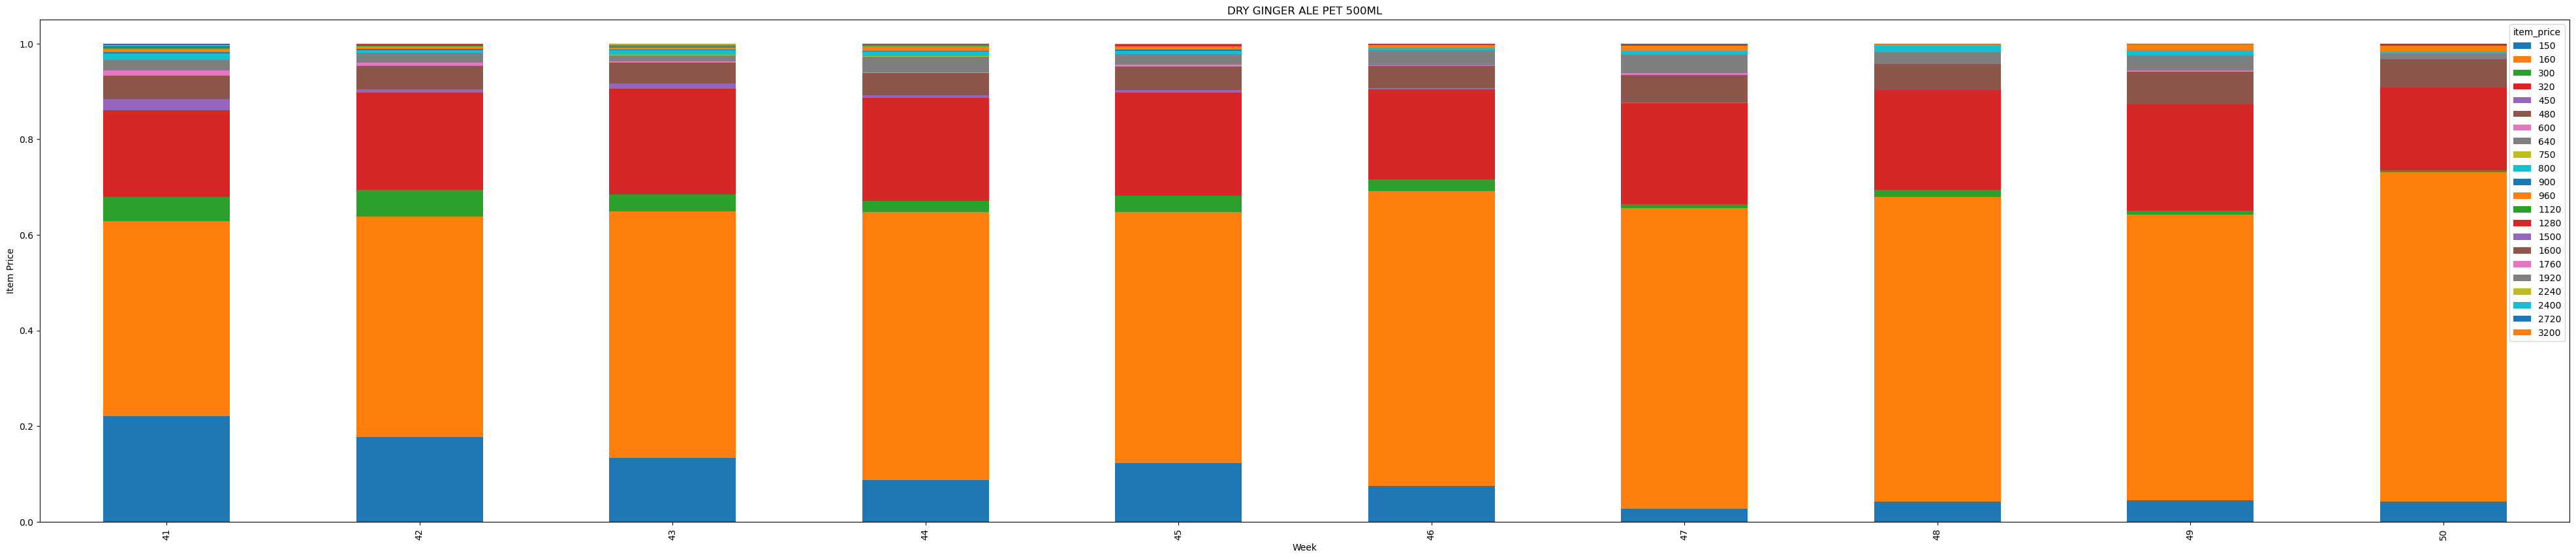

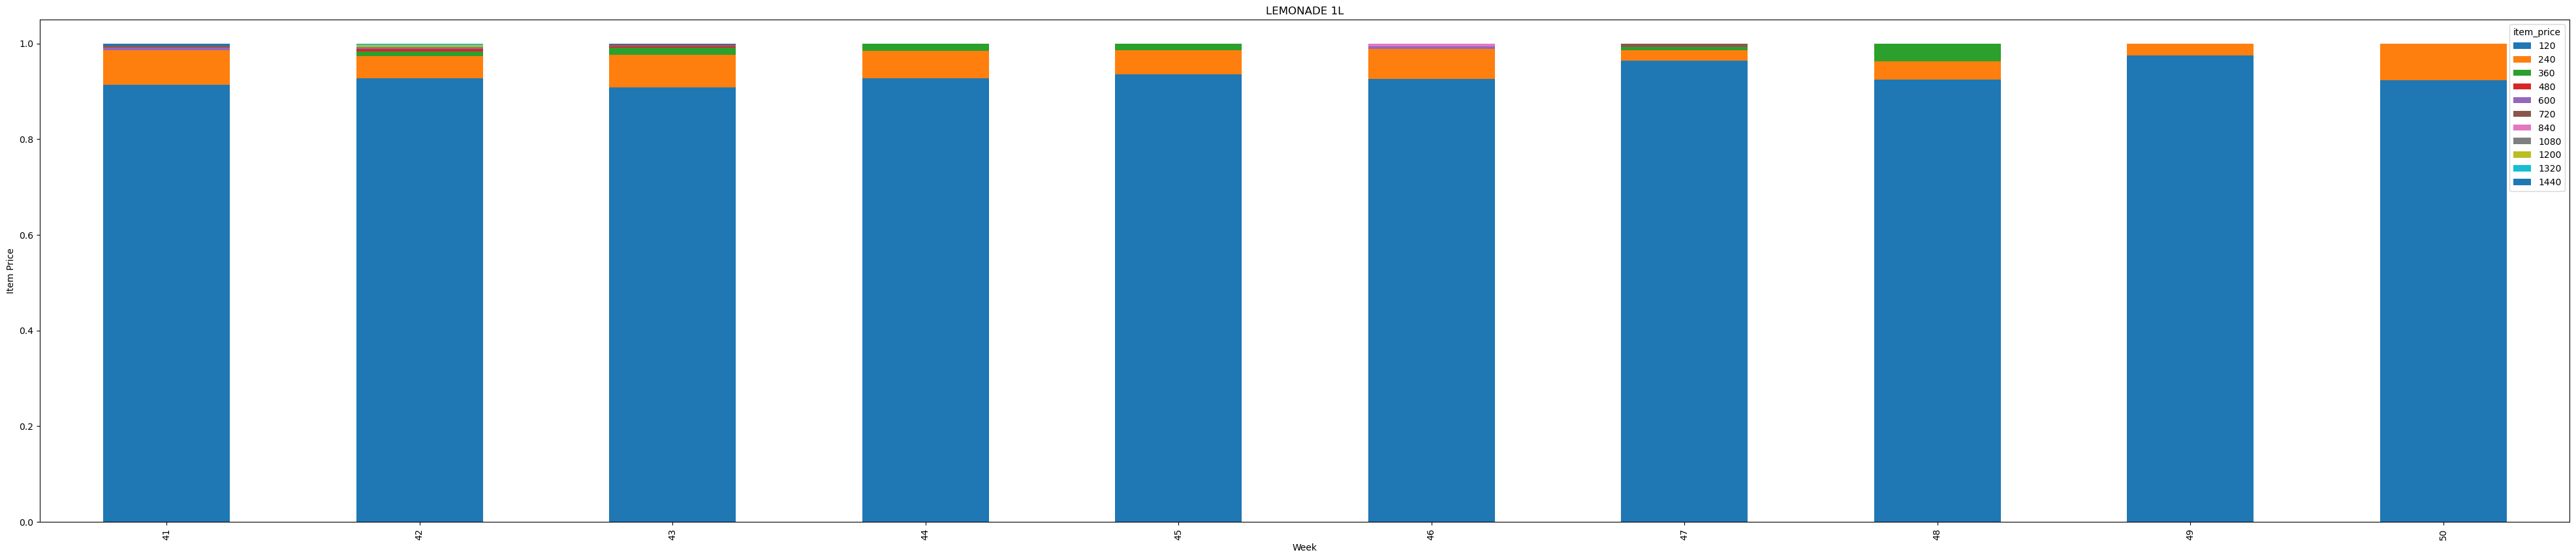

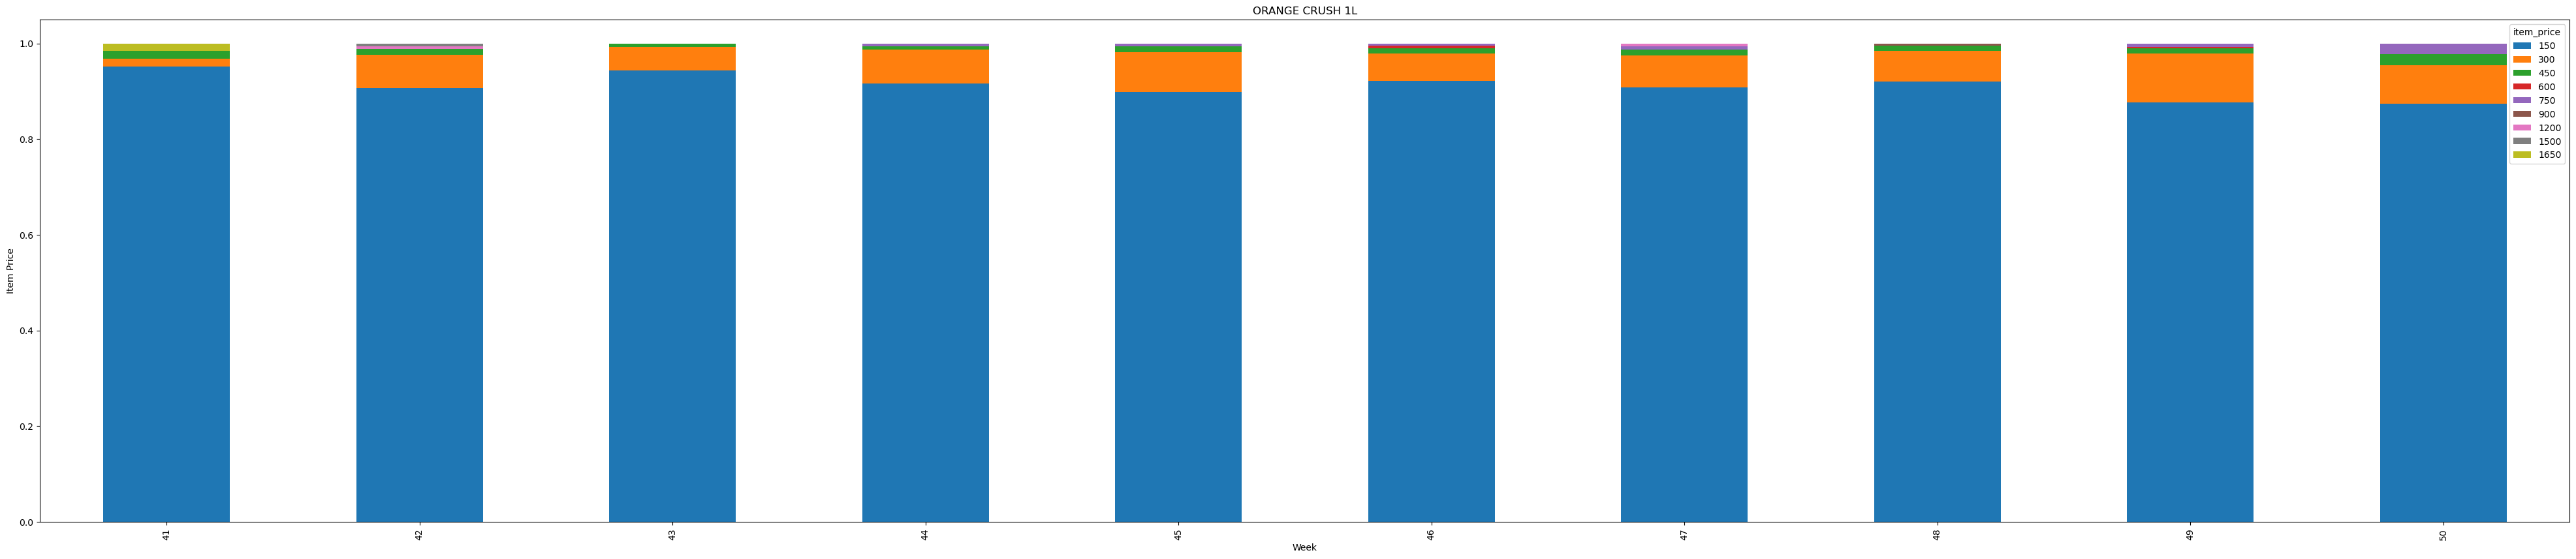

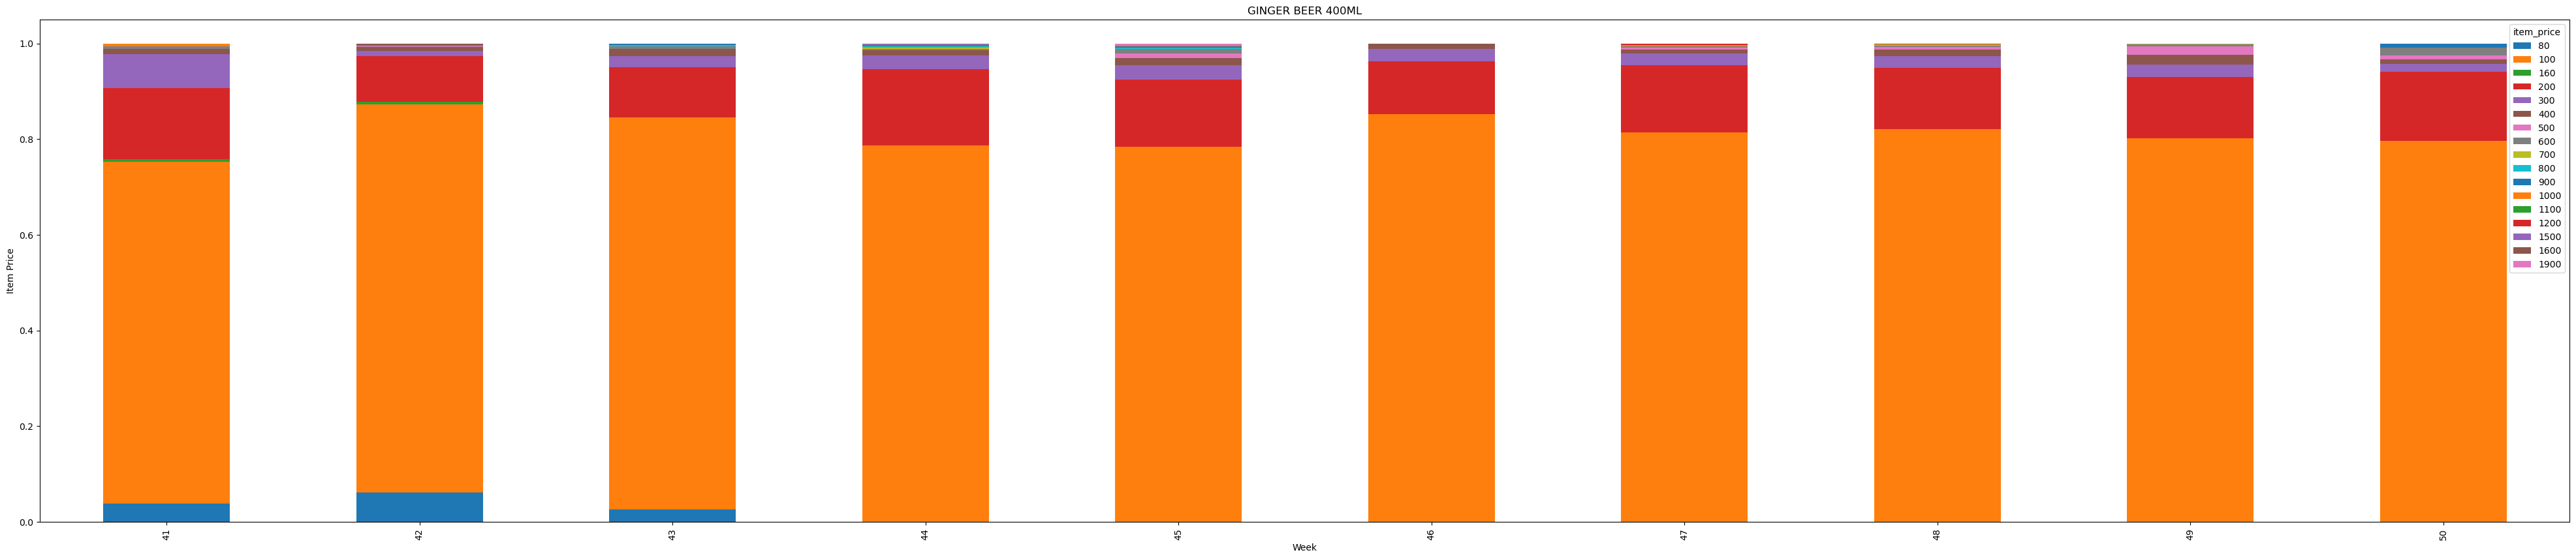

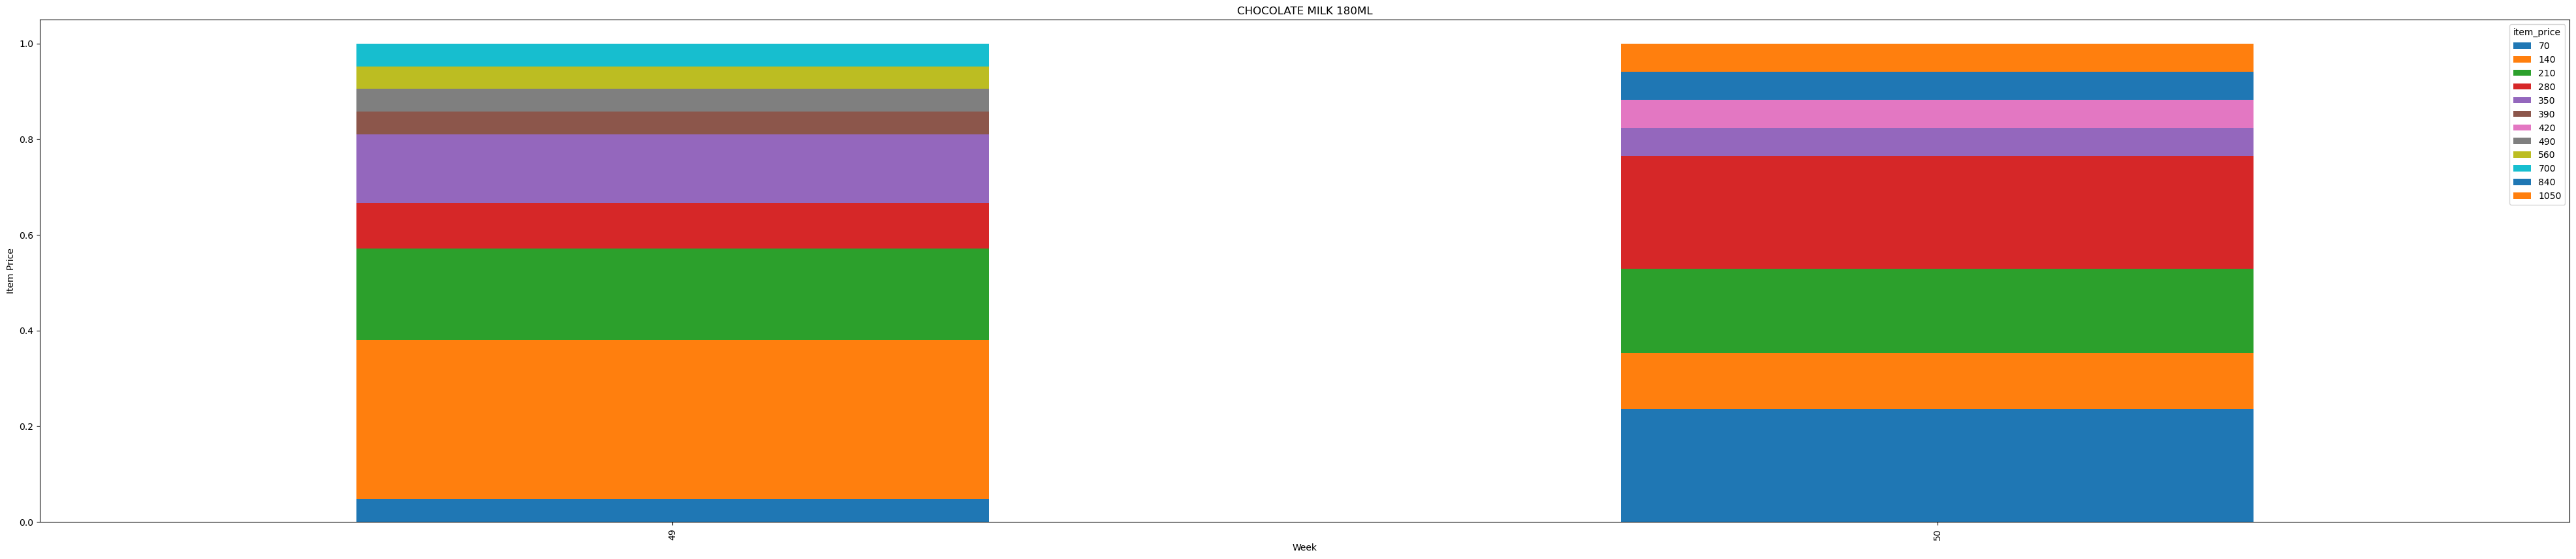

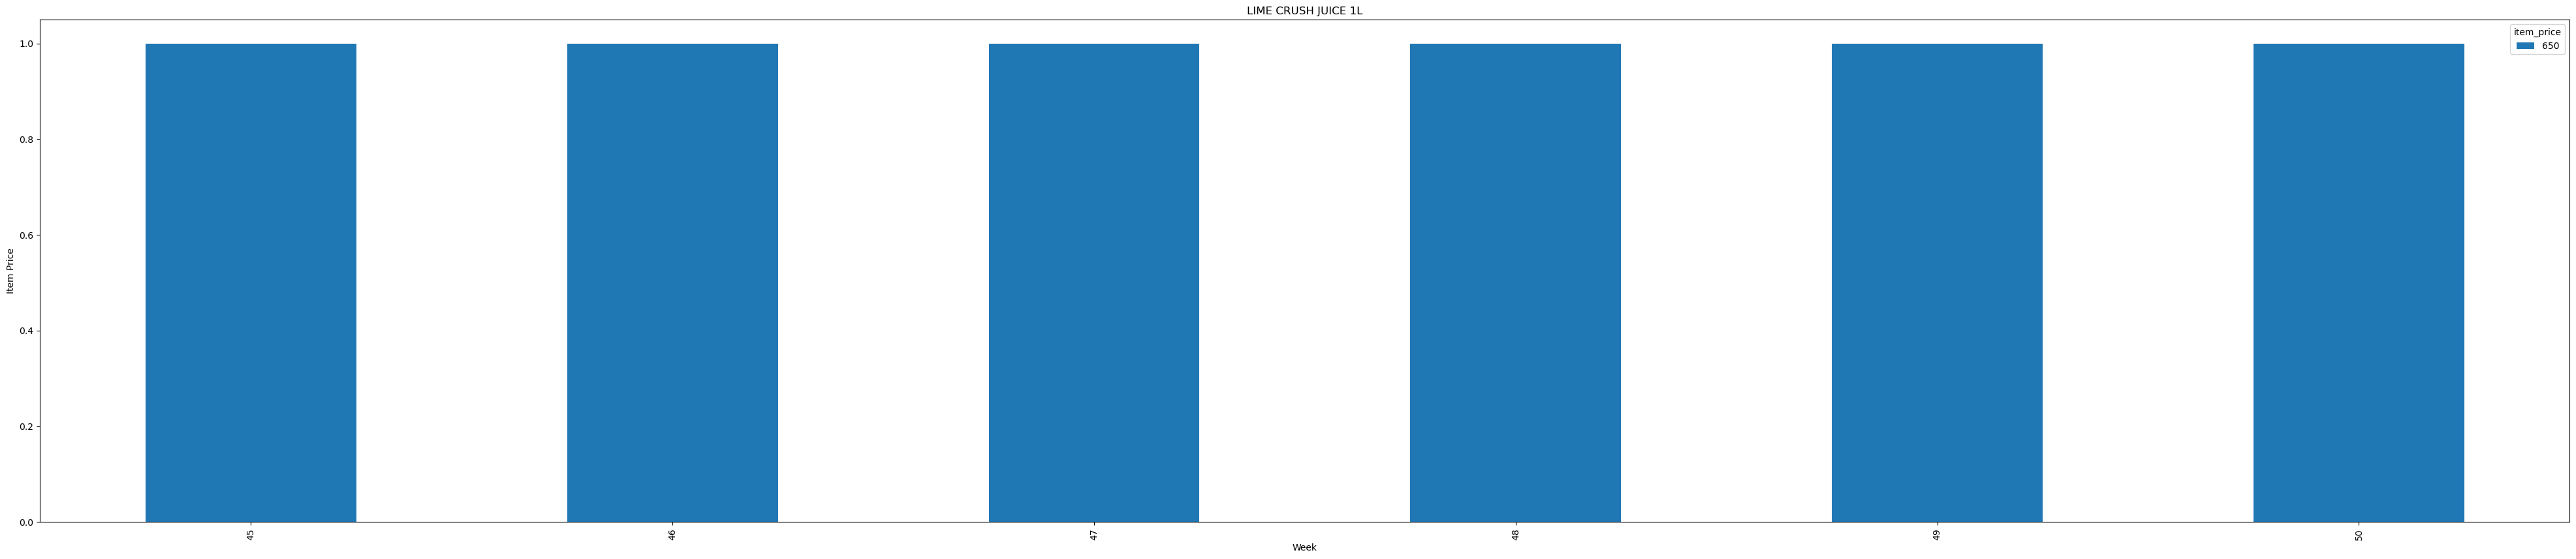

In [59]:
df2=df.dropna(subset=['item_description'], axis=0)
weekly_prices(df2['item_description'].unique())

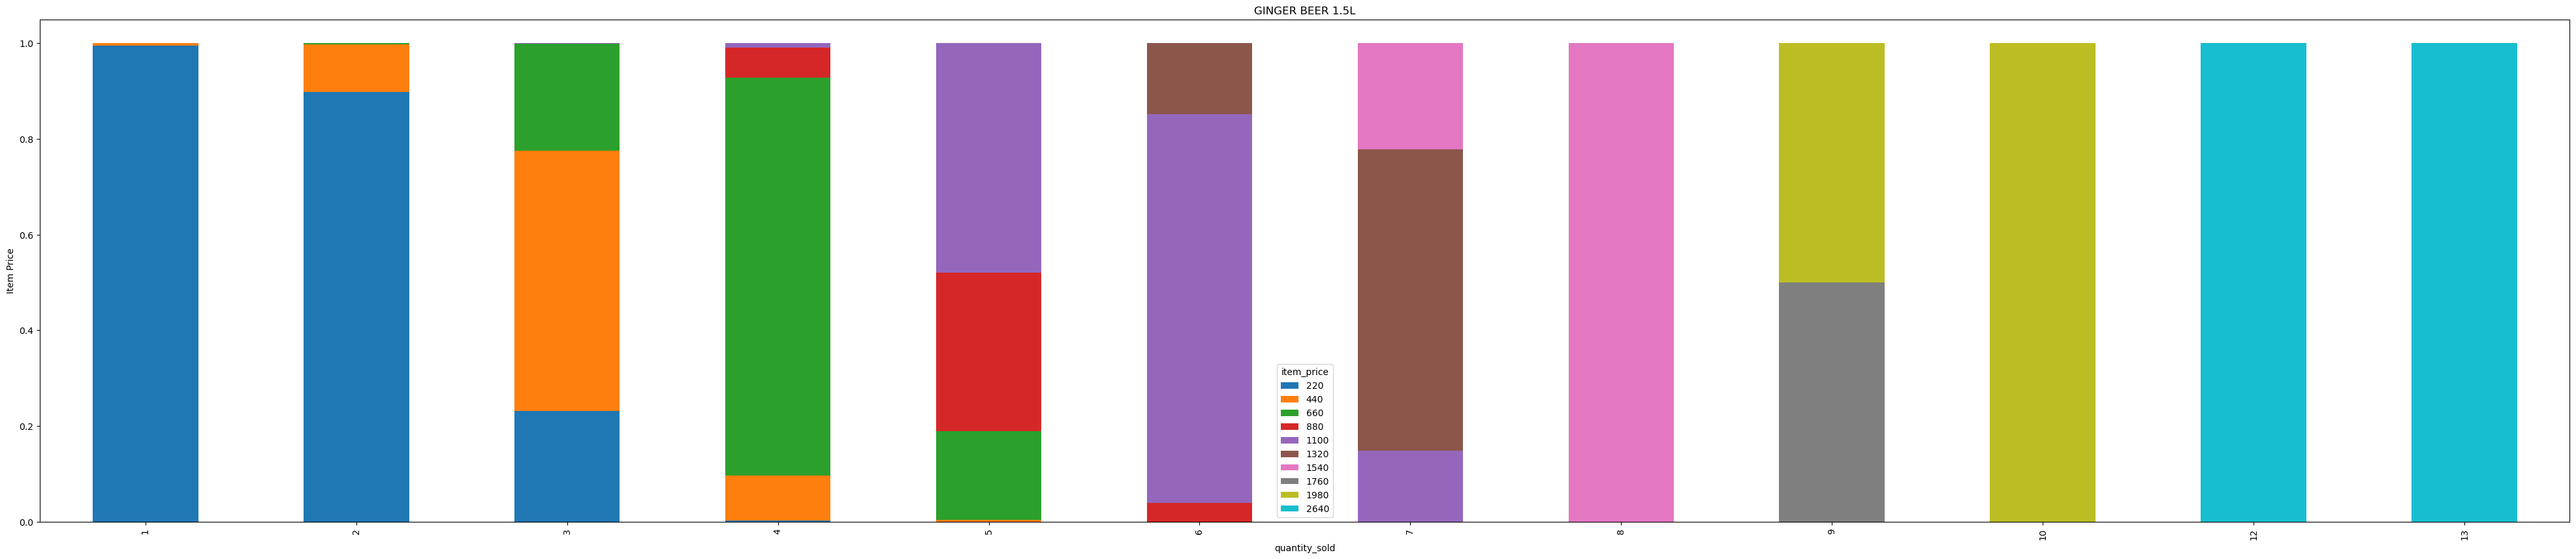

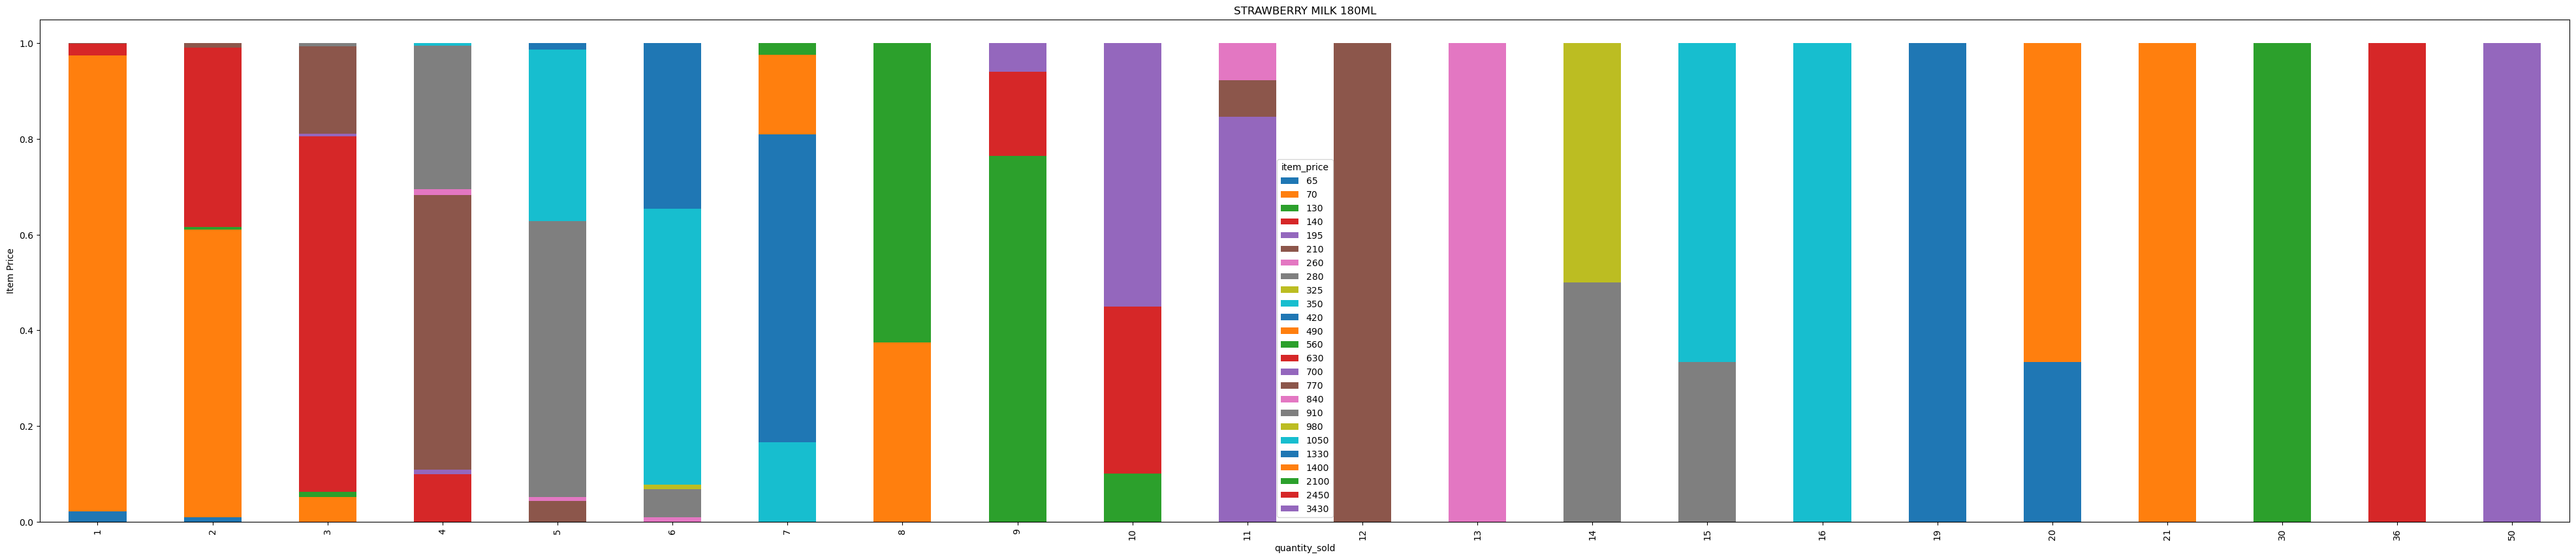

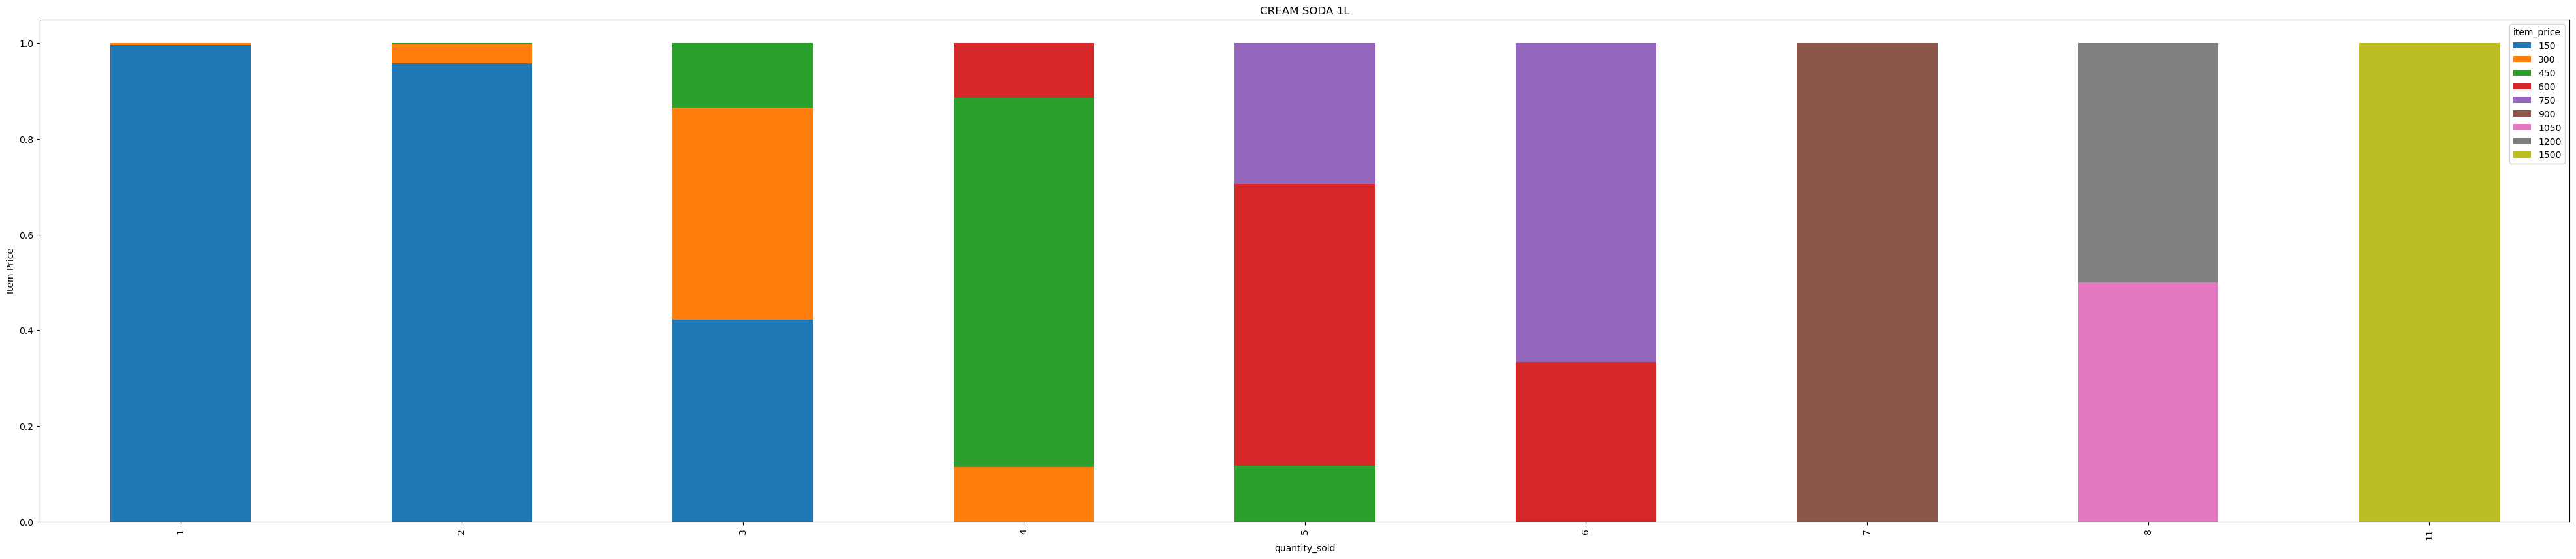

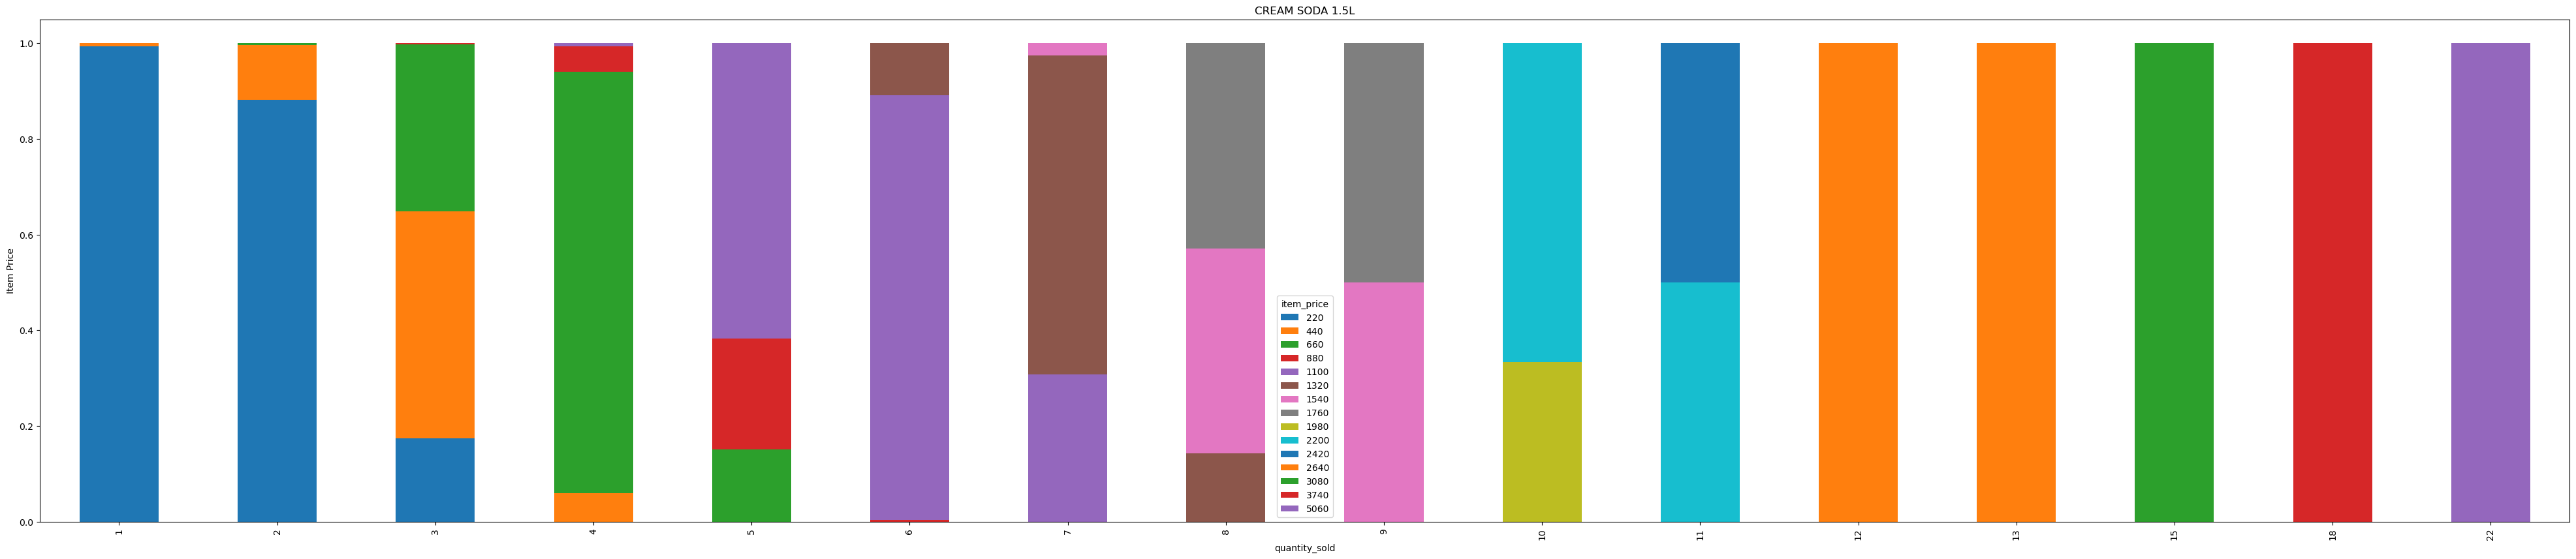

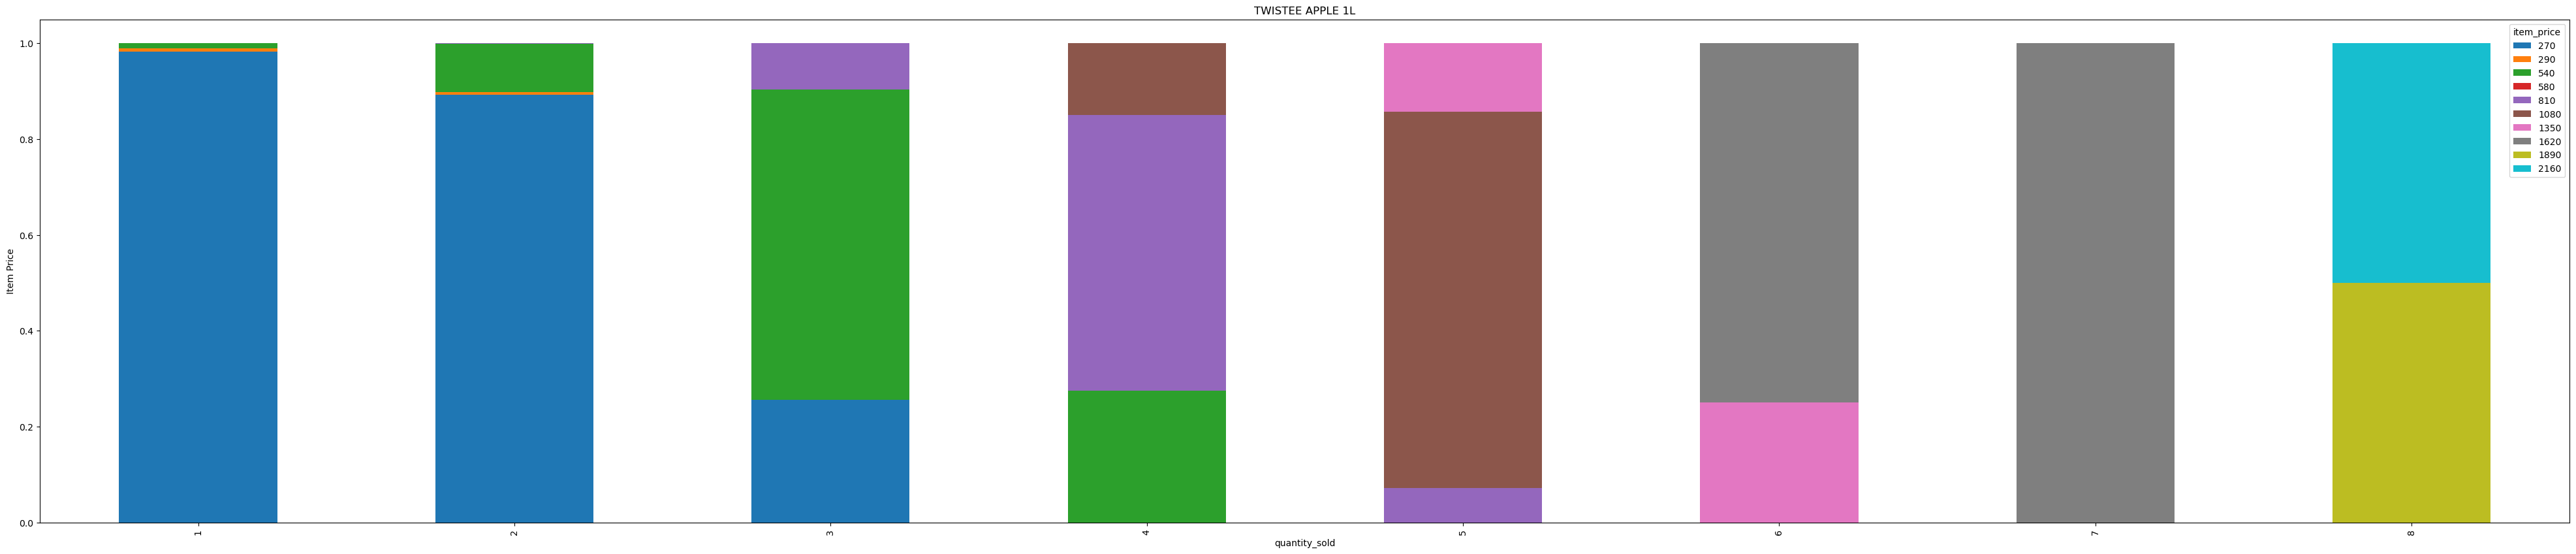

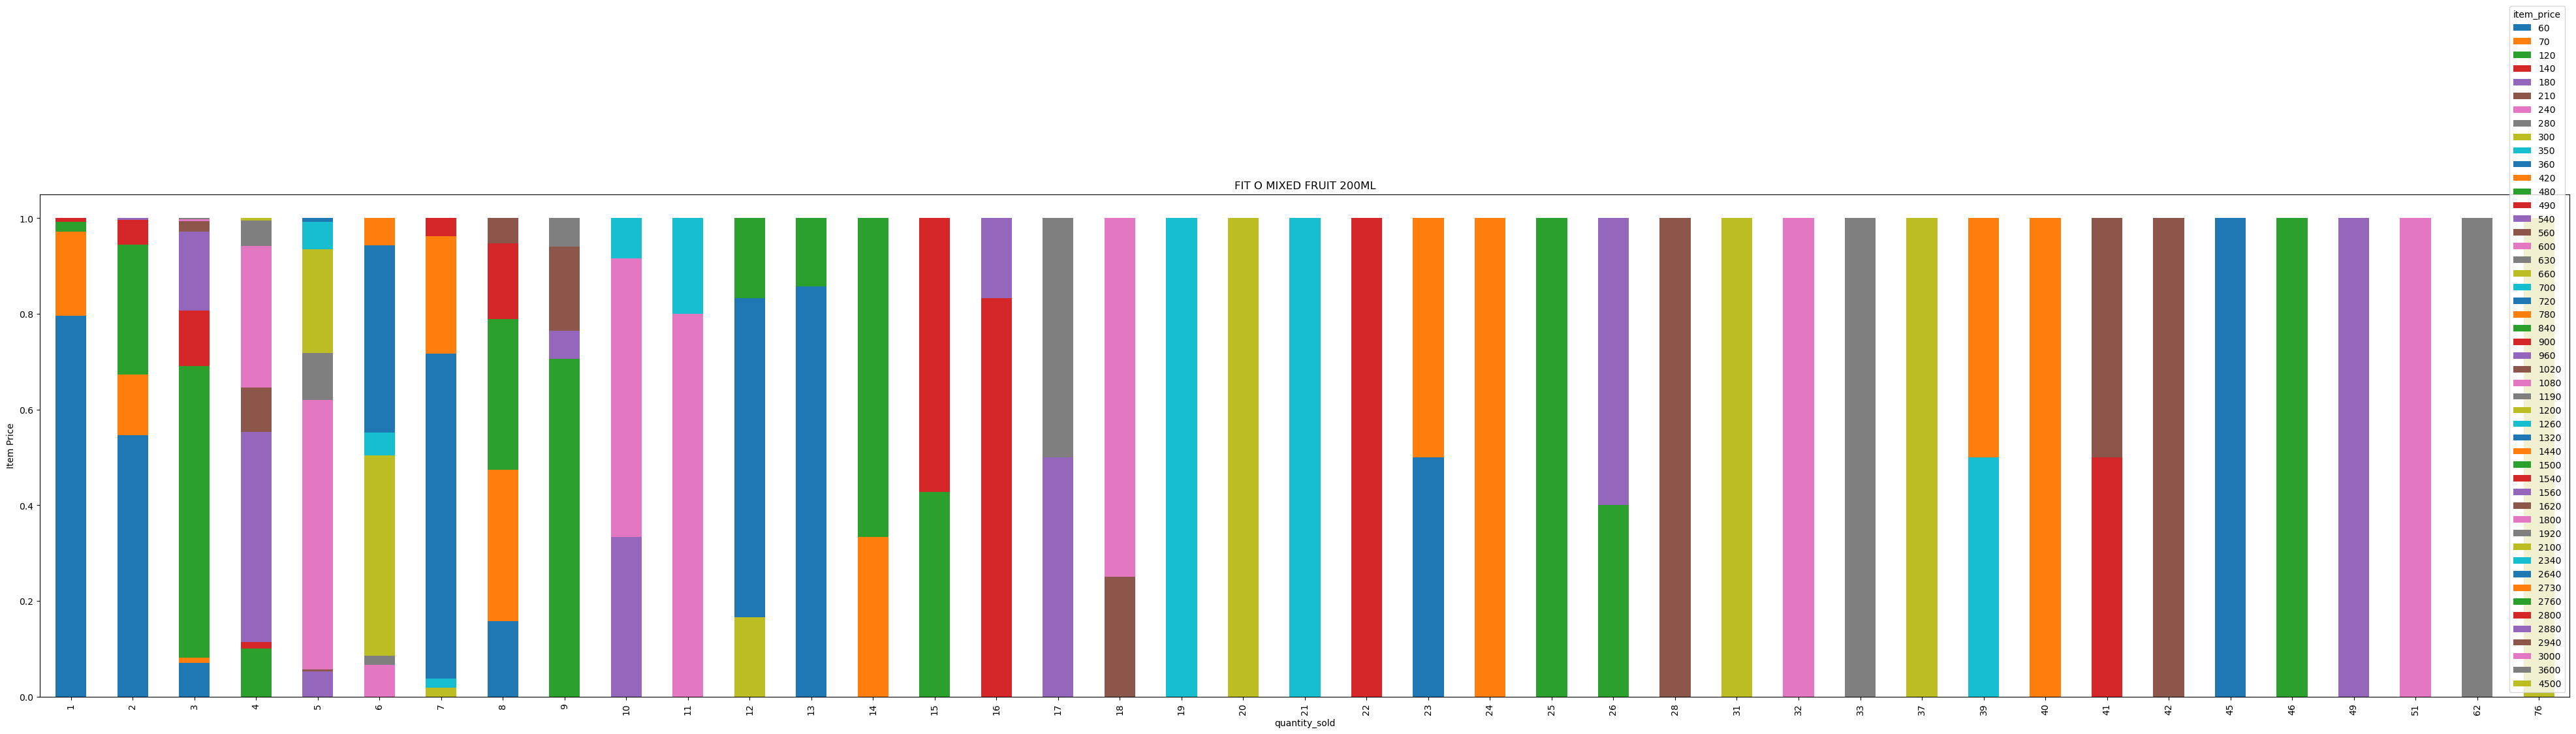

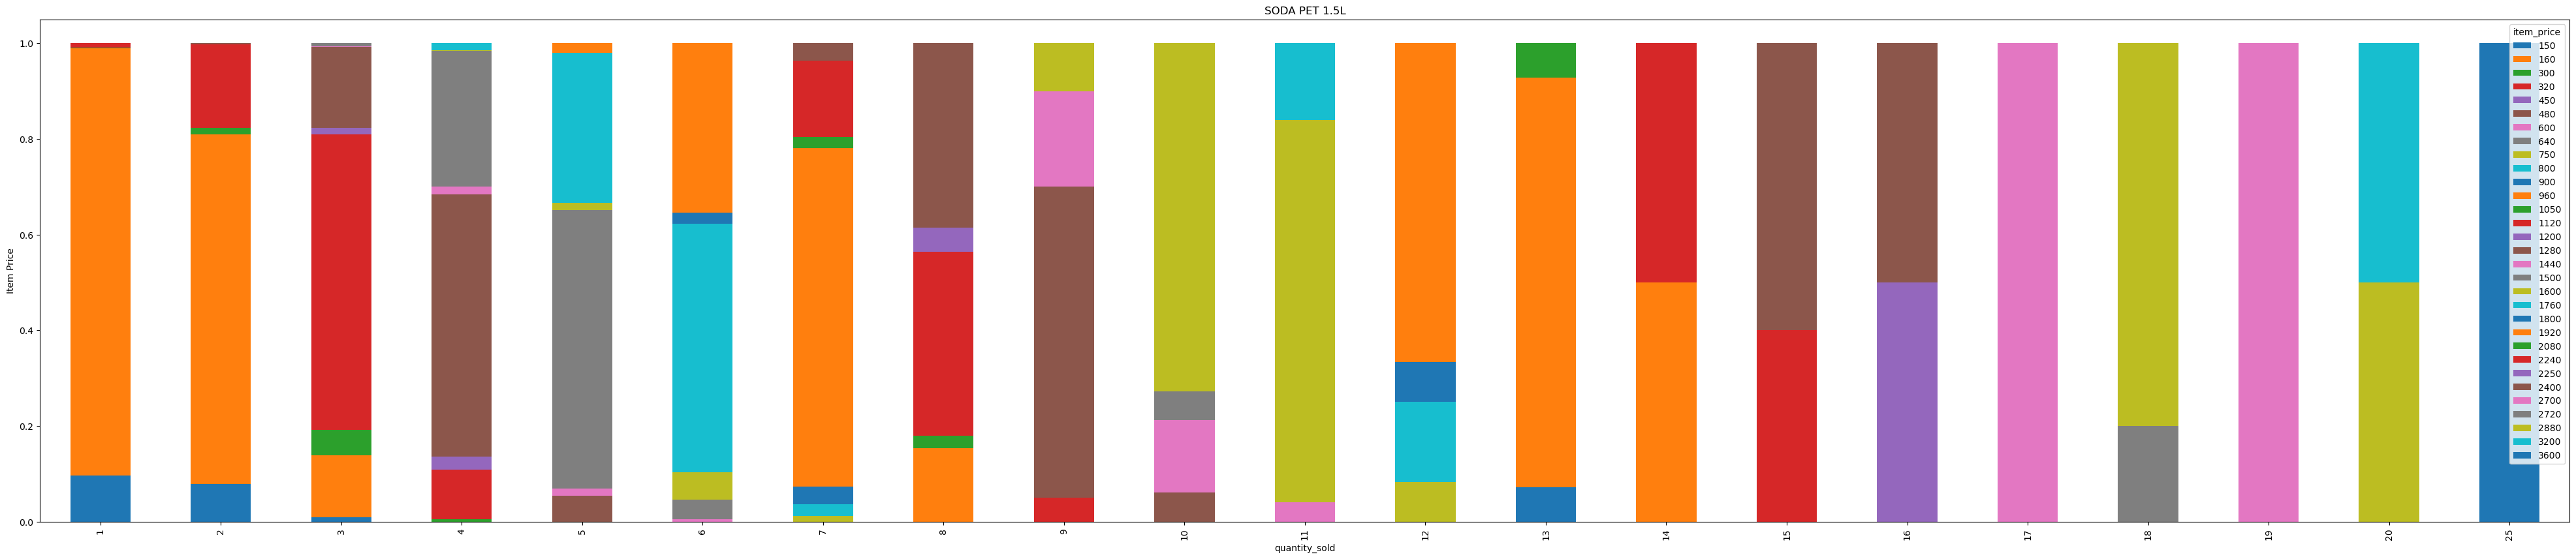

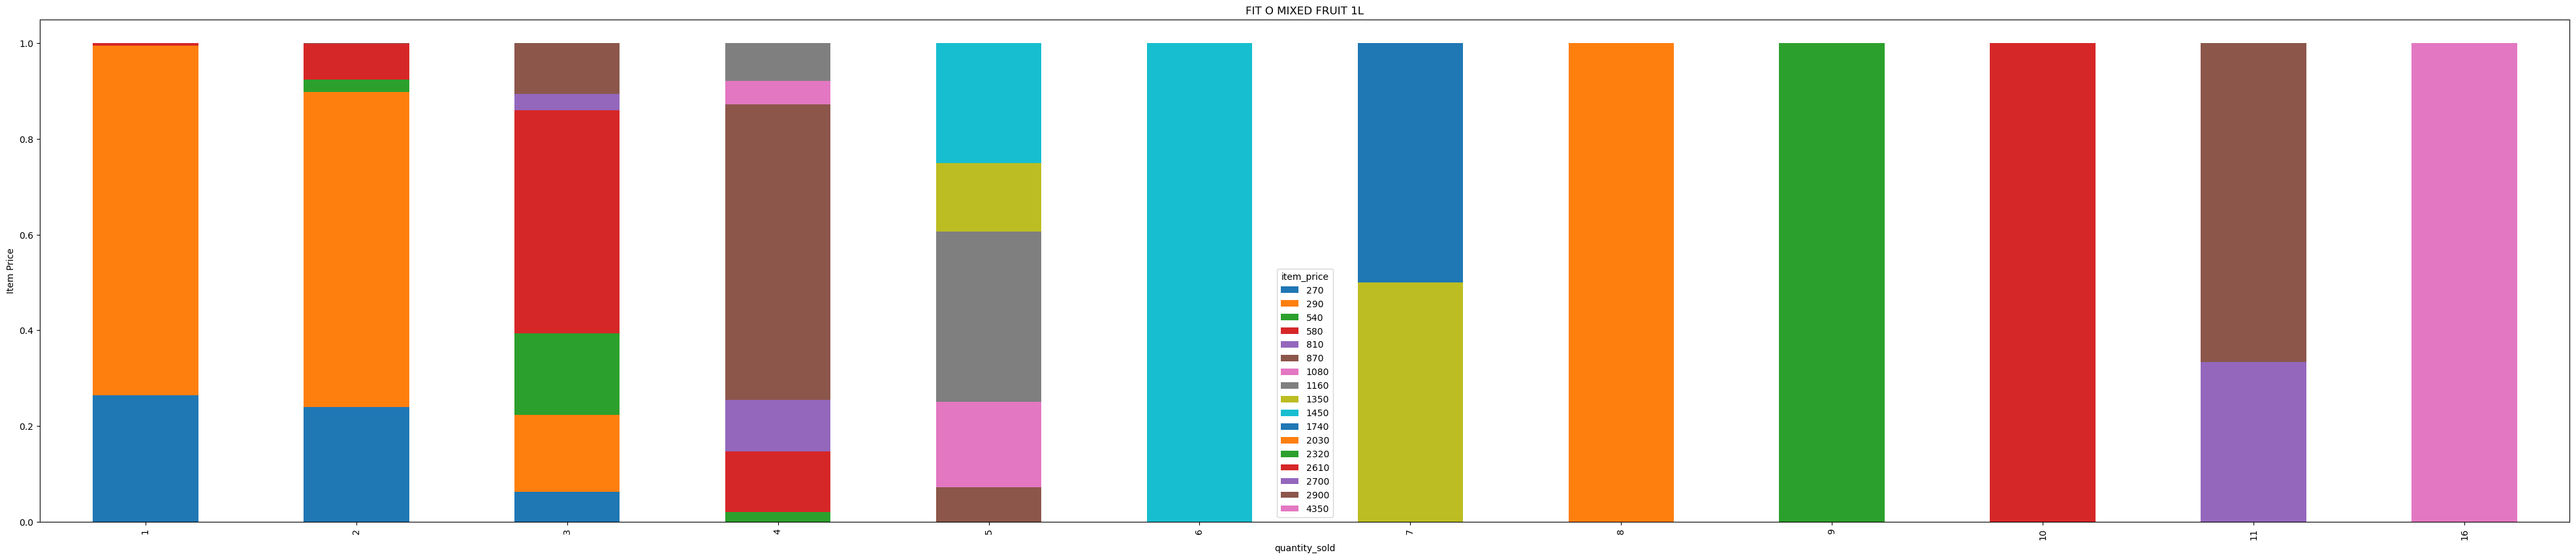

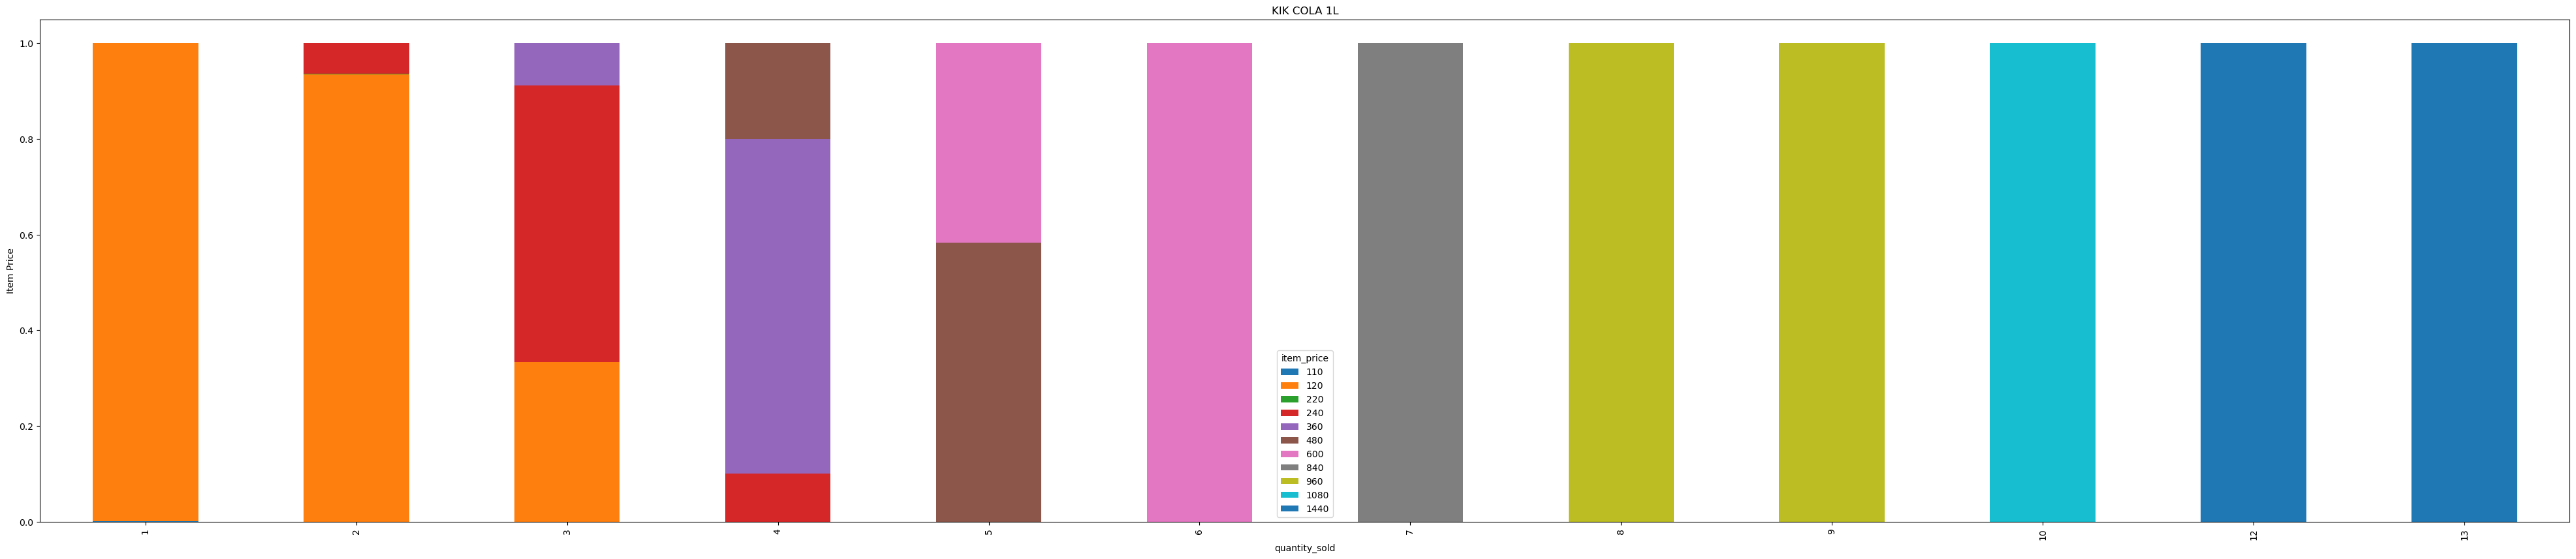

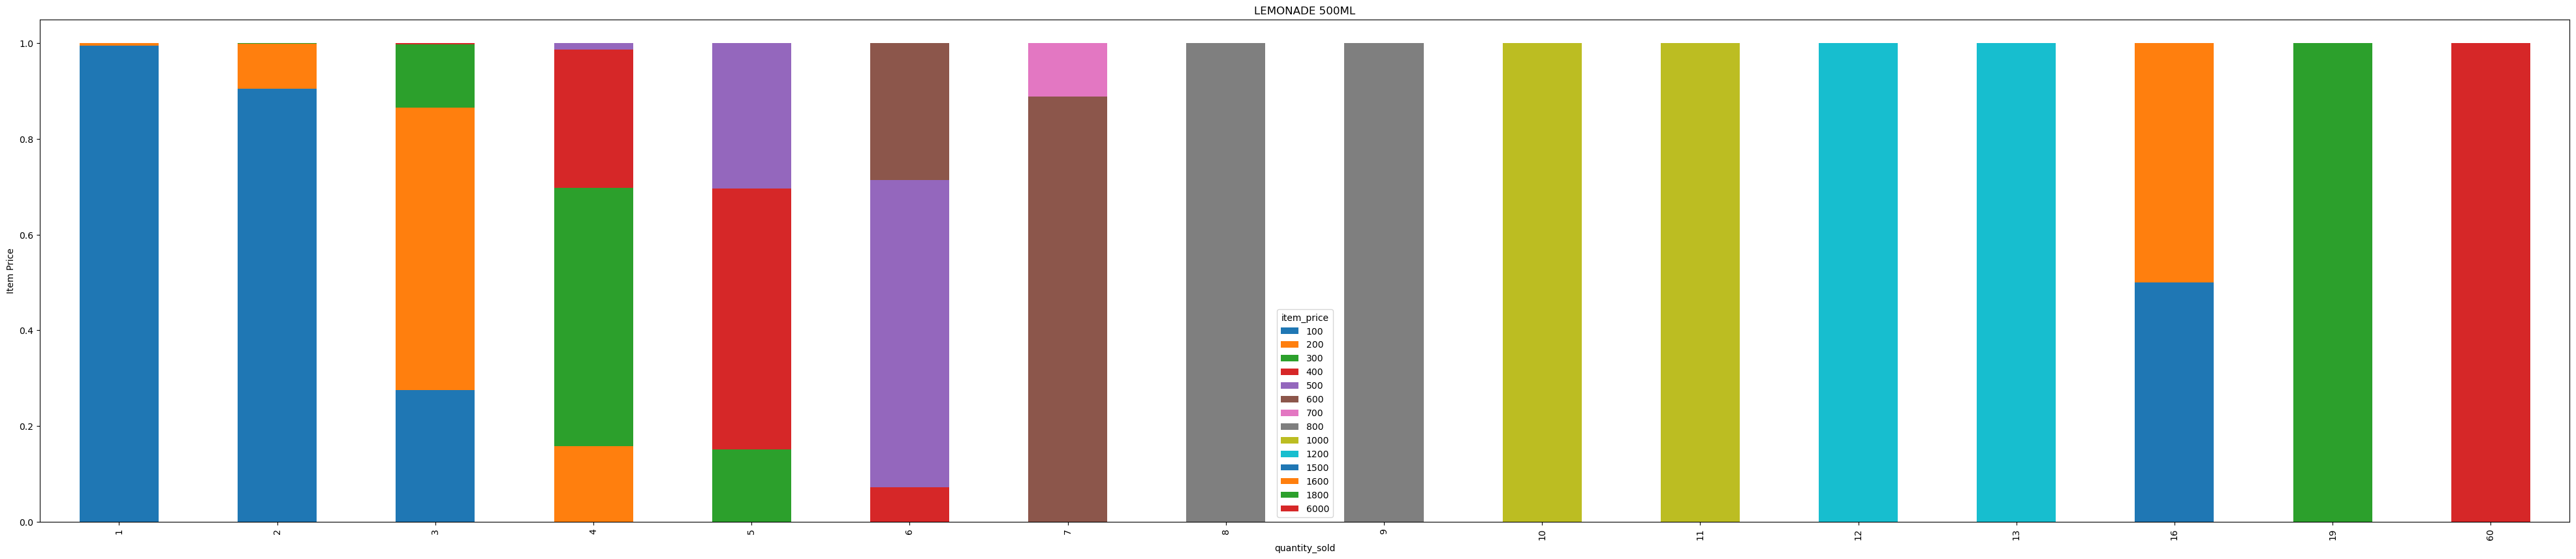

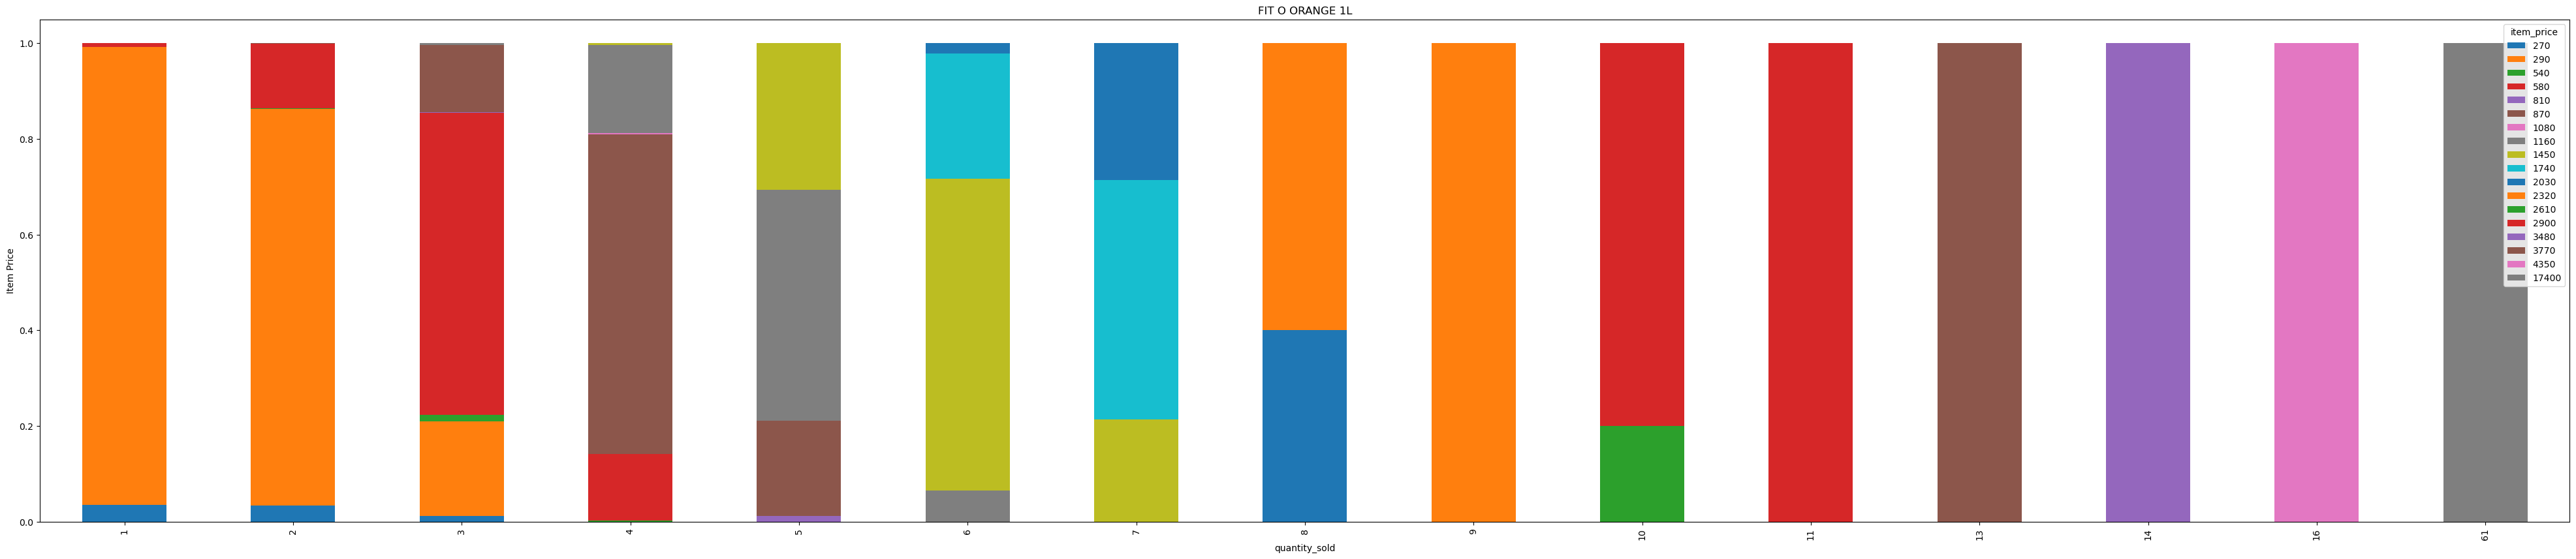

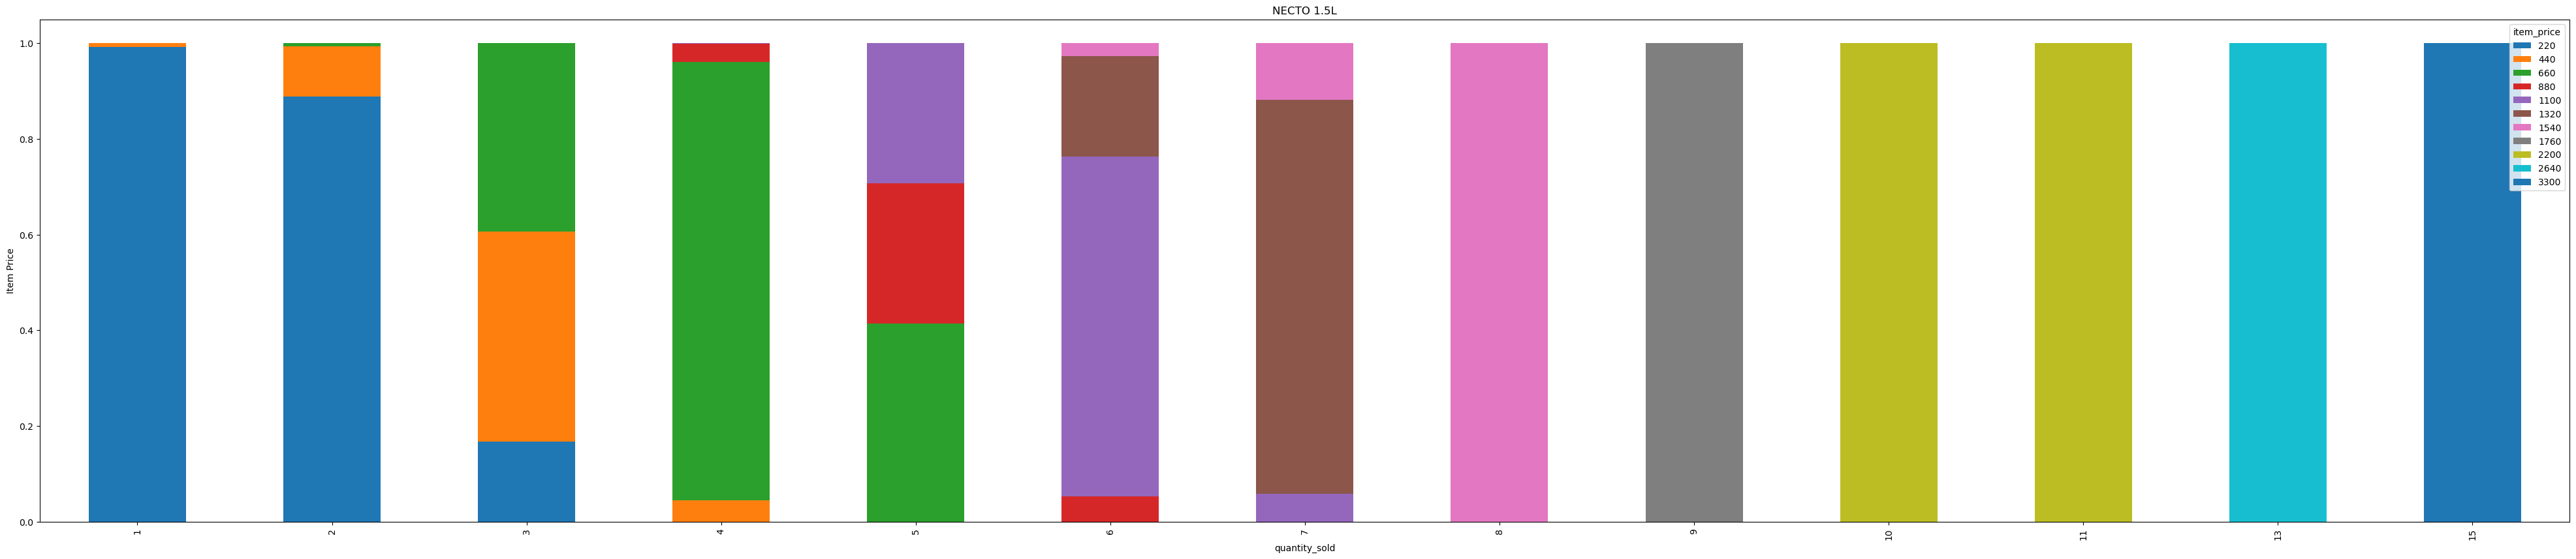

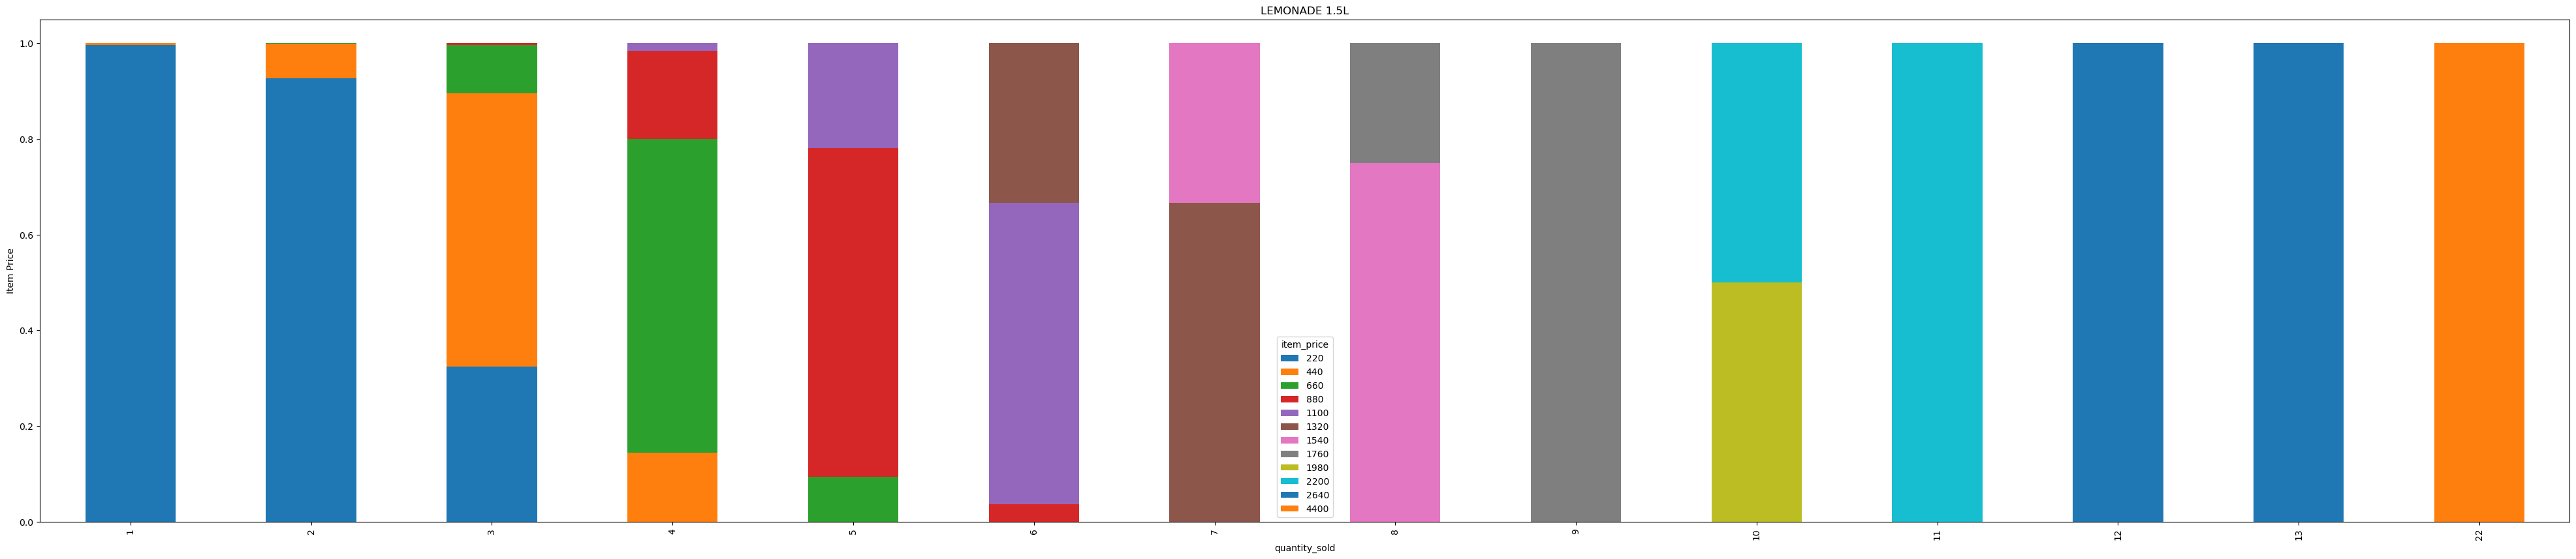

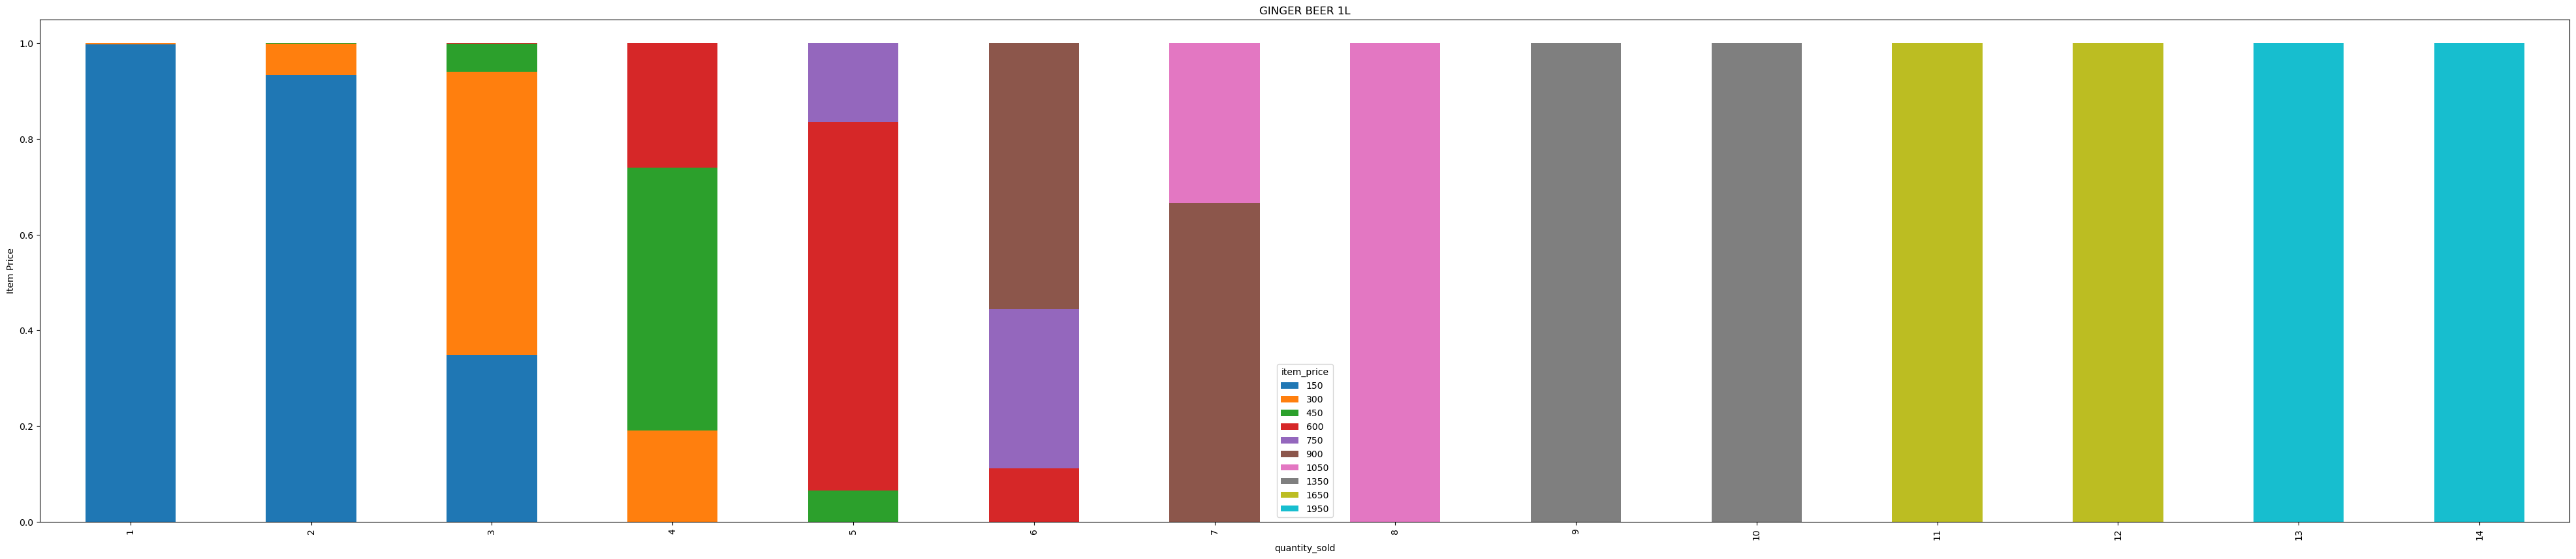

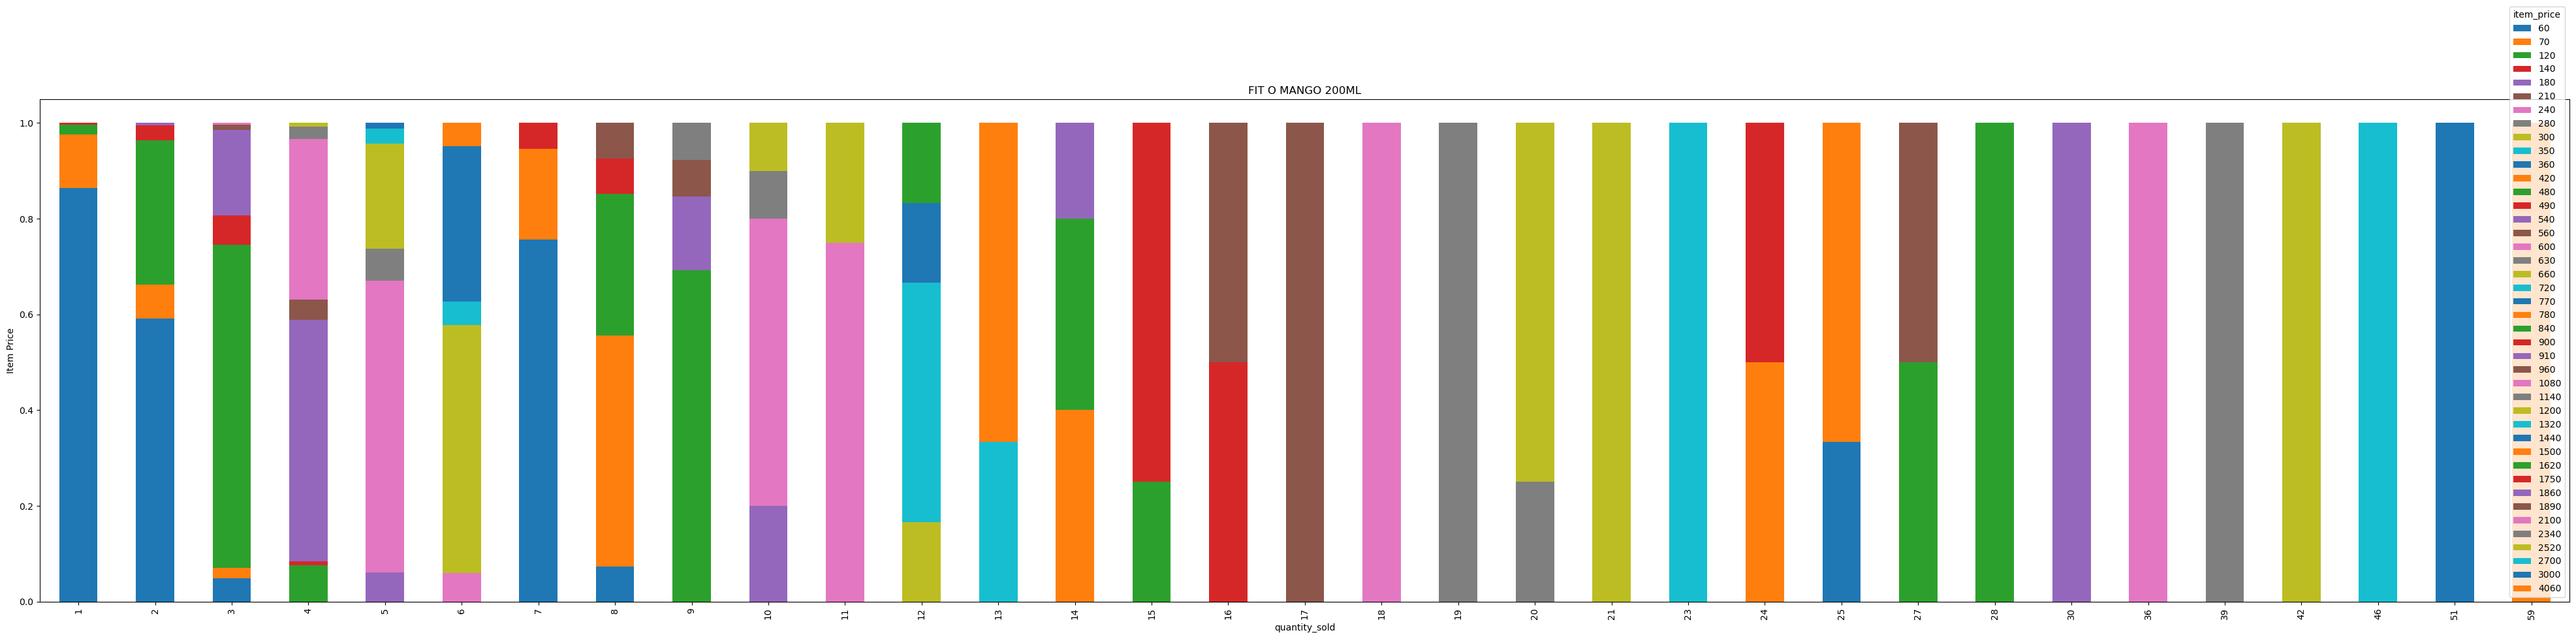

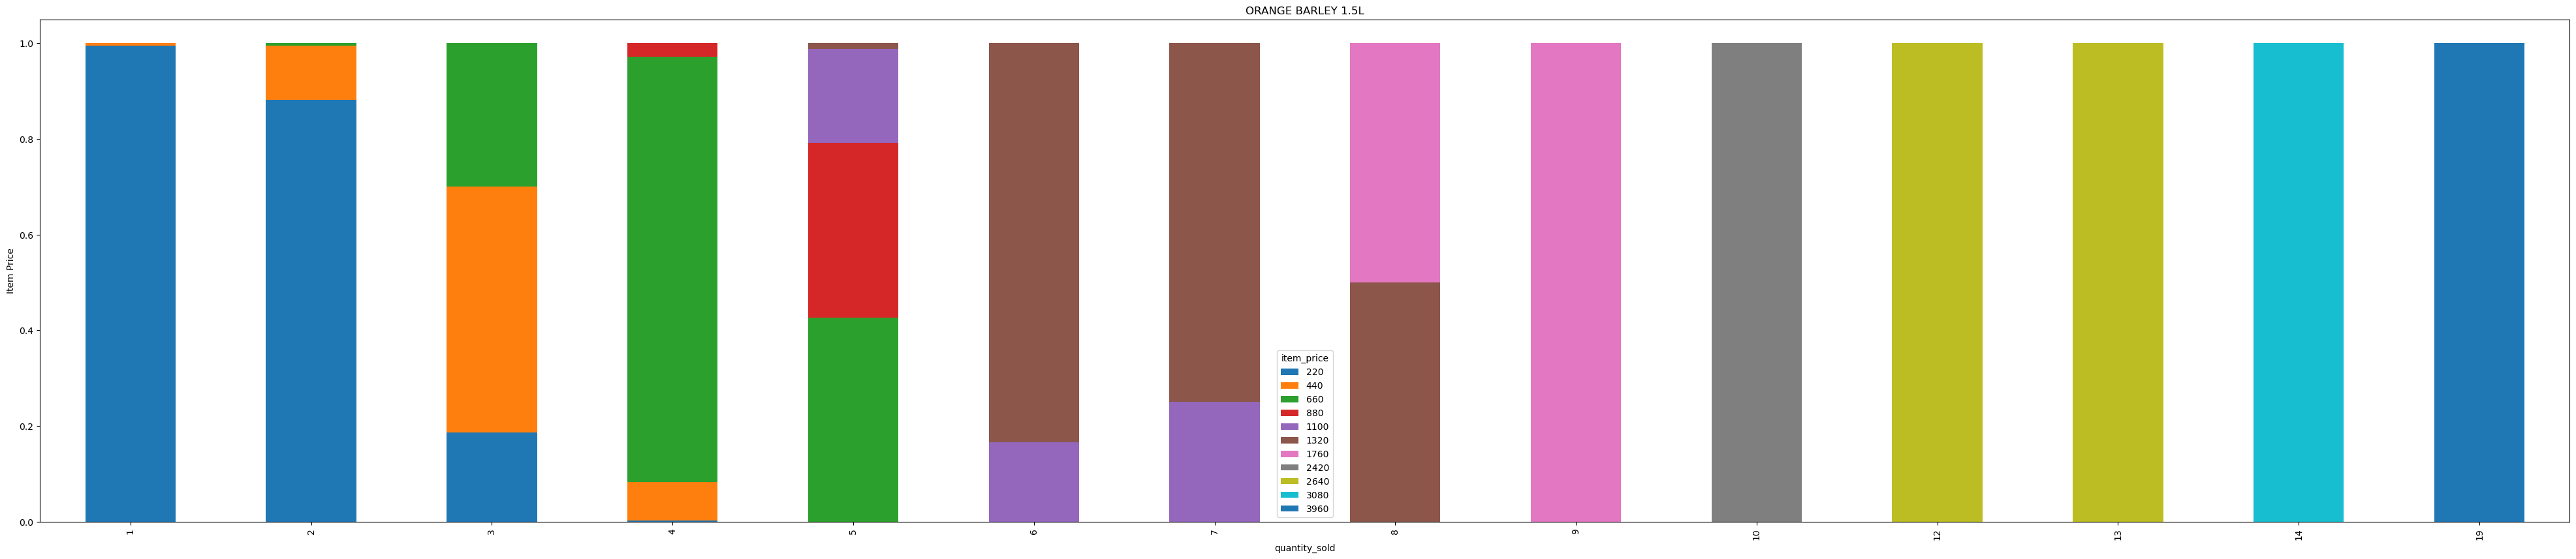

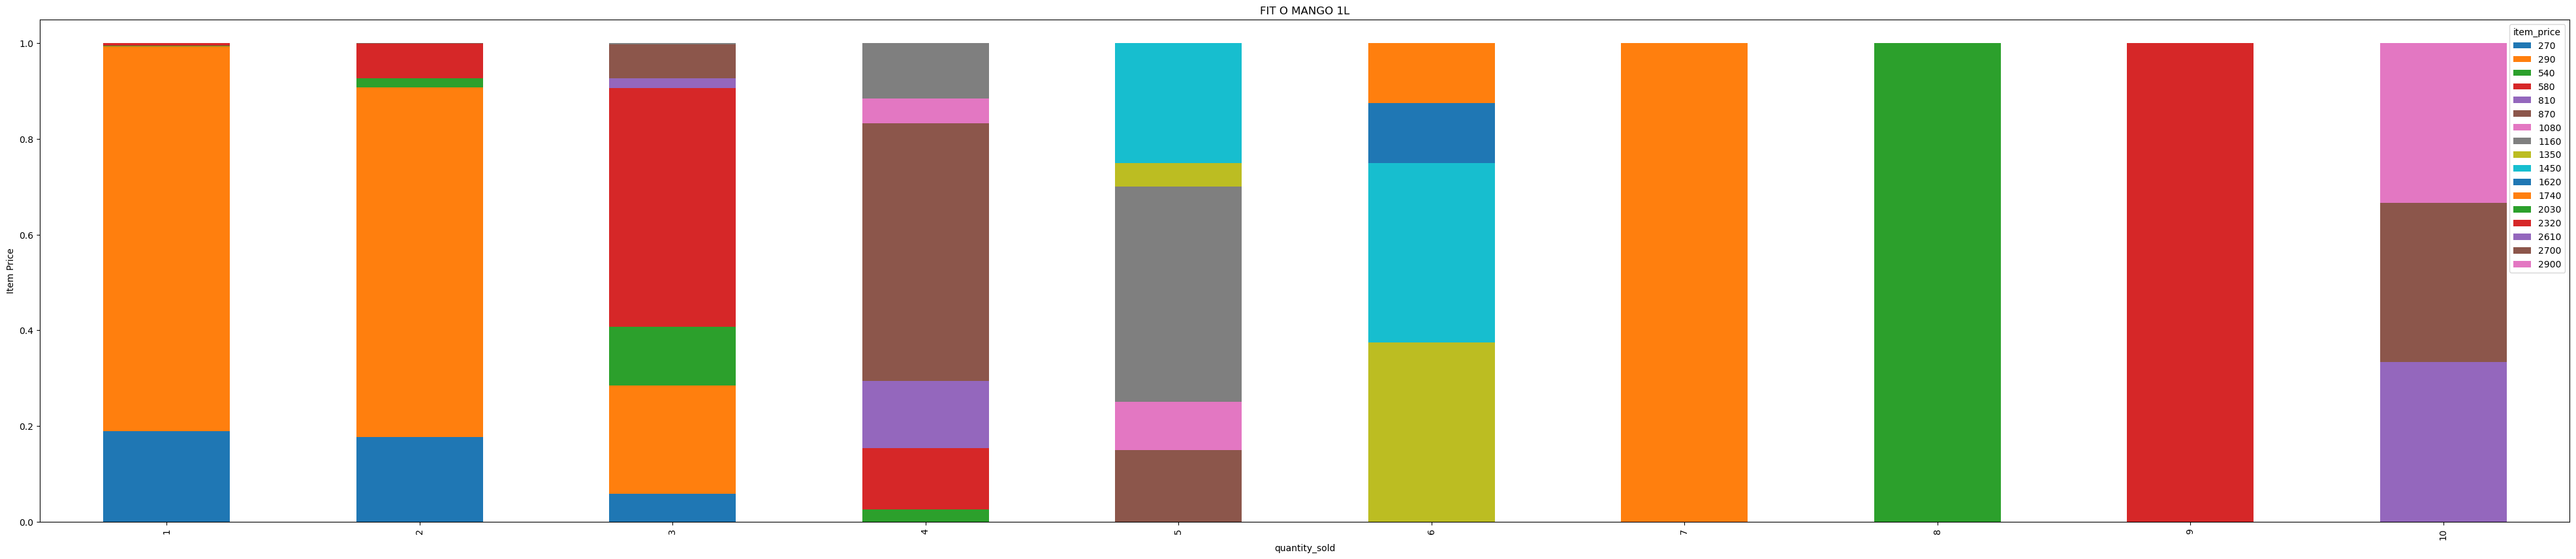

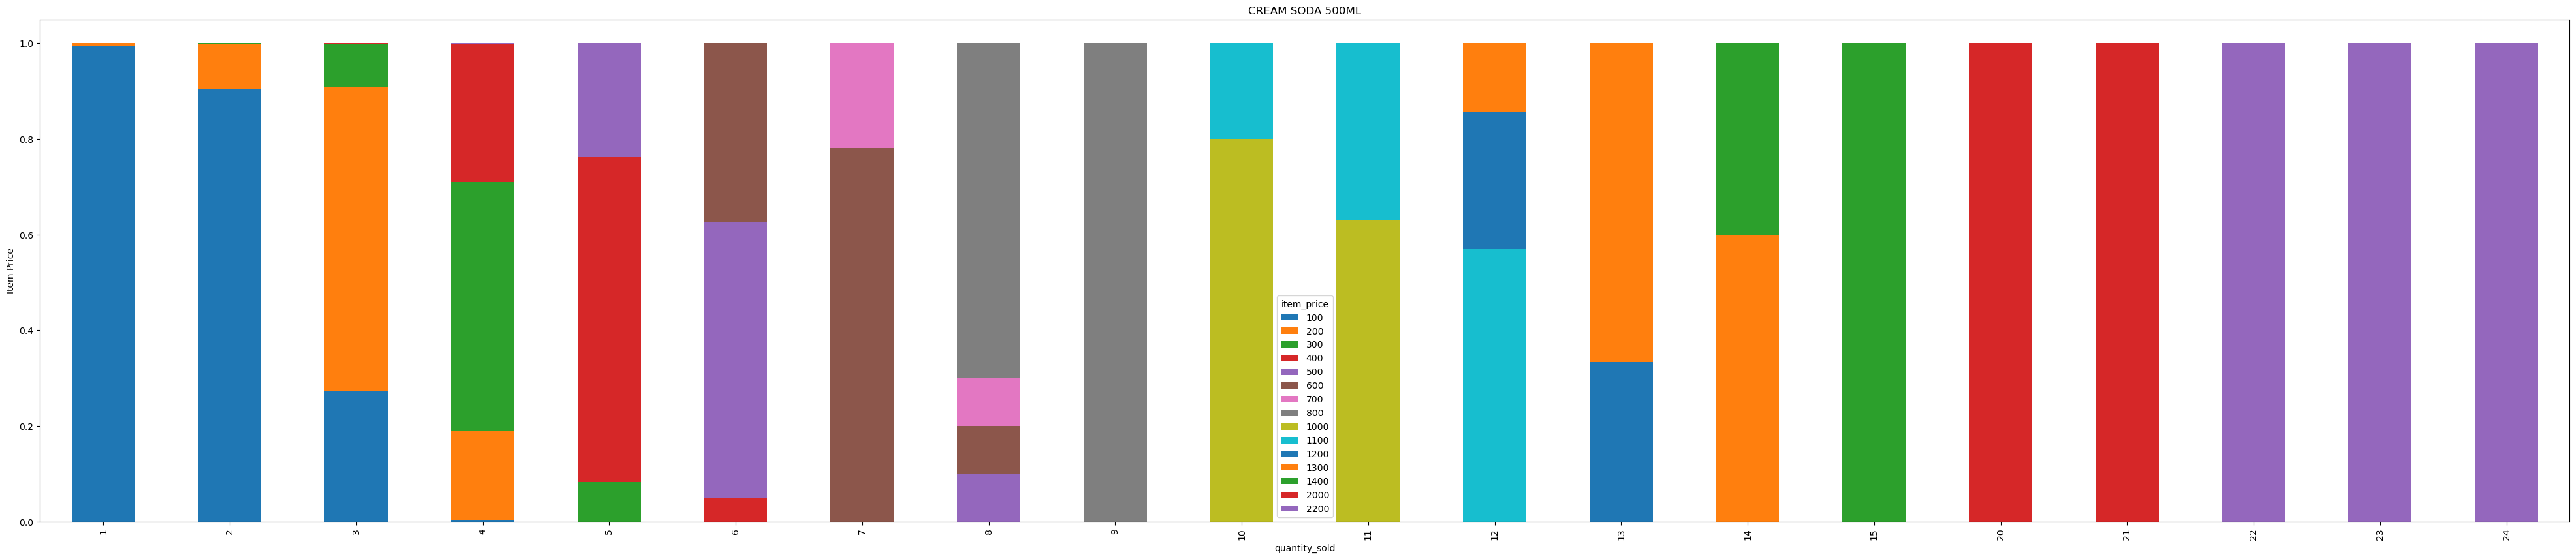

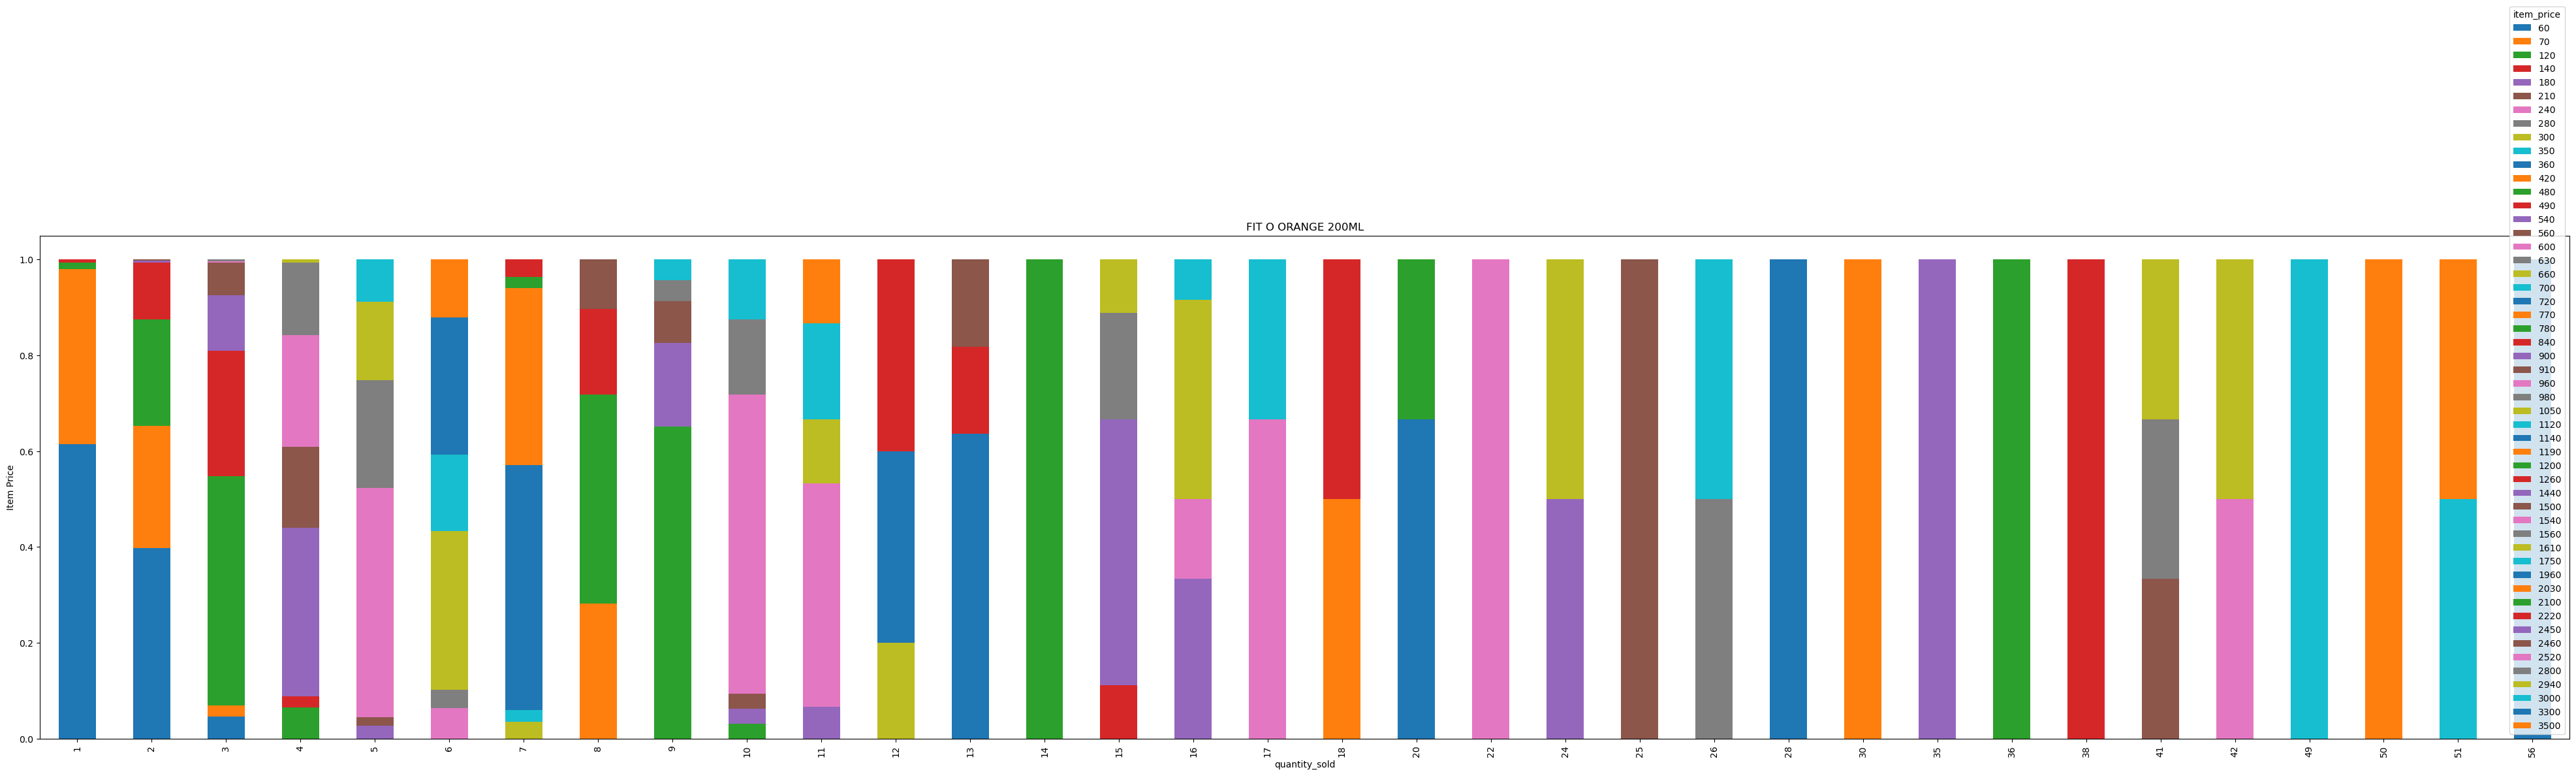

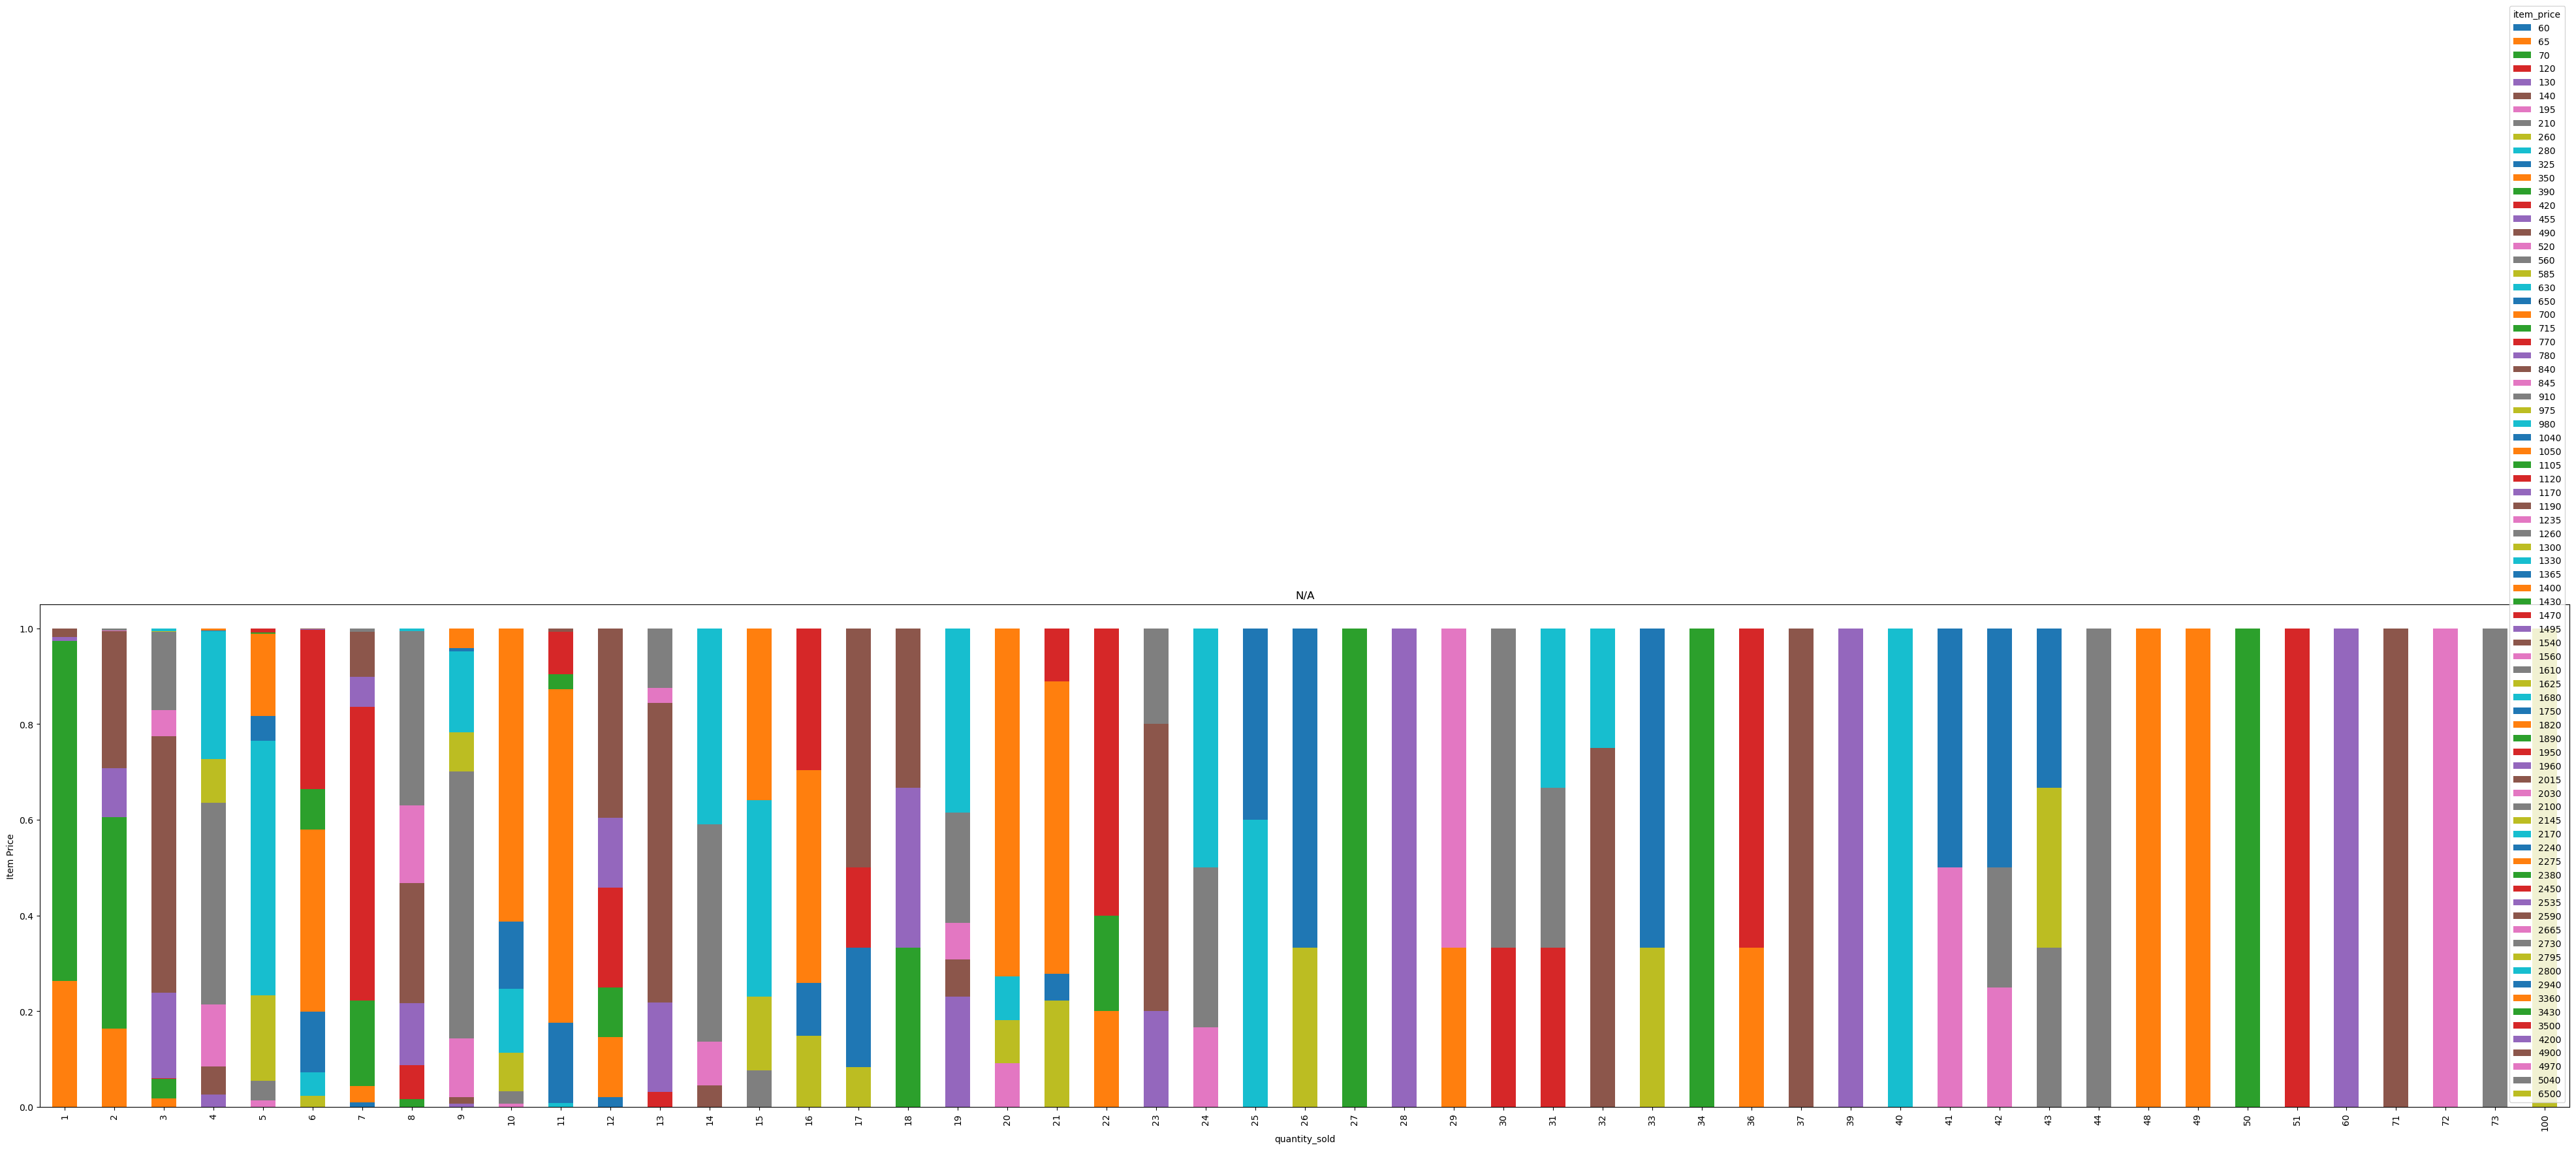

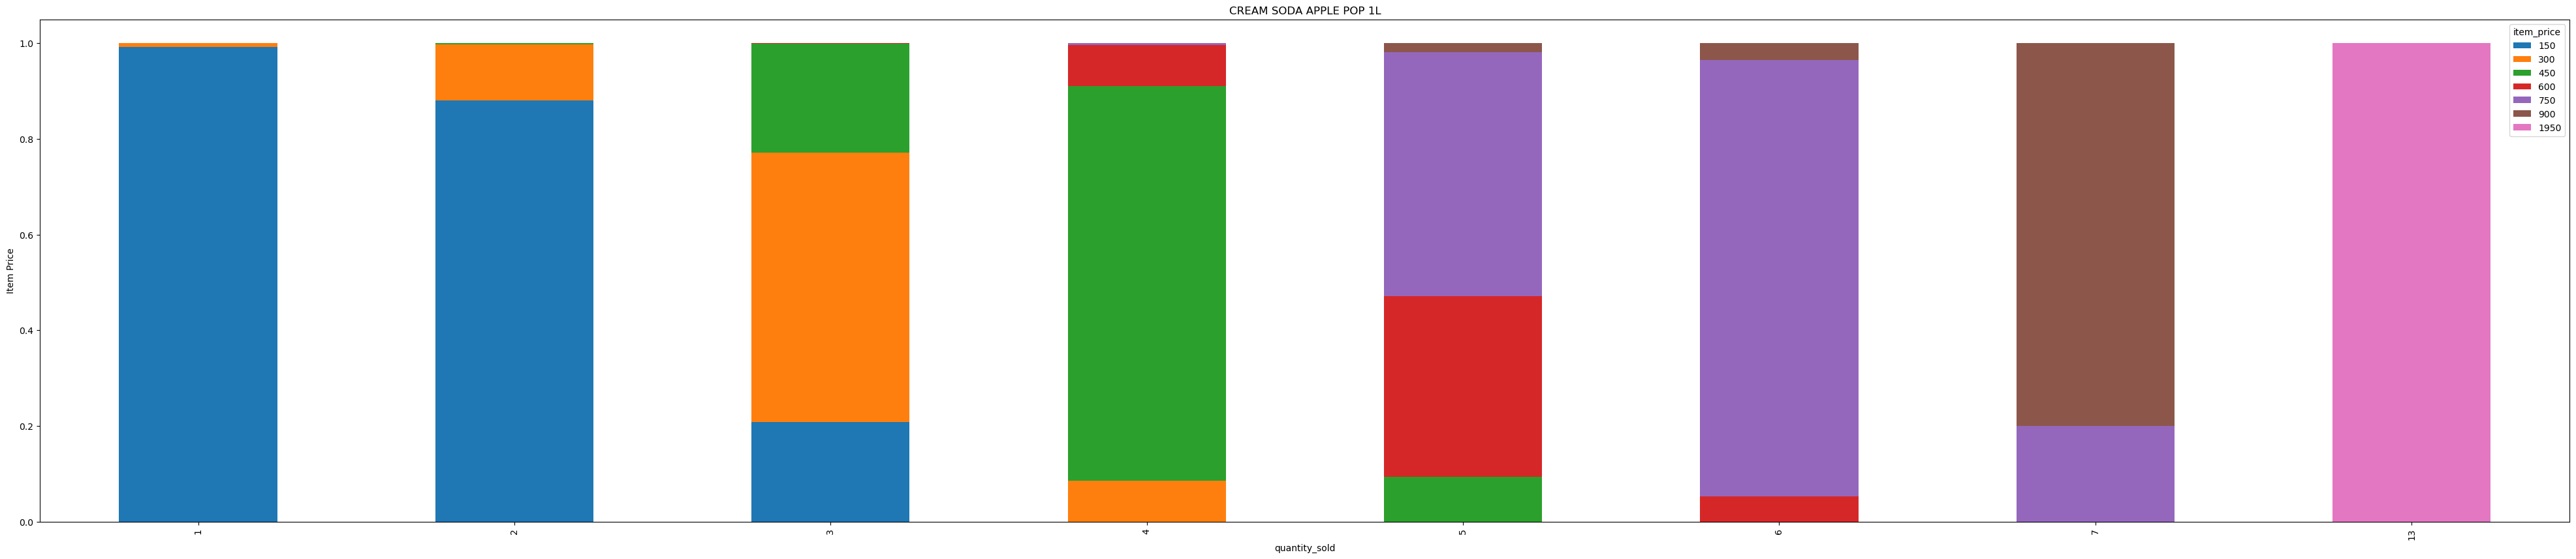

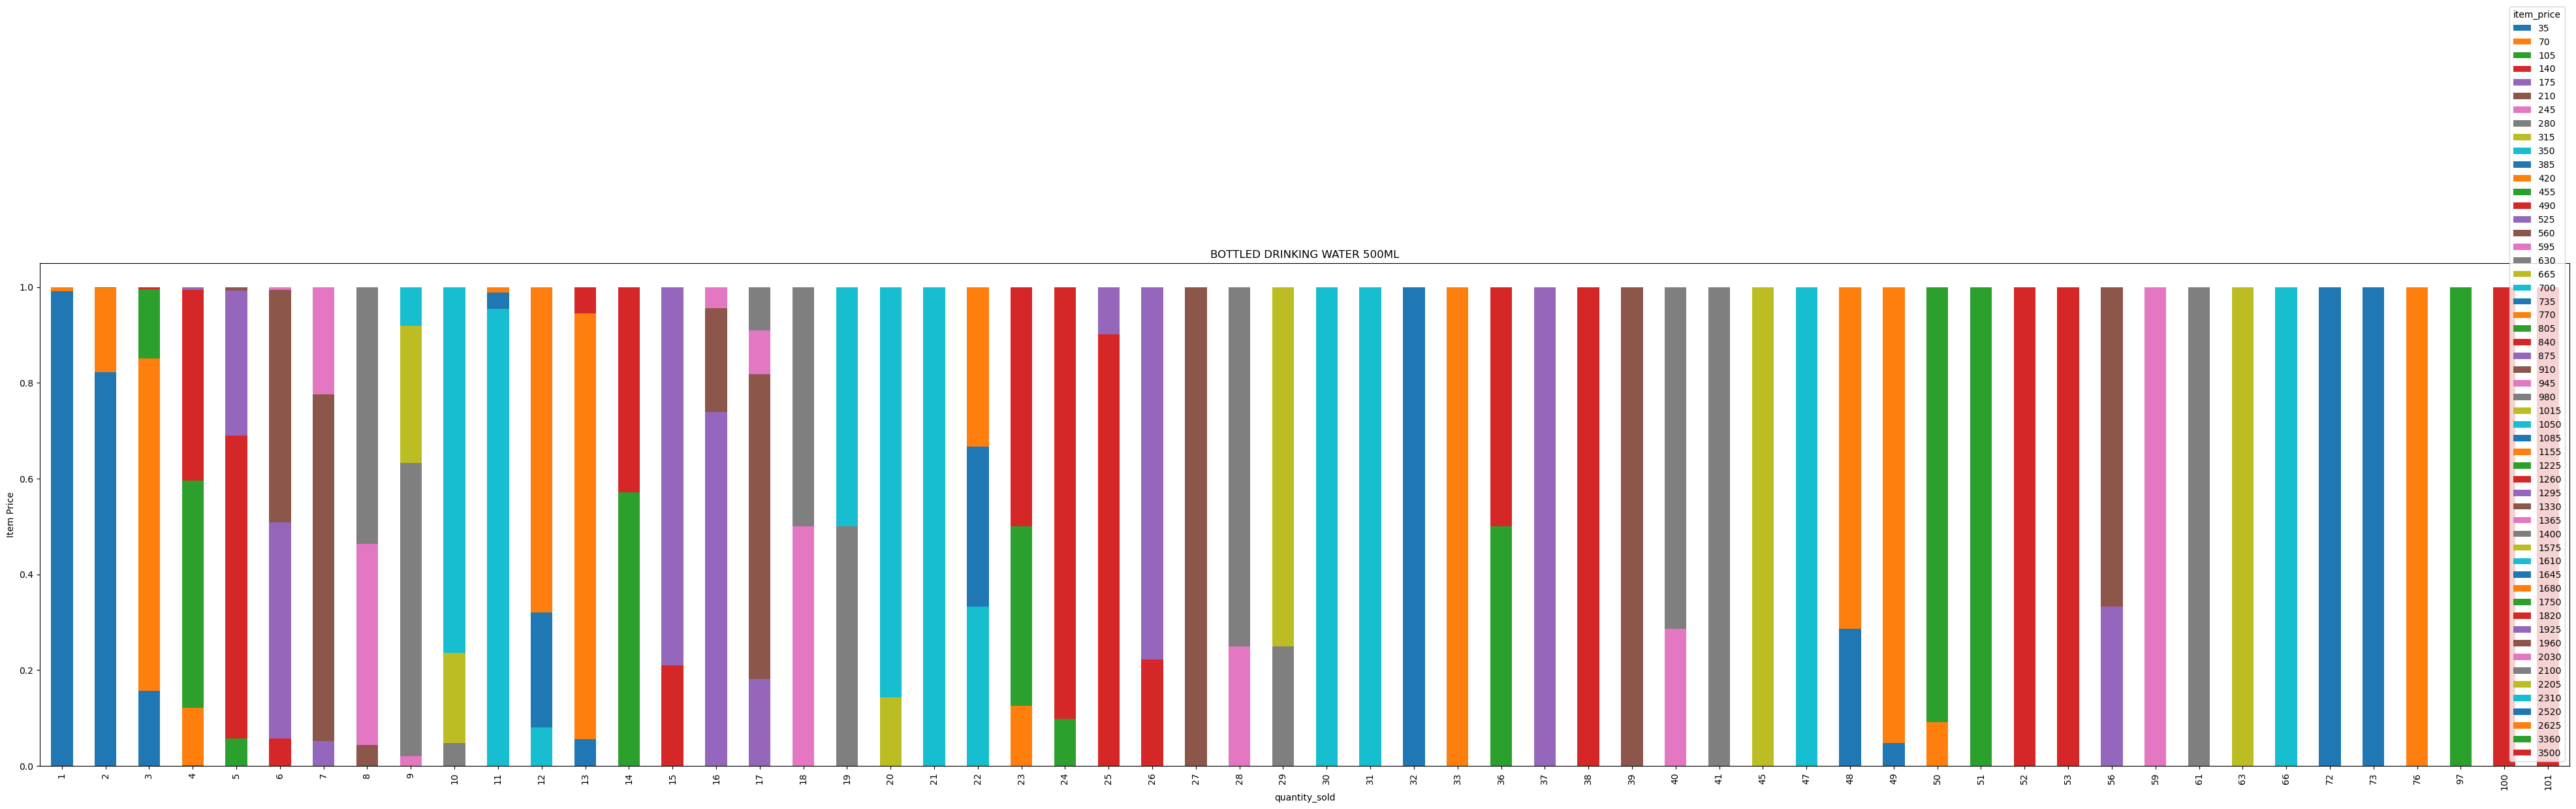

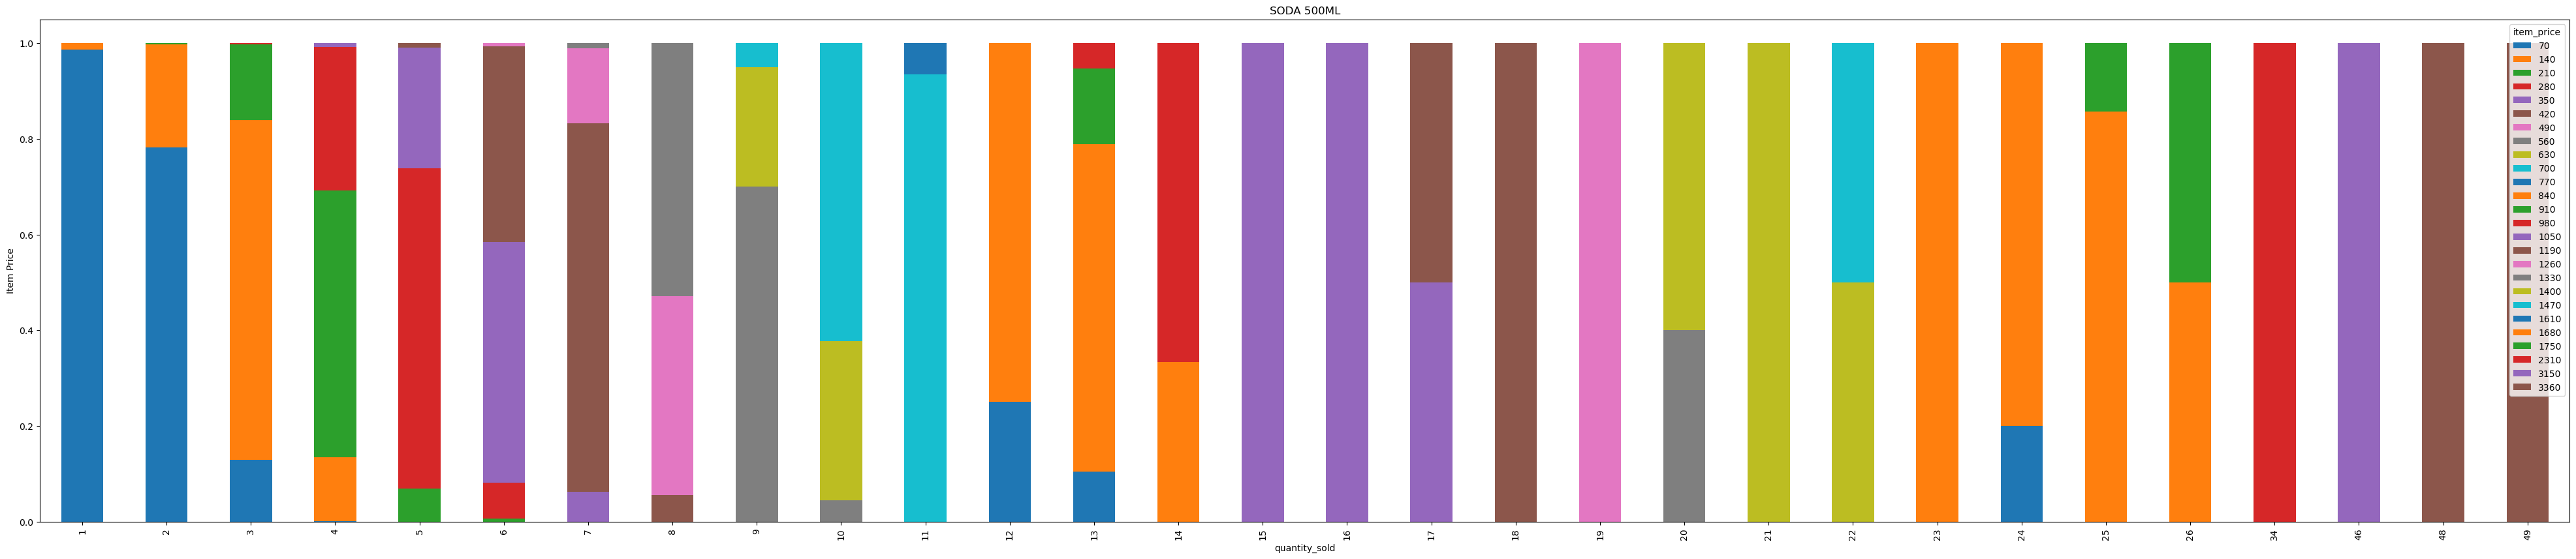

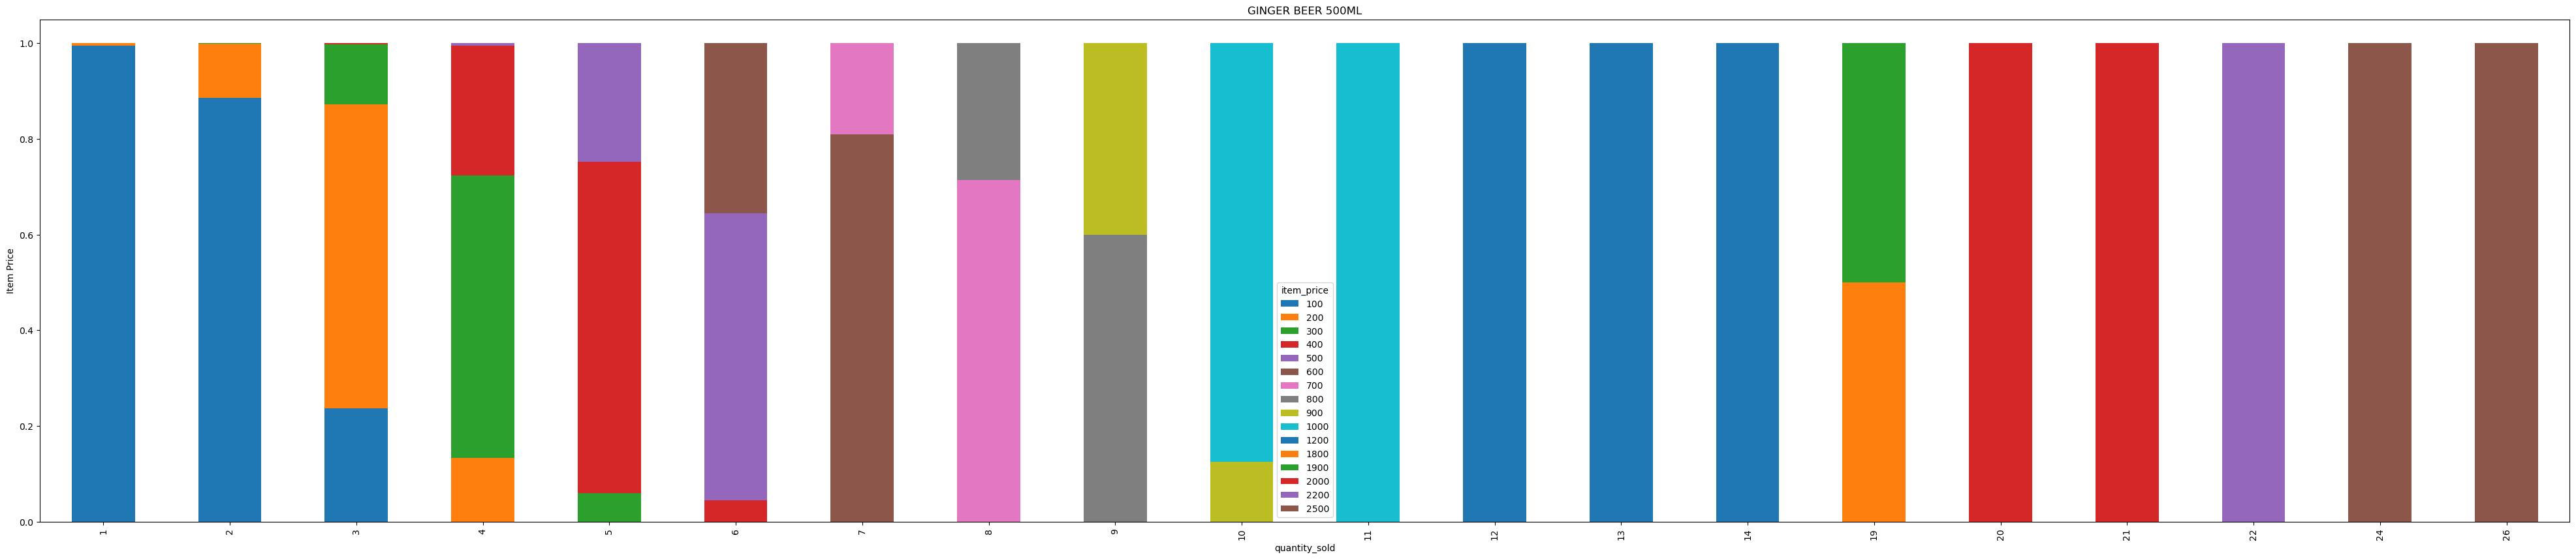

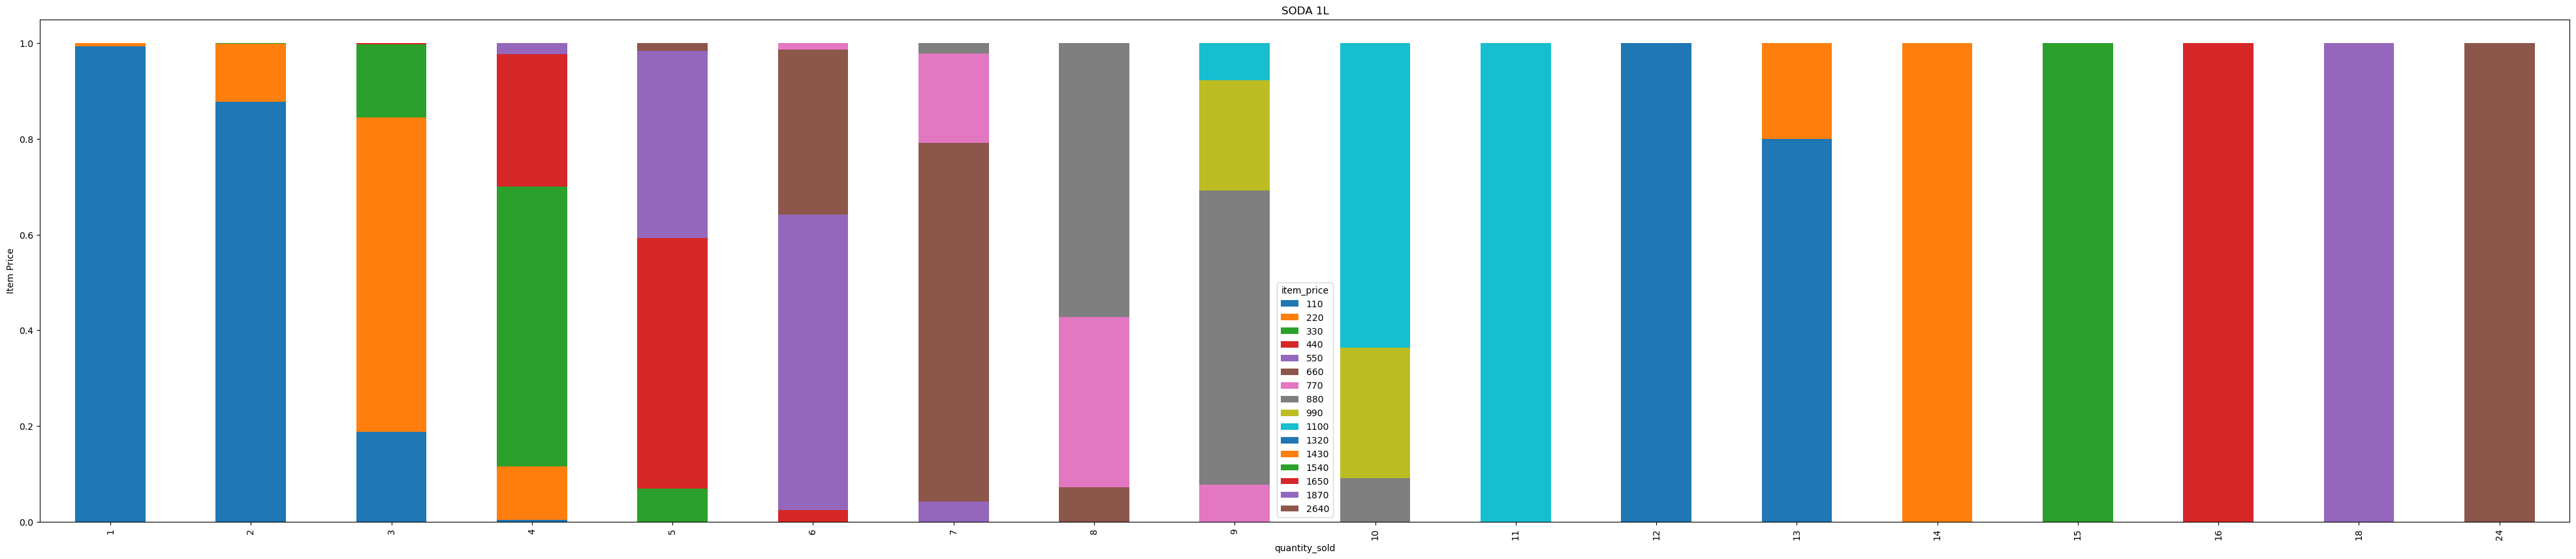

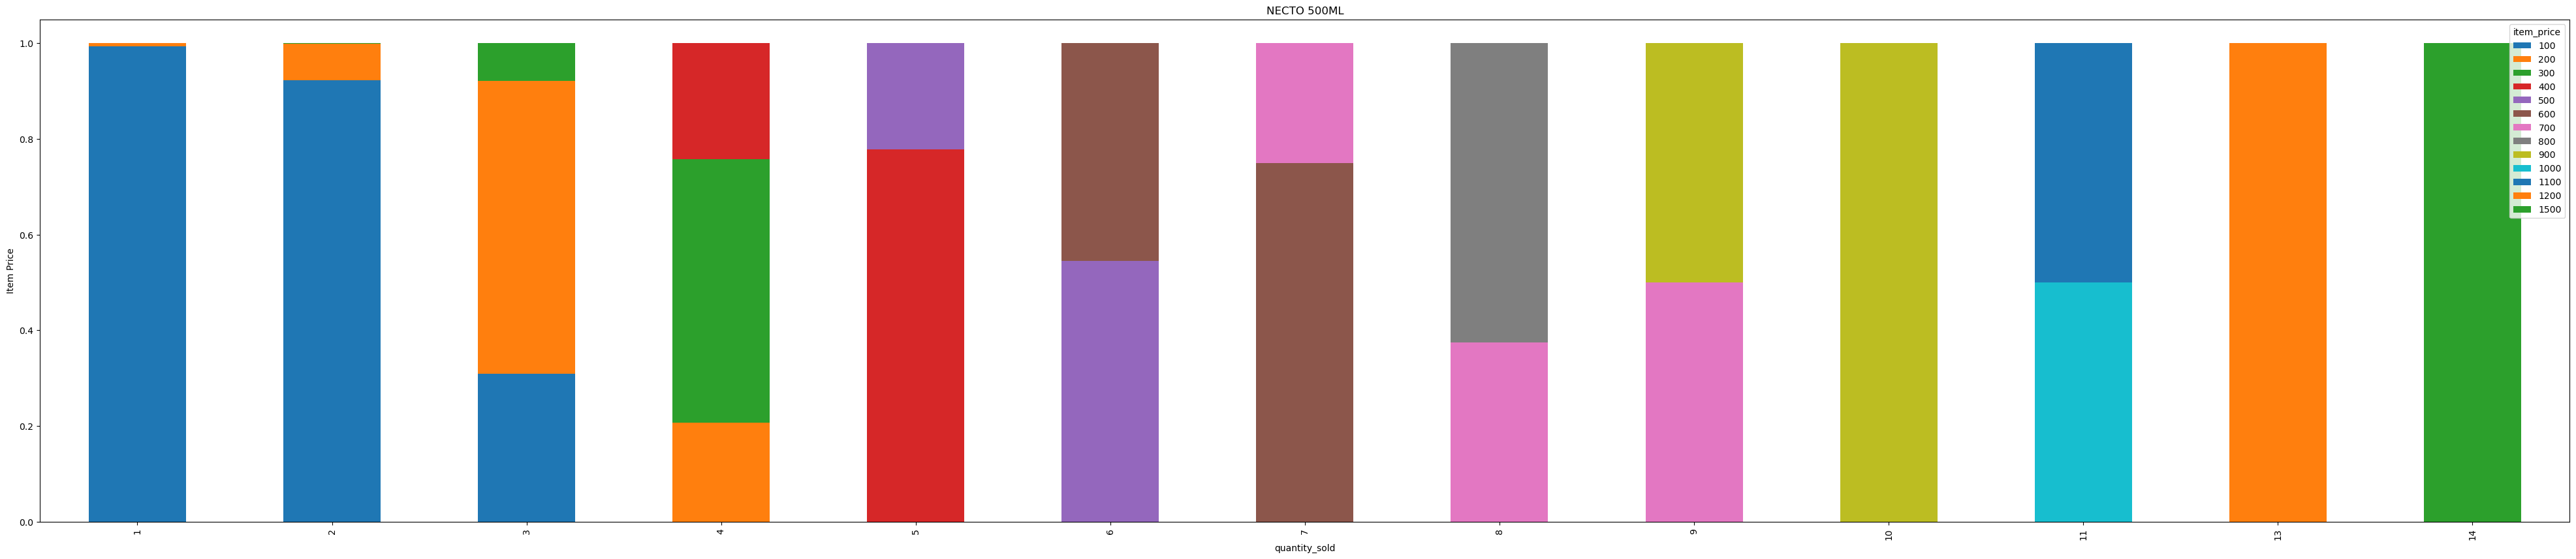

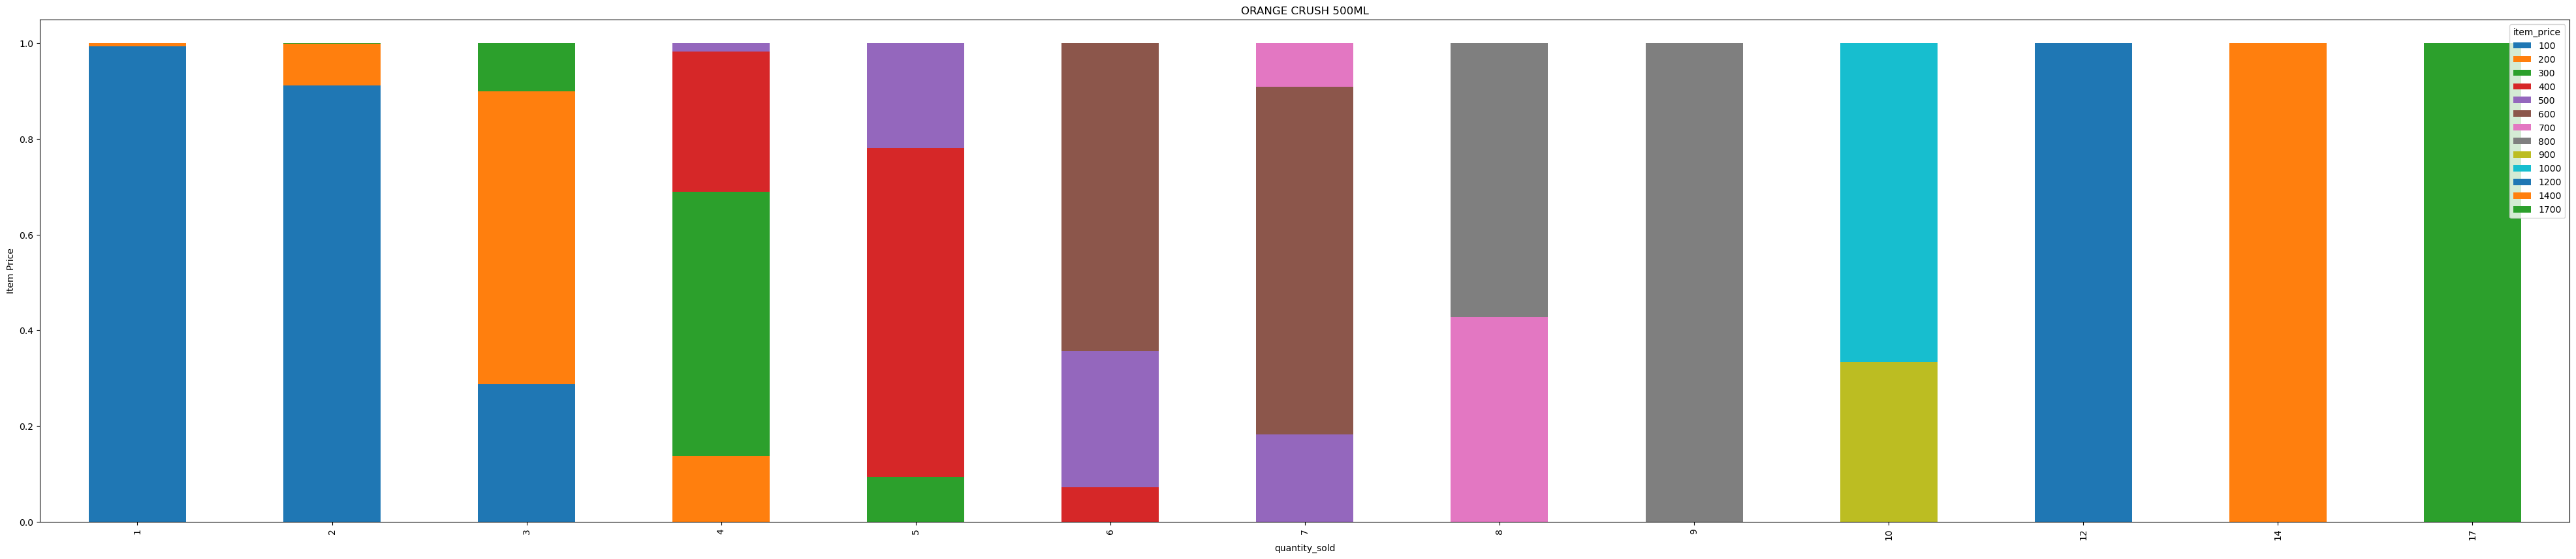

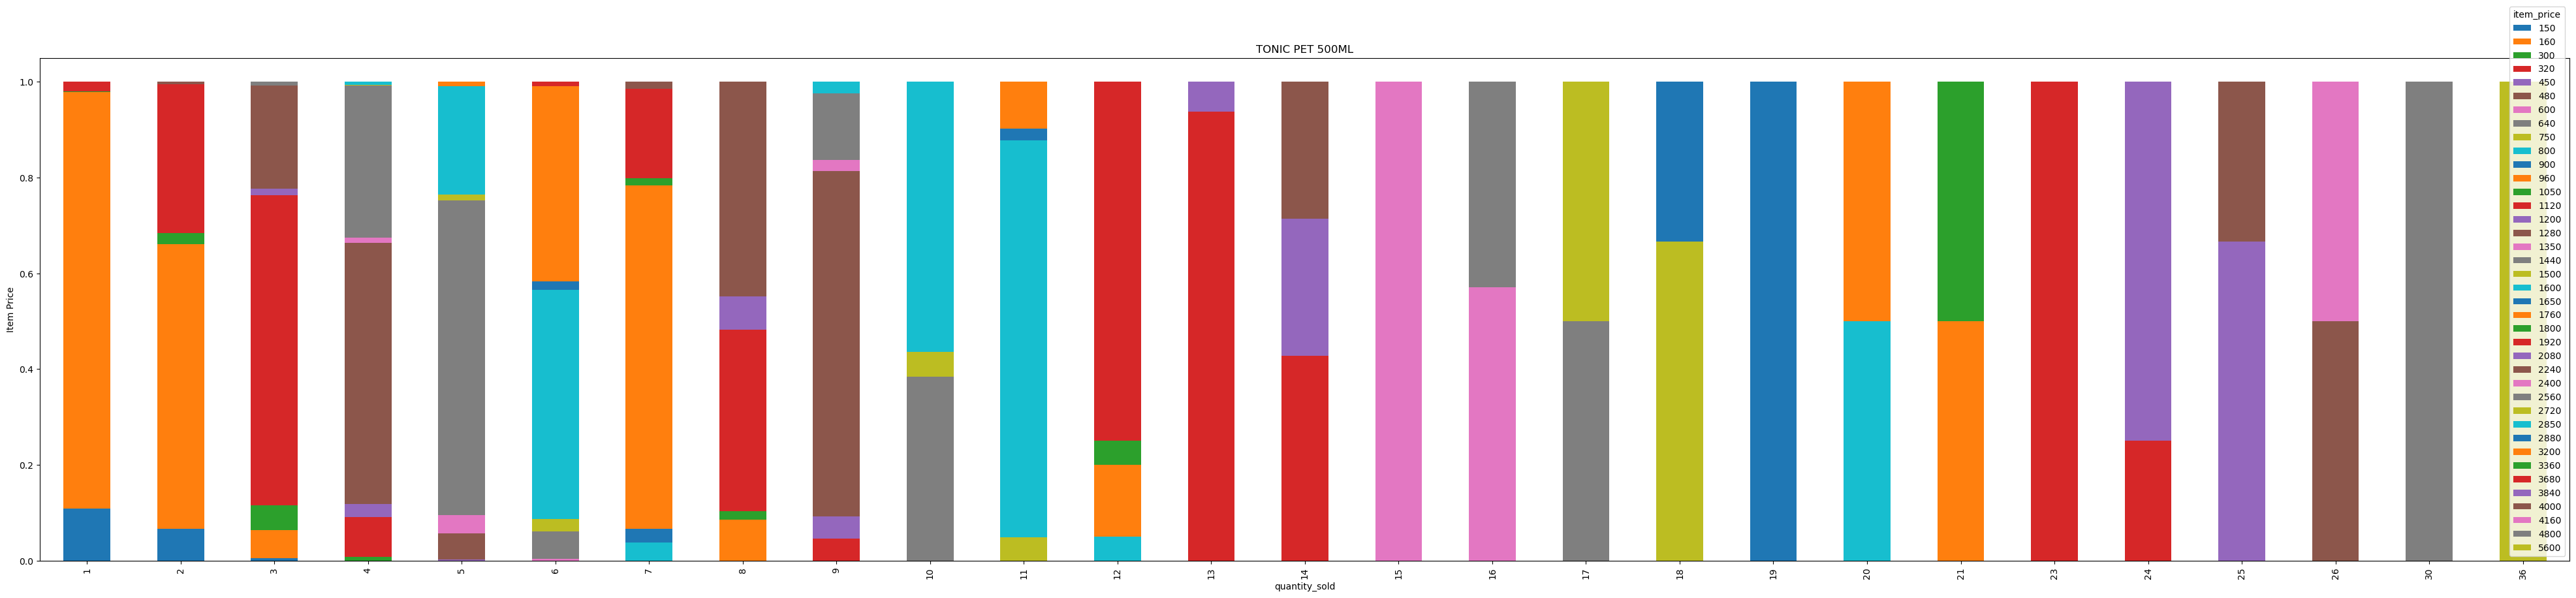

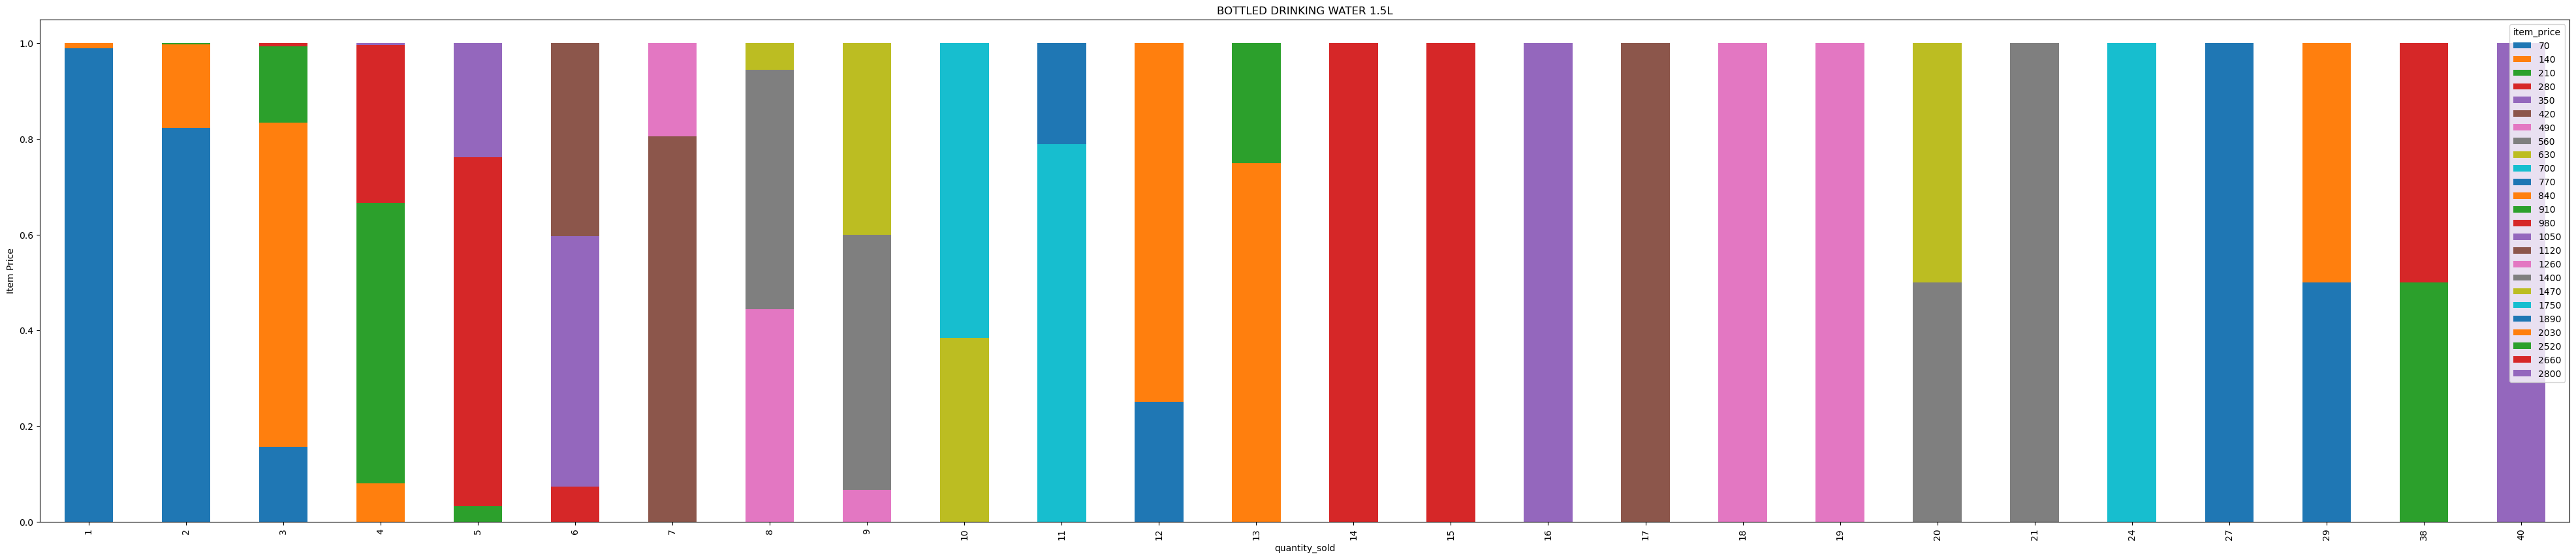

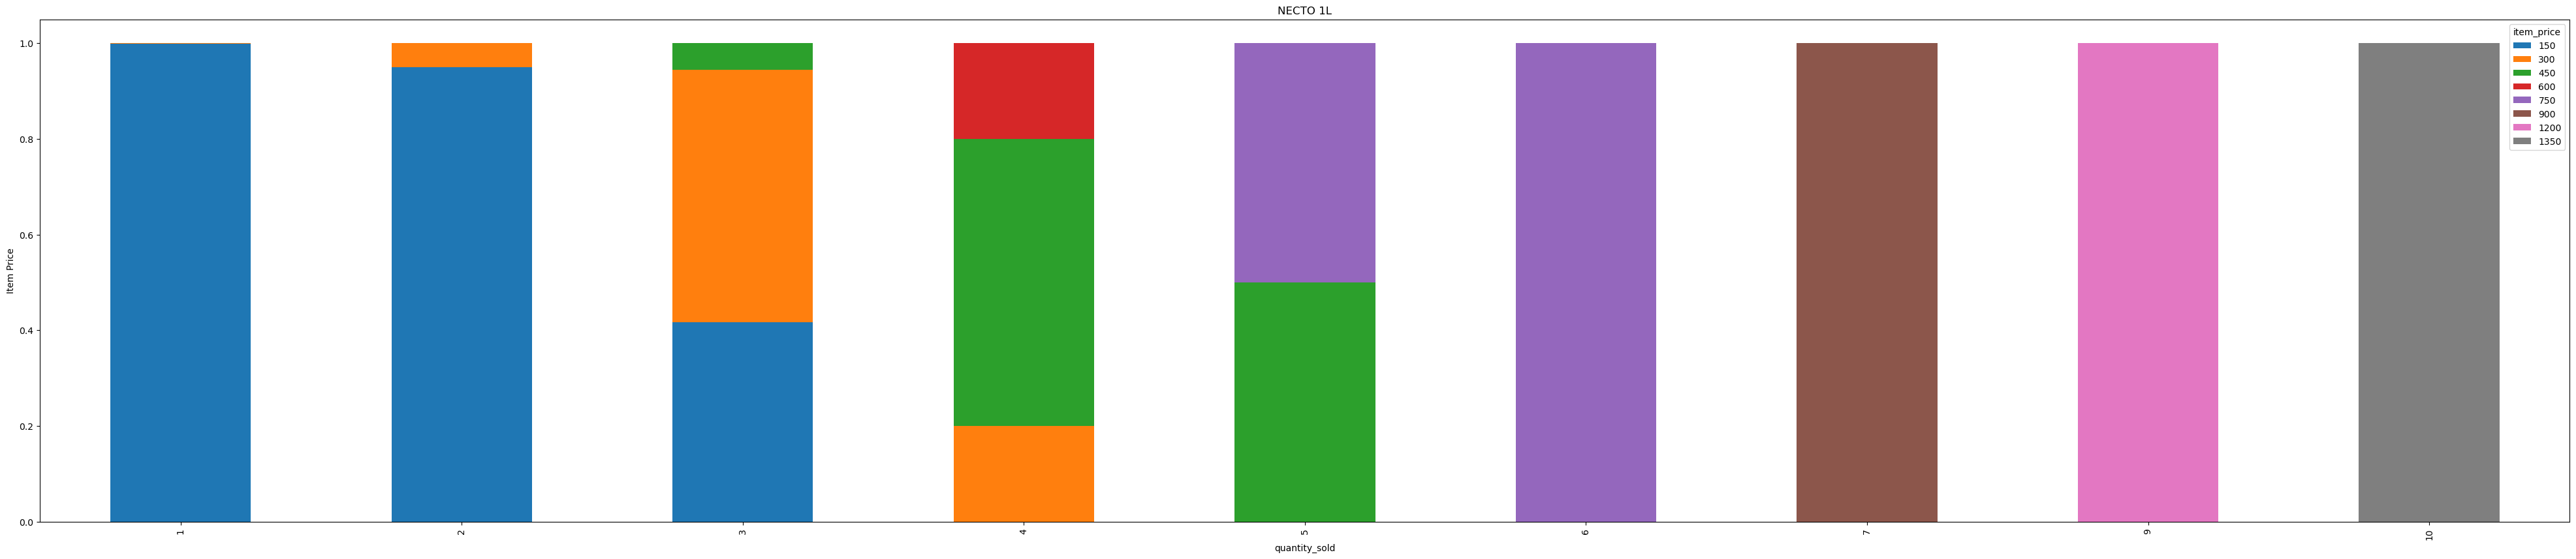

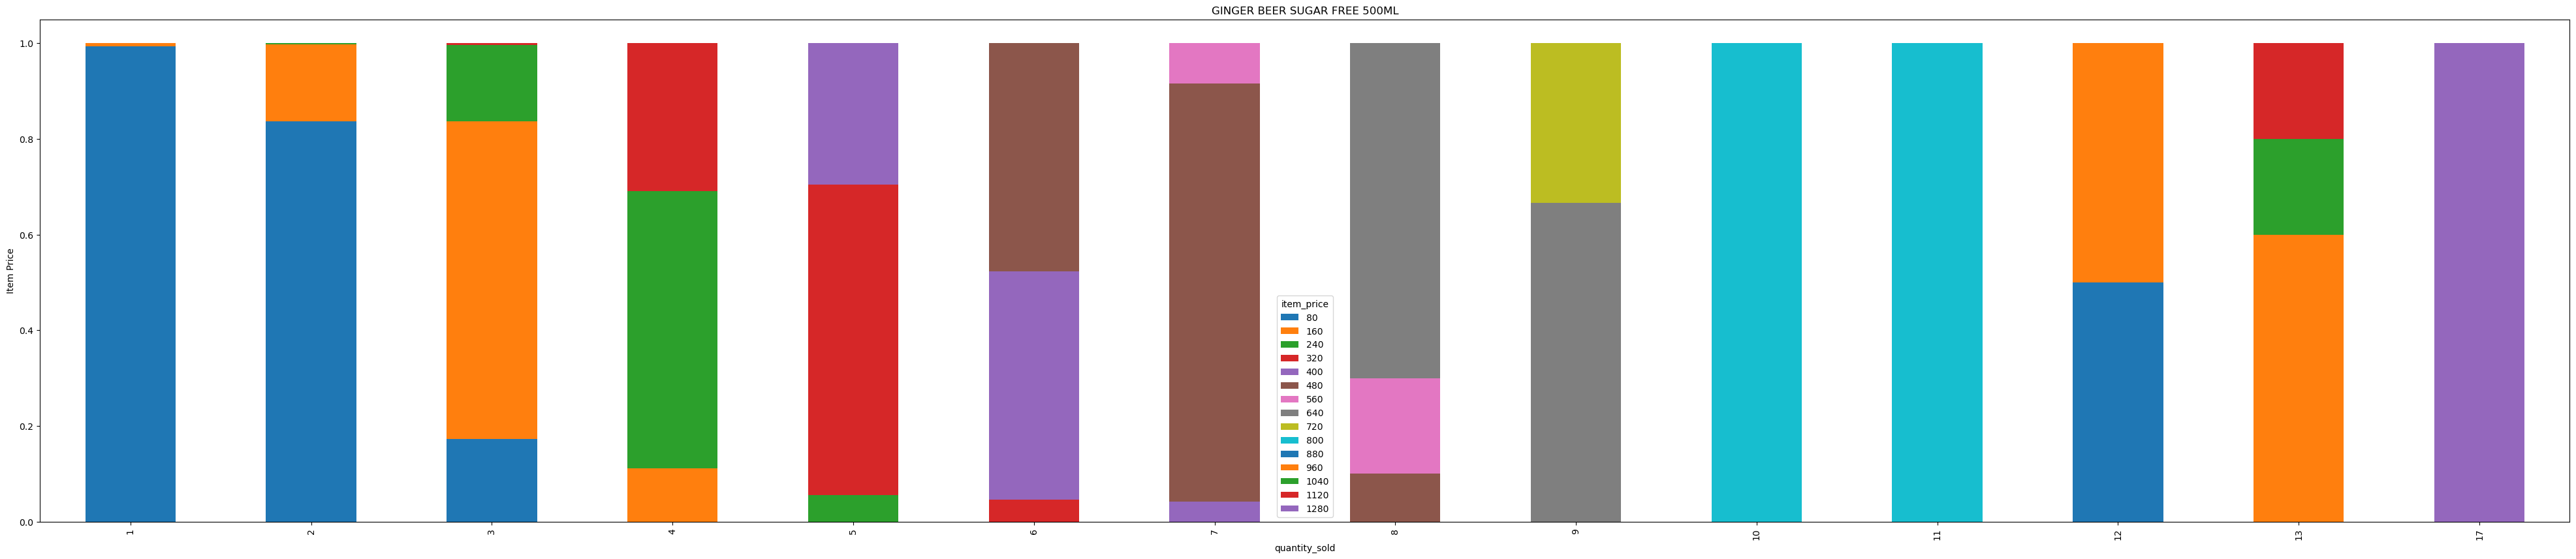

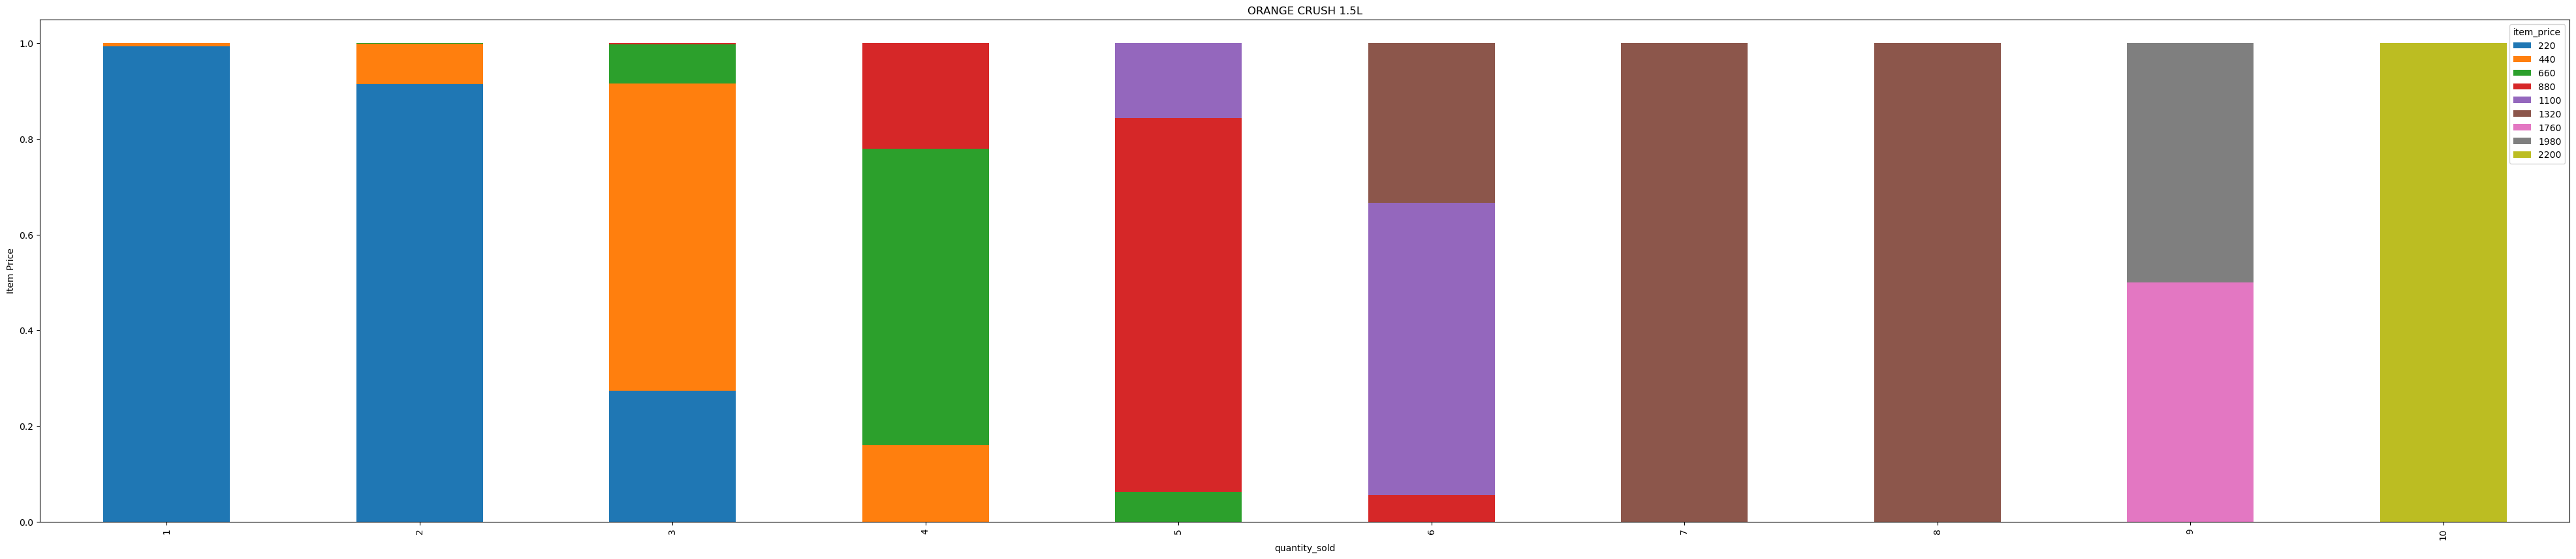

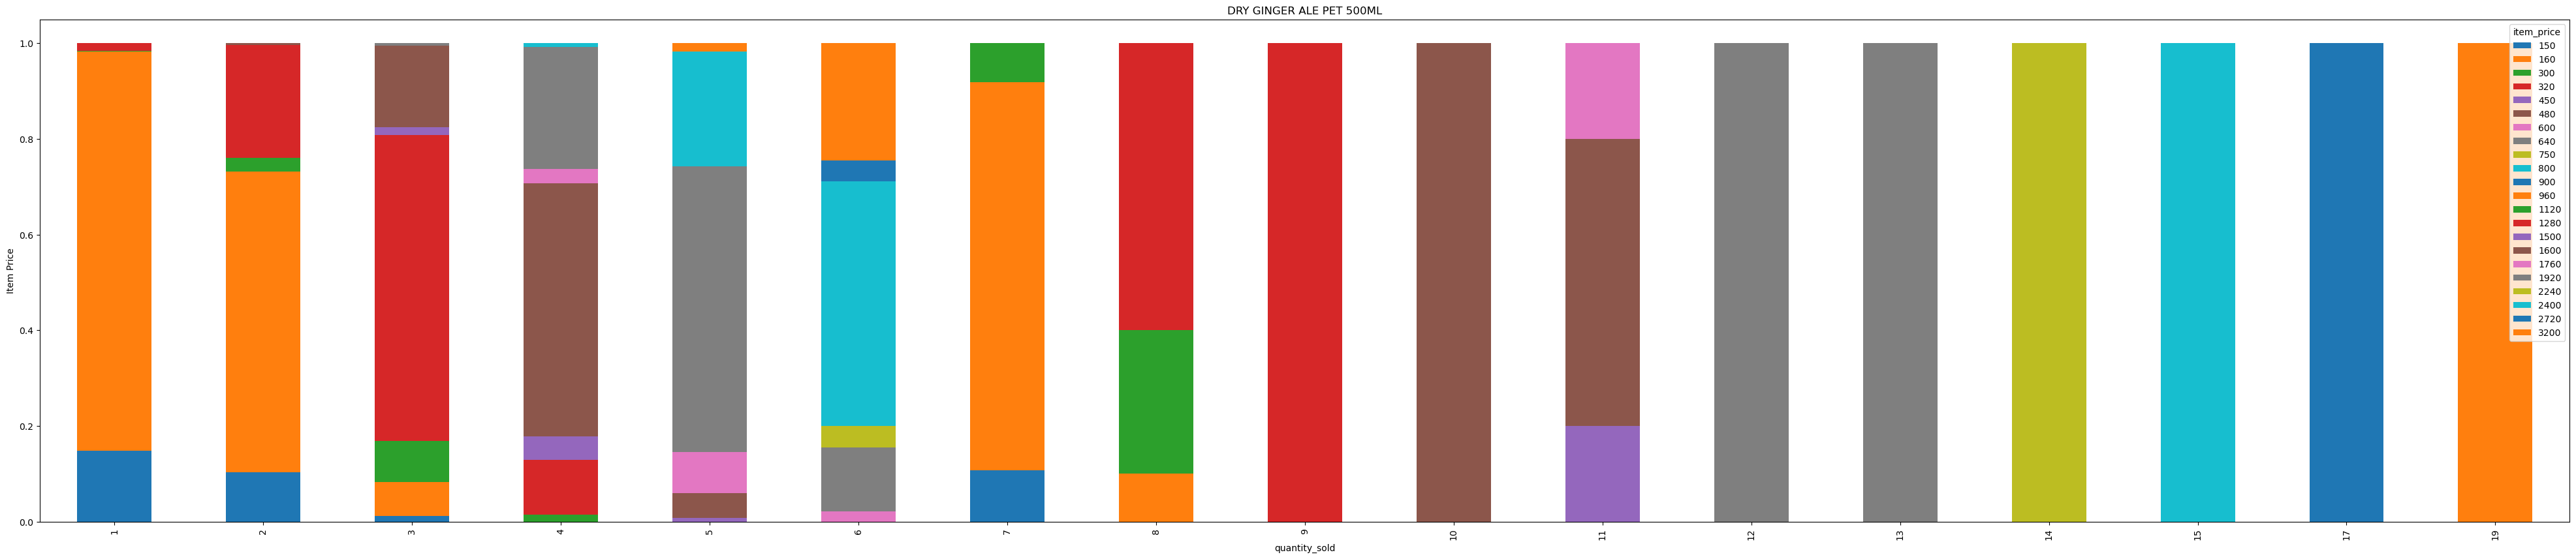

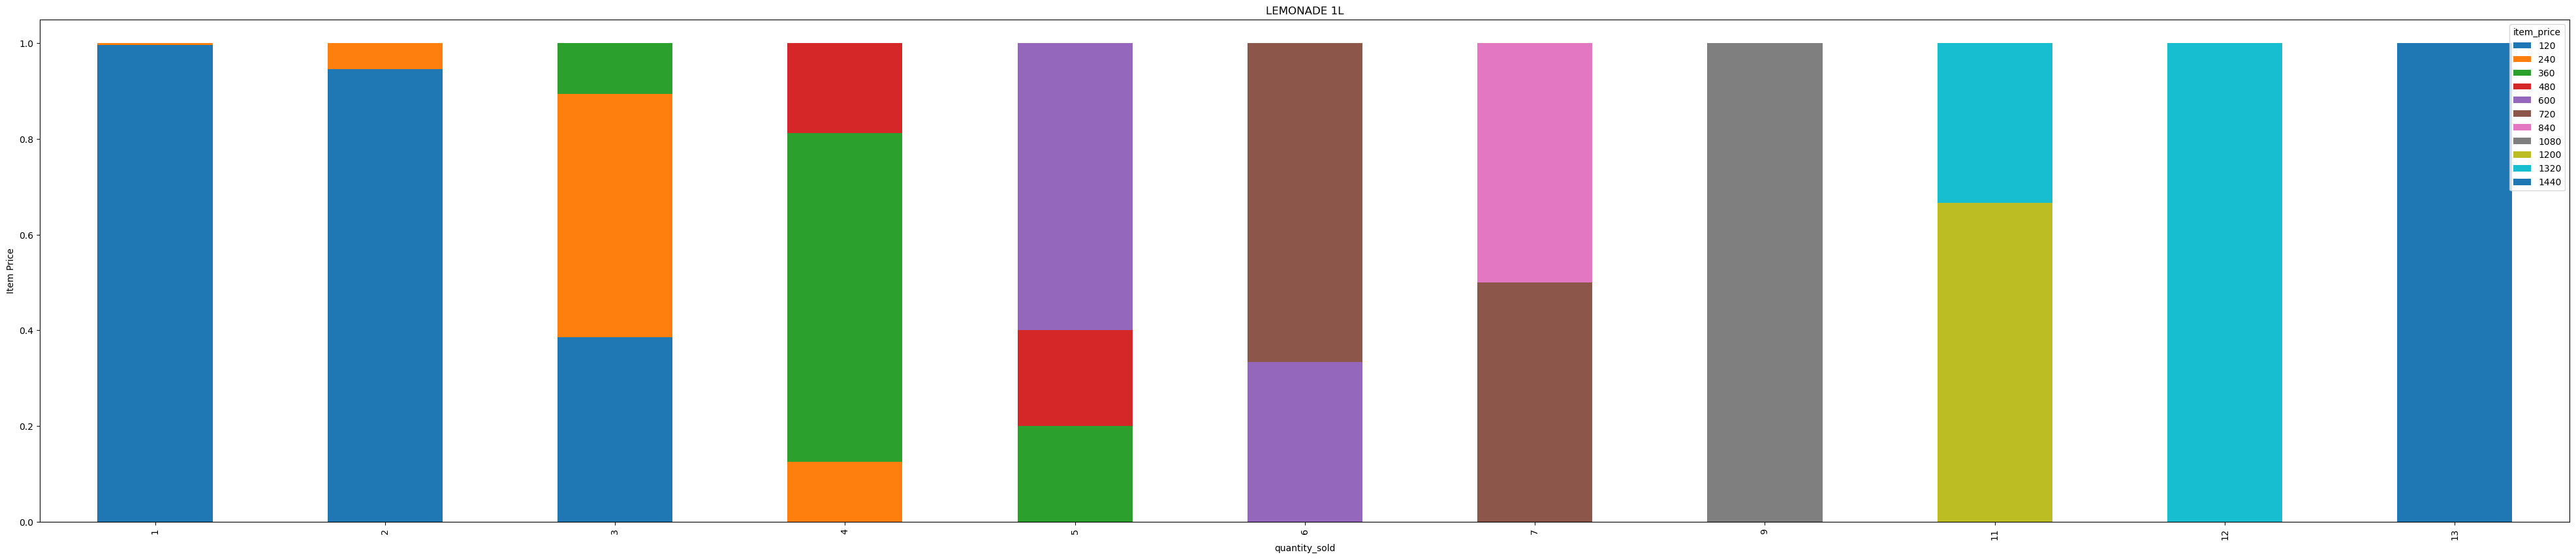

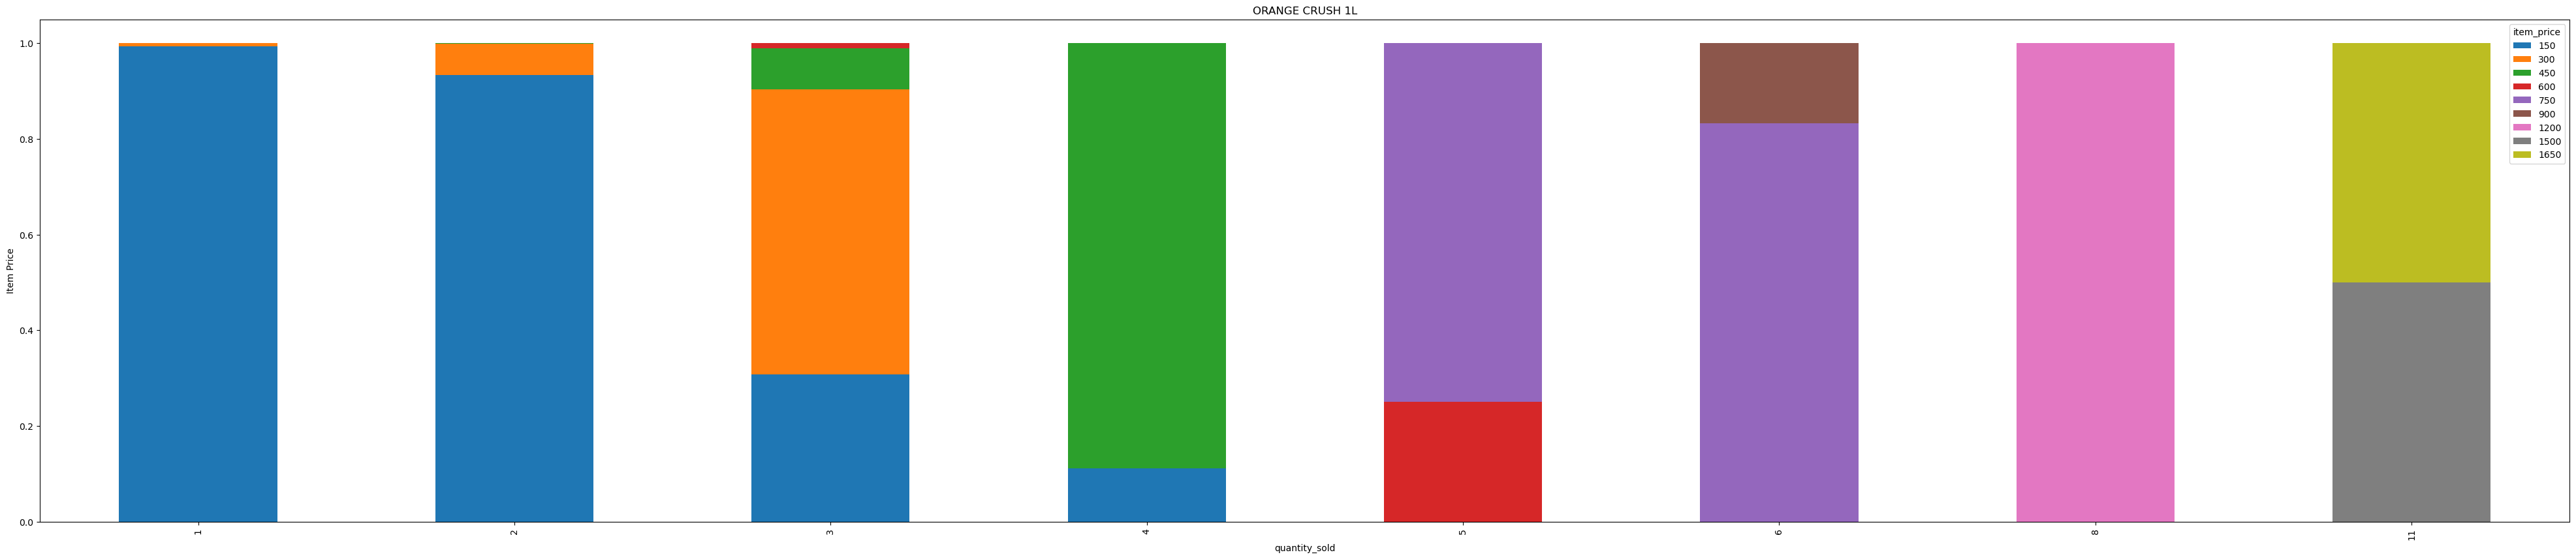

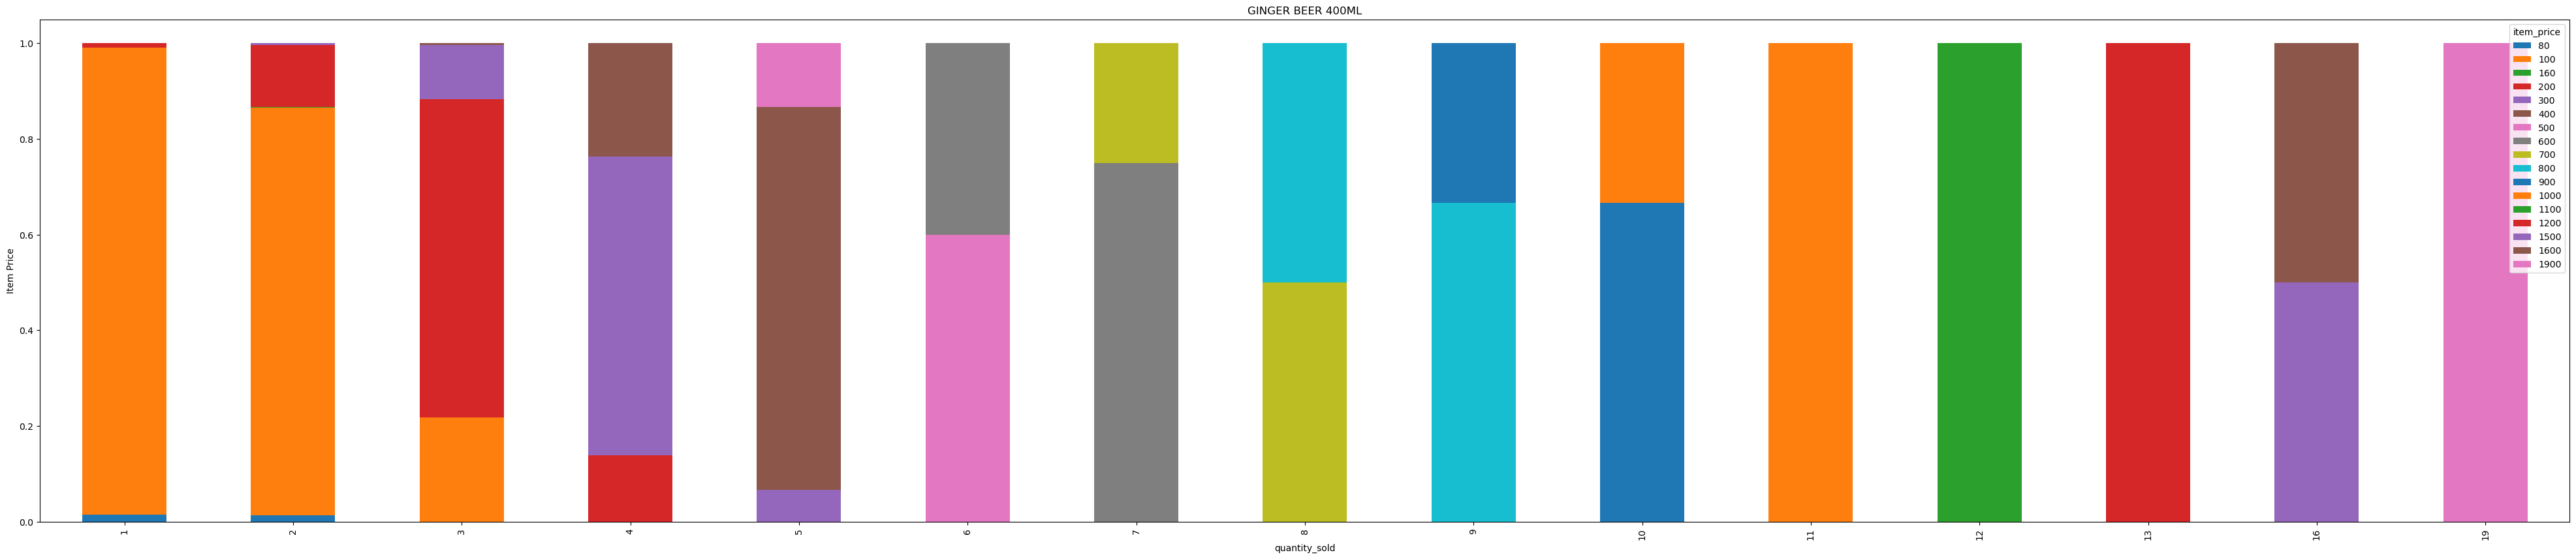

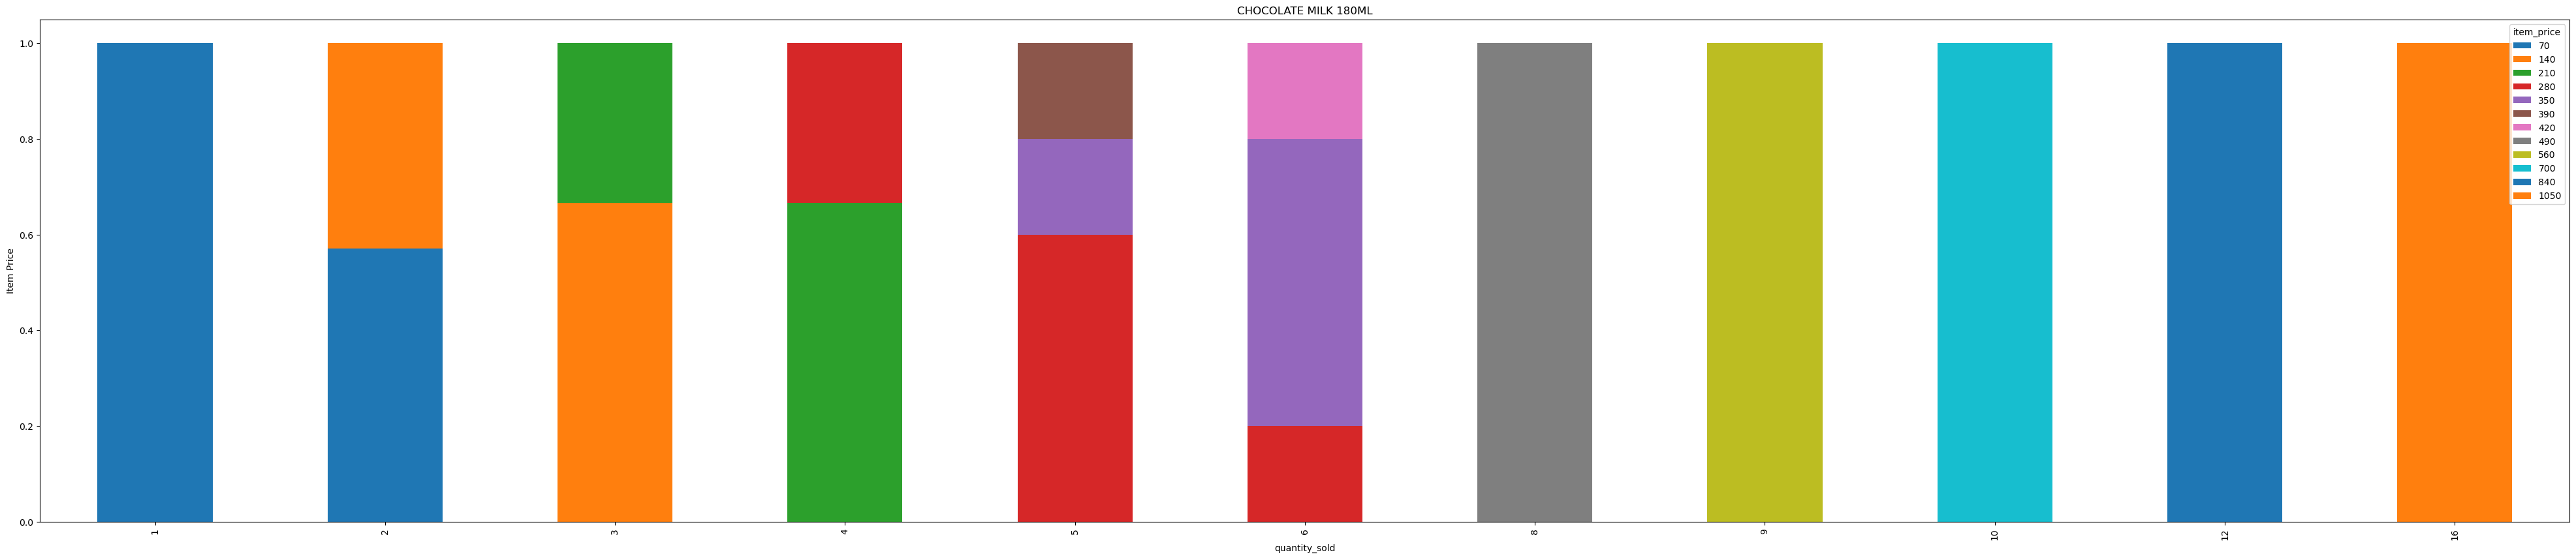

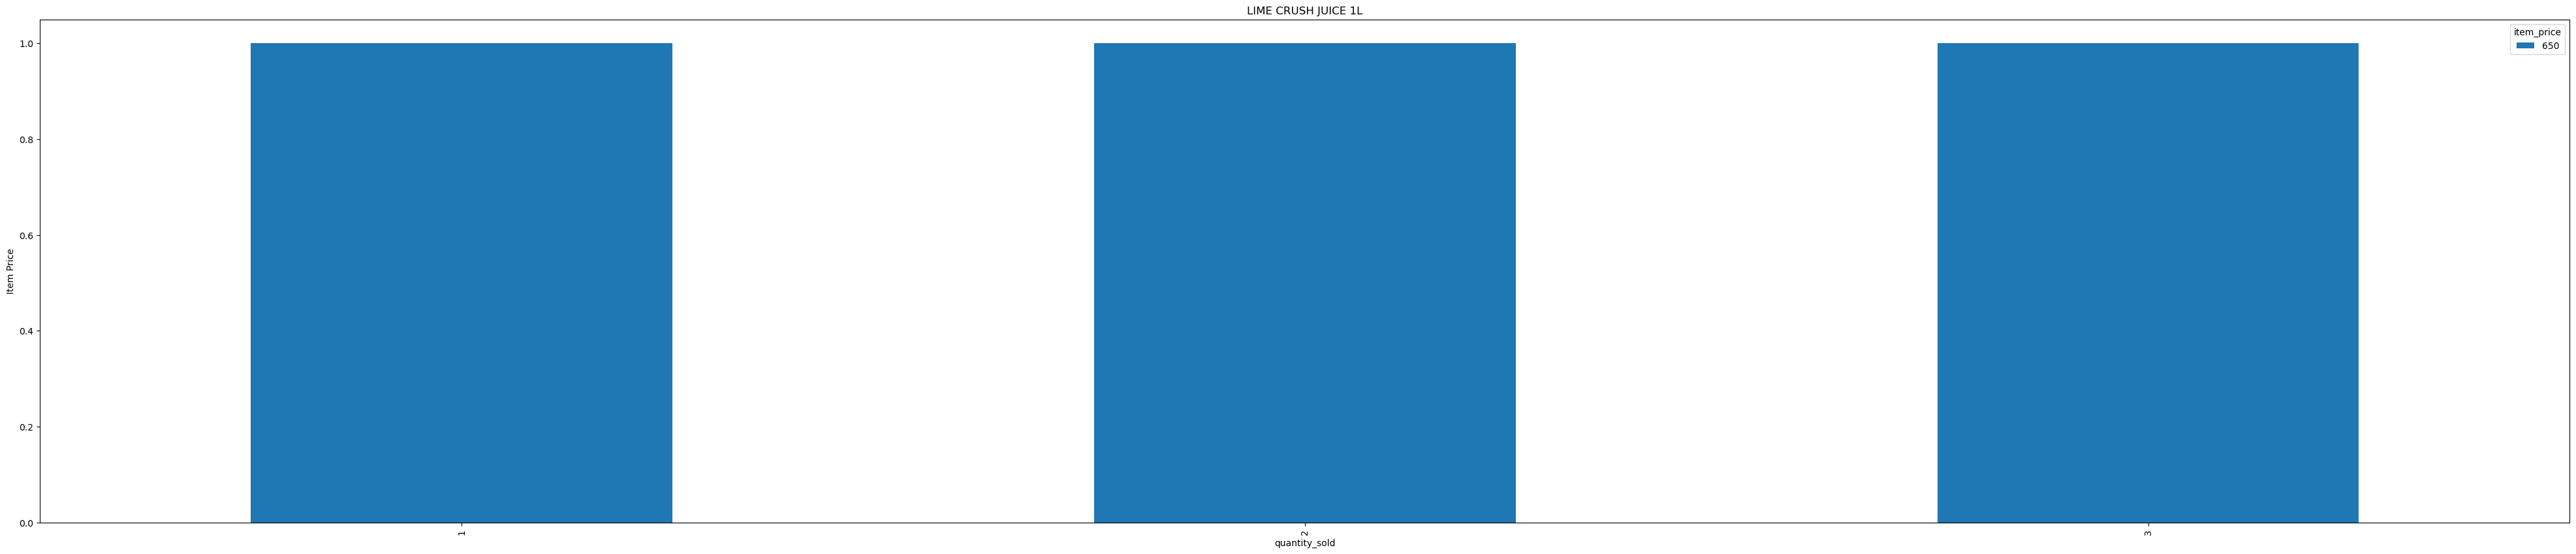

In [60]:
item_count_prices(df2['item_description'].unique())

In [62]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473702 entries, 1 to 473973
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   item_description  473702 non-null  object             
 1   transaction_date  473702 non-null  datetime64[ns, UTC]
 2   shop_id           473702 non-null  object             
 3   item_price        473702 non-null  int64              
 4   quantity_sold     473702 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 21.7+ MB


In [63]:
earliest_date = df['transaction_date'].min()
latest_date = df['transaction_date'].max()
print("Earliest Date: ",earliest_date,"\nLatest Date: ",latest_date)

Earliest Date:  2021-10-15 00:00:00+00:00 
Latest Date:  2021-12-15 00:00:00+00:00
